In [ ]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from torchbearer import Trial
import torchbearer
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import numpy as np
import sys
import os

from copy import deepcopy
from torch import nn


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False


train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# 数据集路径设置（假设数据集存放在~/data/tiny-imagenet-200）
data_root = os.path.expanduser('~/data/tiny-imagenet-200')


trainset = datasets.ImageFolder(
    root = '/Users/yl38u22/myResearch/data/tiny-imagenet-200/train',
    transform=train_transform
)

testset = datasets.ImageFolder(
    root = '/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
    transform=test_transform
)

batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [2]:
testset.classes

['n01443537',
 'n01629819',
 'n01641577',
 'n01644900',
 'n01698640',
 'n01742172',
 'n01768244',
 'n01770393',
 'n01774384',
 'n01774750',
 'n01784675',
 'n01855672',
 'n01882714',
 'n01910747',
 'n01917289',
 'n01944390',
 'n01945685',
 'n01950731',
 'n01983481',
 'n01984695',
 'n02002724',
 'n02056570',
 'n02058221',
 'n02074367',
 'n02085620',
 'n02094433',
 'n02099601',
 'n02099712',
 'n02106662',
 'n02113799',
 'n02123045',
 'n02123394',
 'n02124075',
 'n02125311',
 'n02129165',
 'n02132136',
 'n02165456',
 'n02190166',
 'n02206856',
 'n02226429',
 'n02231487',
 'n02233338',
 'n02236044',
 'n02268443',
 'n02279972',
 'n02281406',
 'n02321529',
 'n02364673',
 'n02395406',
 'n02403003',
 'n02410509',
 'n02415577',
 'n02423022',
 'n02437312',
 'n02480495',
 'n02481823',
 'n02486410',
 'n02504458',
 'n02509815',
 'n02666196',
 'n02669723',
 'n02699494',
 'n02730930',
 'n02769748',
 'n02788148',
 'n02791270',
 'n02793495',
 'n02795169',
 'n02802426',
 'n02808440',
 'n02814533',
 'n028

/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


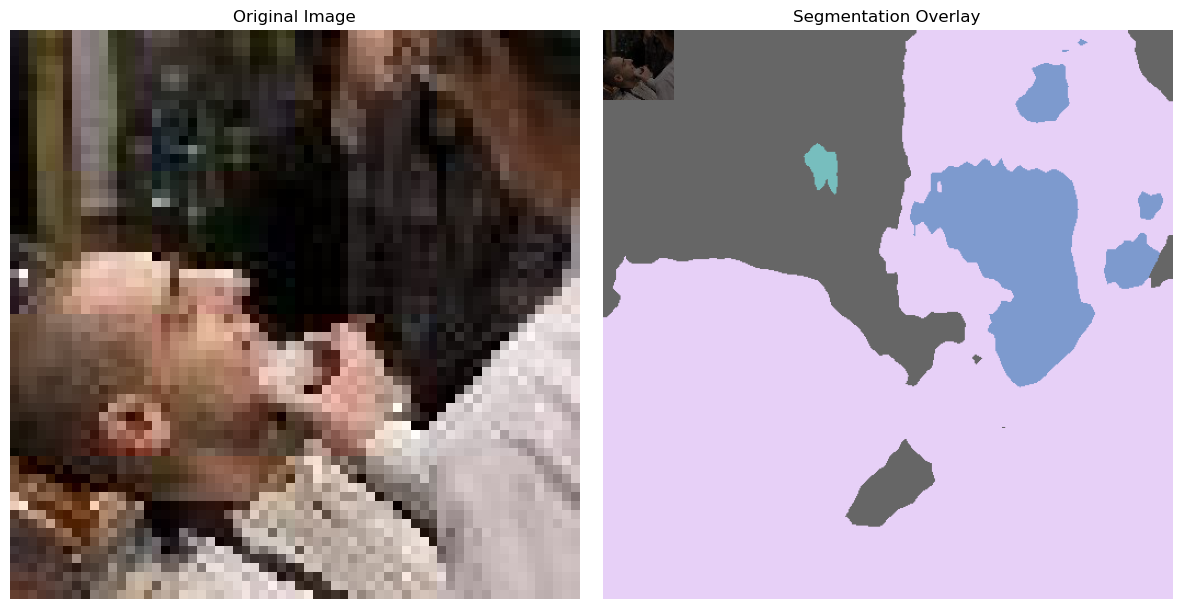

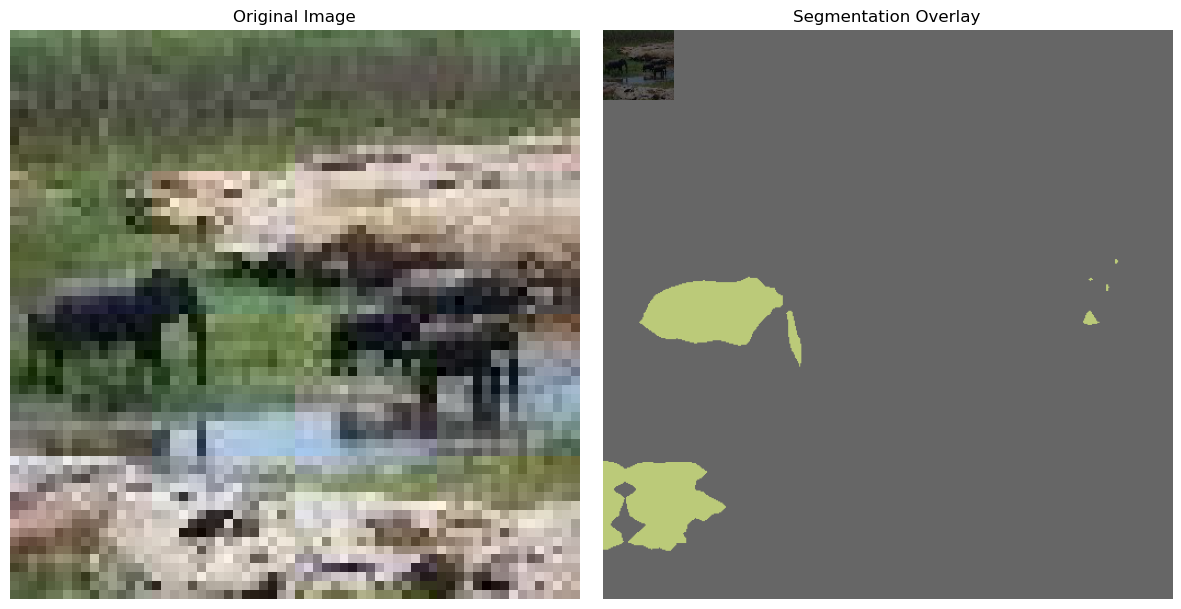

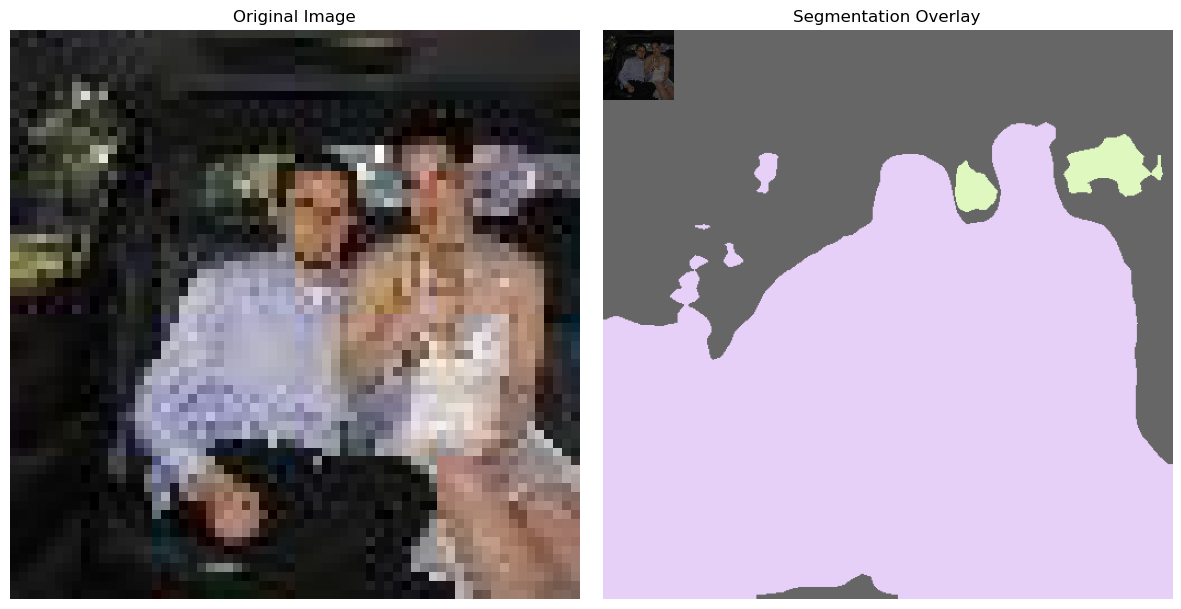

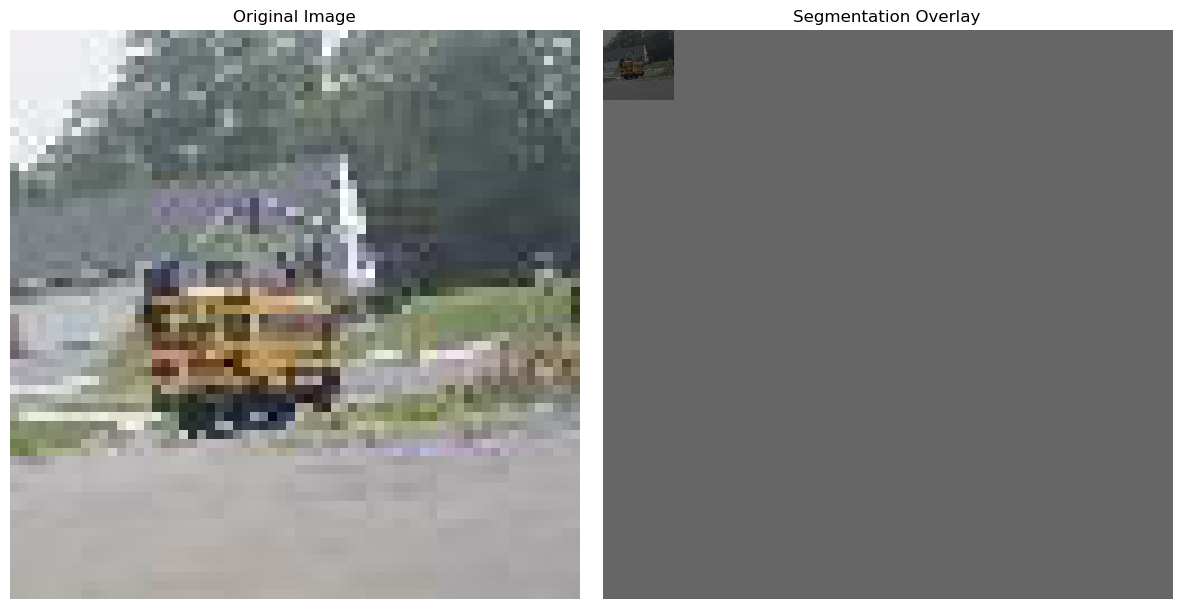

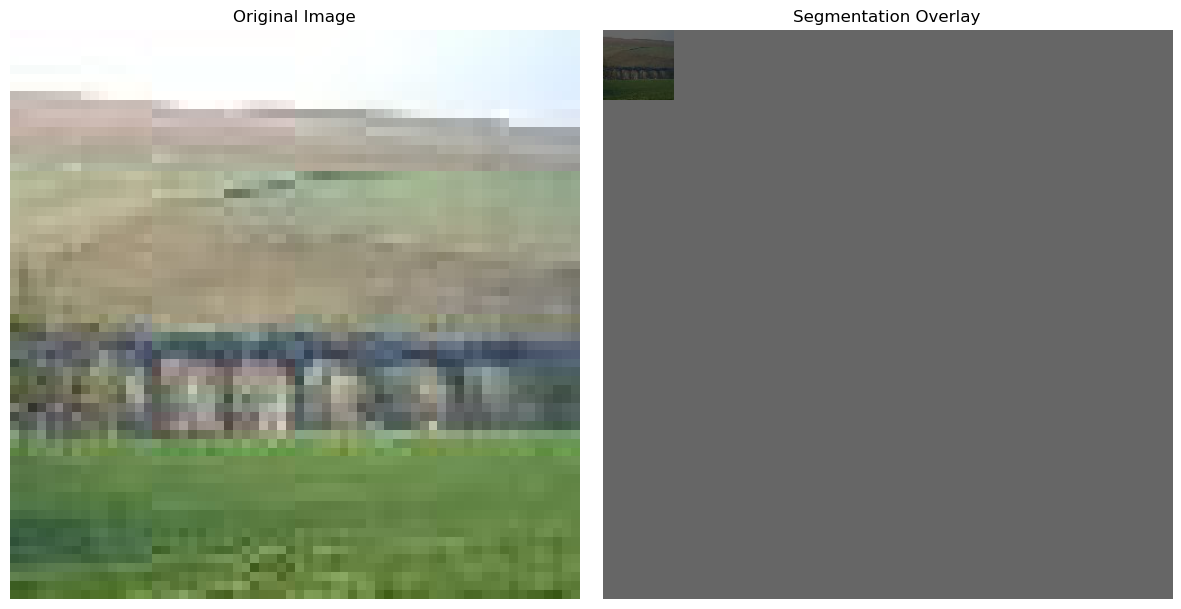

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 1. 加载预训练的DeepLabV3模型
def get_deeplab_model():
    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    model = model.to(device)
    model.eval()
    return model

seg_transform = transforms.Compose([
    transforms.Resize(520),          # 调整尺寸
    transforms.ToTensor(),           # 转换为Tensor
    transforms.Normalize(            # 标准化
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


raw_testset = datasets.ImageFolder(
    root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
    transform=None  # 重要：不应用任何预处理
)

# 4. 修改自定义数据集类
class SegmentationDataset(Dataset):
    def __init__(self, raw_dataset, transform=None):
        self.raw_dataset = raw_dataset
        self.transform = transform
        self.color_map = self._create_color_map()
        
    def __len__(self):
        return len(self.raw_dataset)
    
    def _create_color_map(self):
        cmap = np.zeros((256, 3), dtype=np.uint8)
        cmap[0] = [0, 0, 0]  # 背景
        for i in range(1, 256):
            cmap[i] = np.random.randint(0, 255, 3)
        return cmap
    
    def __getitem__(self, idx):
        # 获取原始PIL图像
        img_pil, label = self.raw_dataset[idx]
        

        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)
        
   
        with torch.no_grad():
            input_tensor = img_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
            
        # 转换为彩色掩码
        colored_mask = self.color_map[mask]
        
        return img_pil, colored_mask, label
    # 4. 可视化函数保持不变
def visualize_segmentation(original, mask, alpha=0.6):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(original)
    plt.imshow(mask, alpha=alpha)
    plt.title("Segmentation Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    model = get_deeplab_model()
    seg_testset = SegmentationDataset(raw_testset, transform=seg_transform)
    

    num_samples = 5
    indices = np.random.choice(len(seg_testset), num_samples)
    
    for i in indices:
        img, mask, label = seg_testset[i]
        visualize_segmentation(np.array(img), mask)



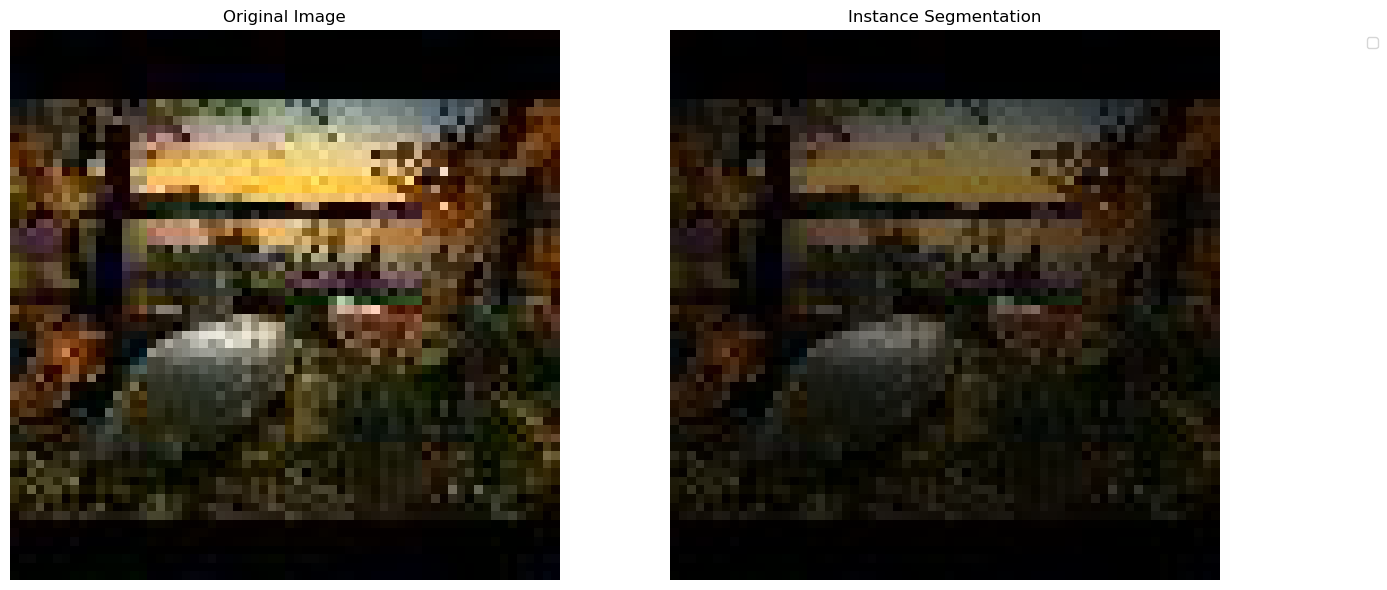

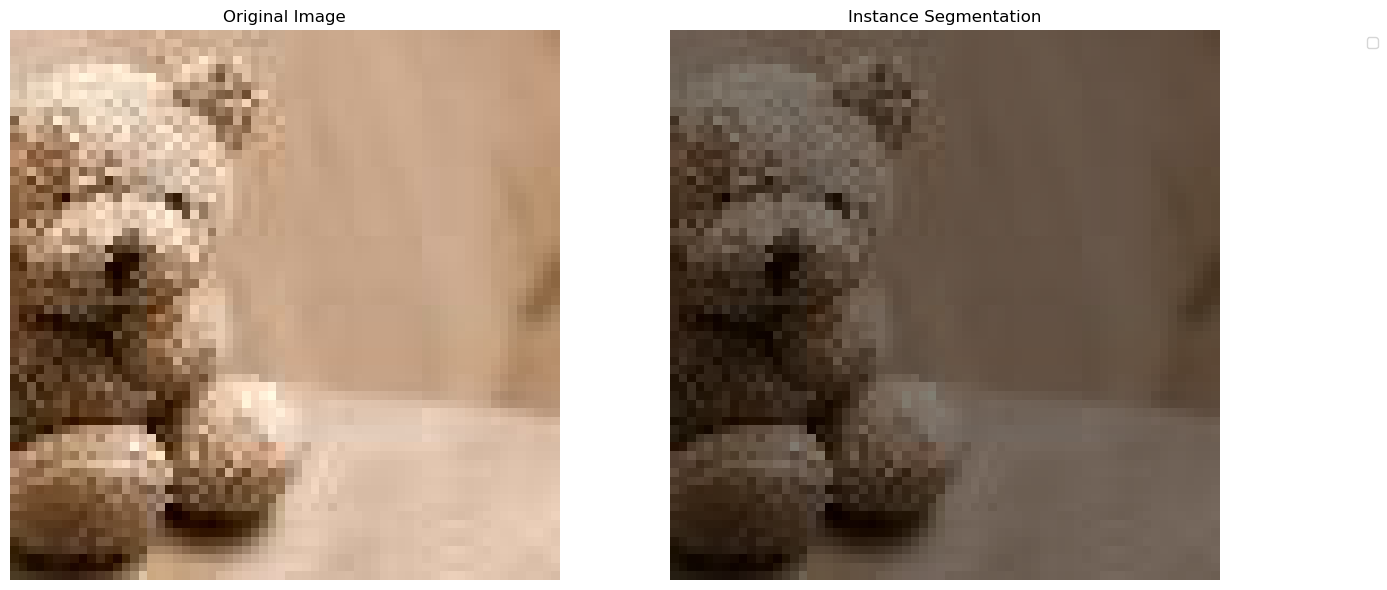

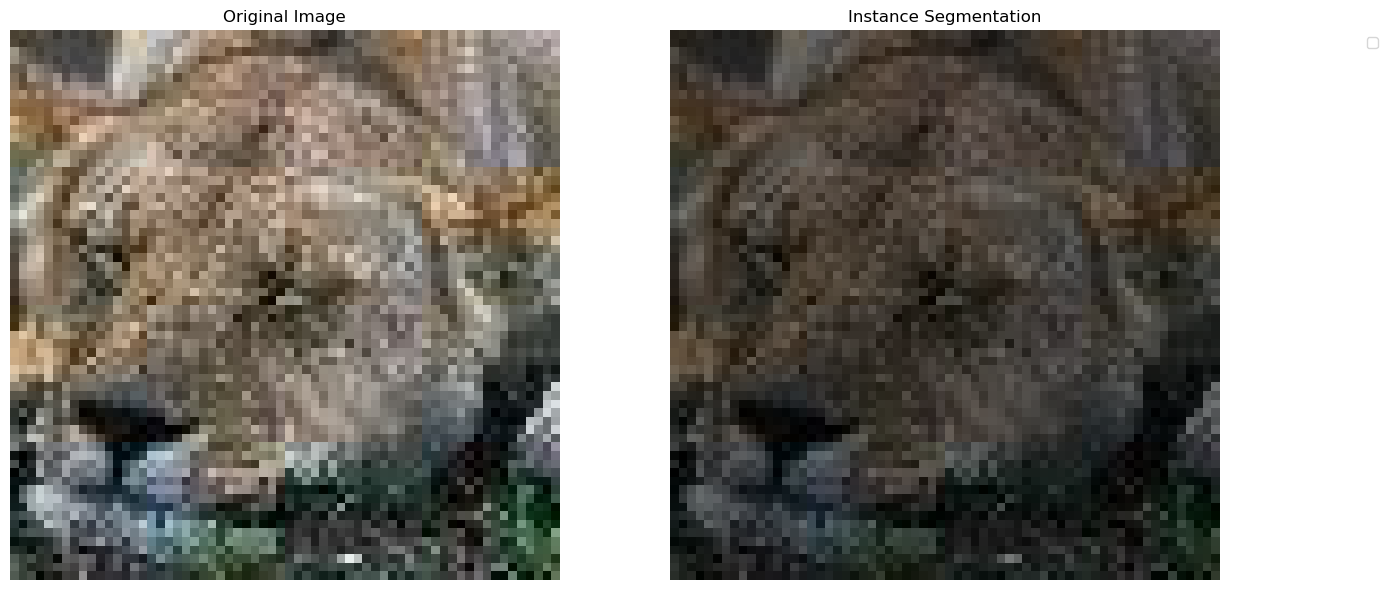

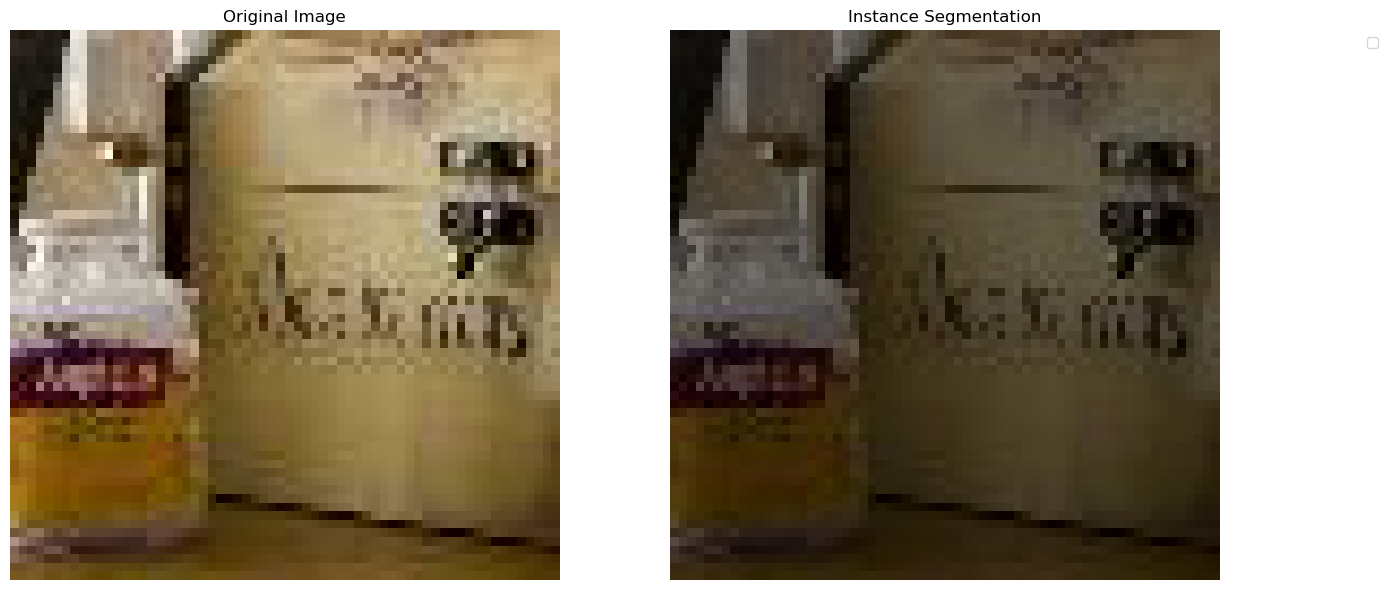

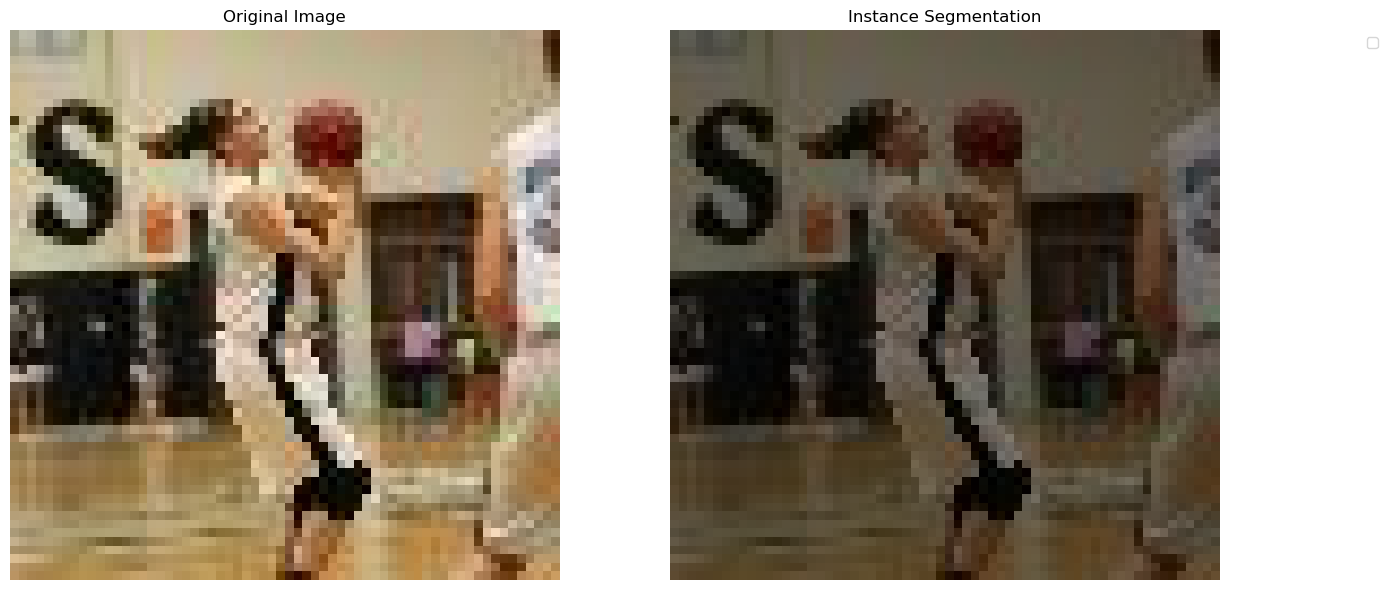

In [5]:
import torch
import torchvision
from torchvision import datasets  # 添加缺失的导入
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights, maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. 修改模型加载函数 --------------------------------------------------------
def get_maskrcnn_model():
    # 加载预训练权重和模型
    weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
    model = maskrcnn_resnet50_fpn(weights=weights)
    model = model.to(device)
    model.eval()
    return model, weights

# 2. 创建原始数据集 --------------------------------------------------------
raw_testset = datasets.ImageFolder(
    root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
    transform=None  # 不应用任何预处理
)

# 3. 自定义数据集类 --------------------------------------------------------
class InstanceSegmentationDataset(Dataset):
    def __init__(self, raw_dataset, model, weights, transform=None):
        self.raw_dataset = raw_dataset
        self.model = model
        self.transform = transform or MaskRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()
        self.color_map = self._create_color_map()
        self.class_names = weights.meta["categories"]  # 从weights获取类名

    def __len__(self):
        return len(self.raw_dataset)

    def _create_color_map(self, num_colors=100):
        return np.random.randint(0, 255, (num_colors, 3), dtype=np.uint8)

    def __getitem__(self, idx):
        # 获取原始图像
        img_pil, _ = self.raw_dataset[idx]  # 忽略原始标签
        
        # 预处理
        img_tensor = self.transform(img_pil)
        
        # 预测
        with torch.no_grad():
            prediction = self.model([img_tensor.to(device)])[0]
        
        # 处理预测结果
        masks = prediction["masks"].cpu().numpy()
        scores = prediction["scores"].cpu().numpy()
        labels = prediction["labels"].cpu().numpy()
        
        # 生成彩色掩码
        h, w = img_pil.size[1], img_pil.size[0]
        colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
        
        valid = scores > 0.7
        for i, (mask, label) in enumerate(zip(masks[valid], labels[valid])):
            color = self.color_map[i % len(self.color_map)]
            mask = (mask[0] > 0.5)  # 二值化
            colored_mask[mask] = color
        
        return img_pil, colored_mask, labels[valid], scores[valid]

# 4. 可视化函数 ----------------------------------------------------------
def visualize_instance_segmentation(dataset, idx, alpha=0.5):
    img_pil, mask, labels, scores = dataset[idx]
    
    plt.figure(figsize=(15, 6))
    
    # 原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Original Image")
    plt.axis('off')
    
    # 叠加掩码
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil)
    plt.imshow(mask, alpha=alpha)
    
    # 添加图例
    unique_labels = np.unique(labels)
    handles = []
    for label in unique_labels:
        color = dataset.color_map[label % len(dataset.color_map)] / 255.0
        name = dataset.class_names[label]
        handles.append(plt.Rectangle((0,0),1,1, color=color, label=f"{name}"))
    
    plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.title("Instance Segmentation")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 5. 主流程 ------------------------------------------------------------
if __name__ == "__main__":
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    model, weights = get_maskrcnn_model()
    
    # 创建数据集时传入模型和权重
    seg_testset = InstanceSegmentationDataset(
        raw_testset,
        model=model,
        weights=weights
    )
    
    # 可视化示例
    num_samples = 5
    indices = np.random.choice(len(seg_testset), num_samples)
    
    for idx in indices:
        visualize_instance_segmentation(seg_testset, idx)

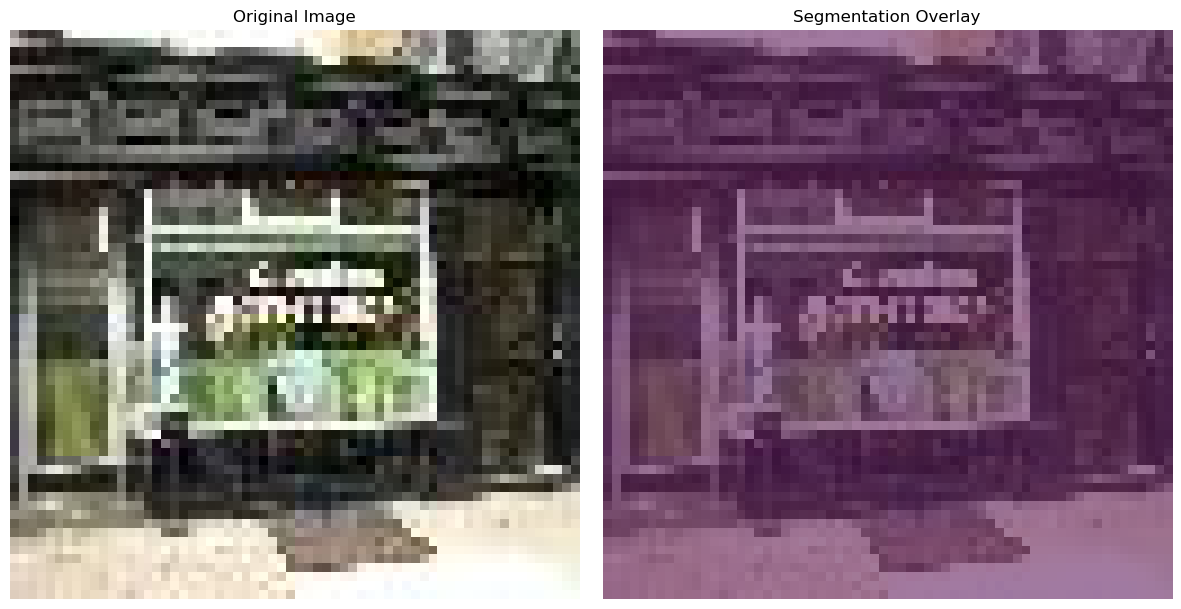

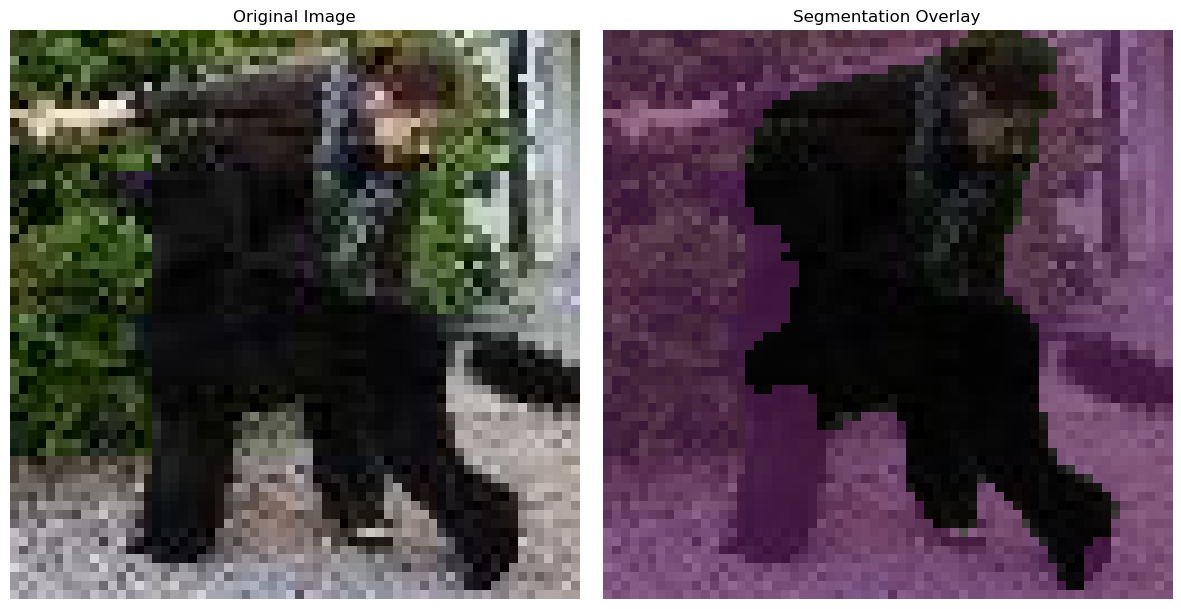

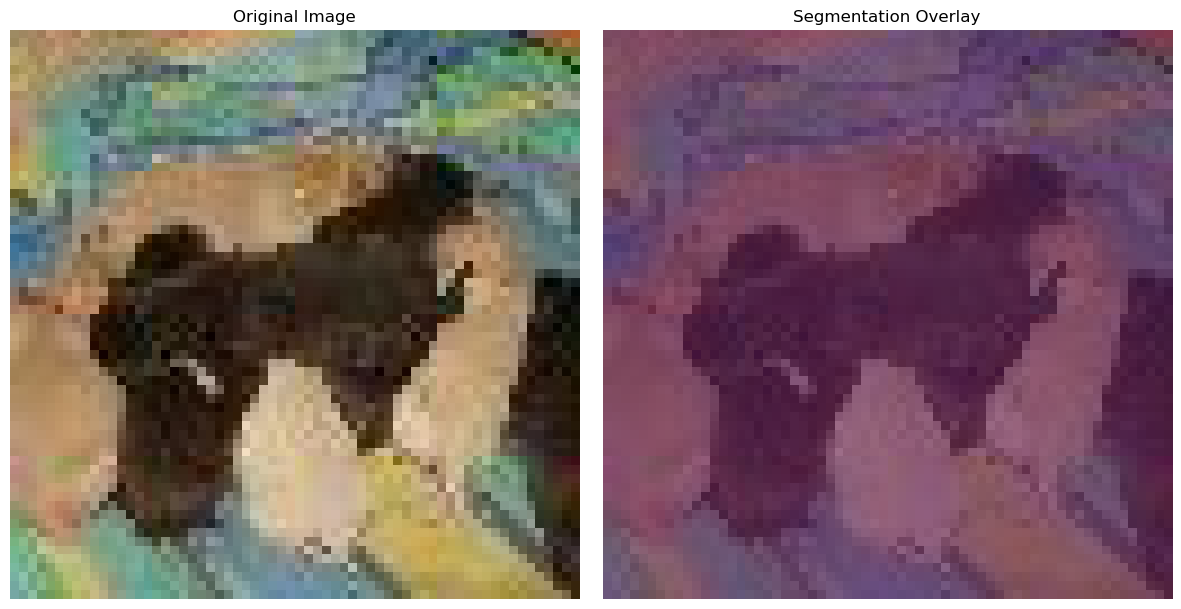

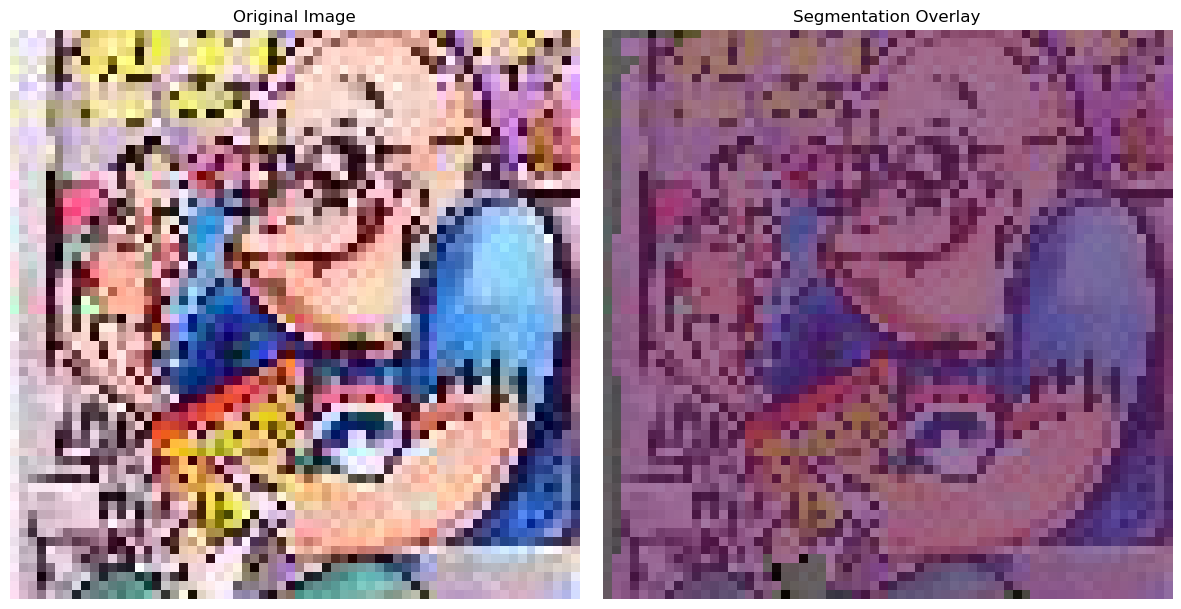

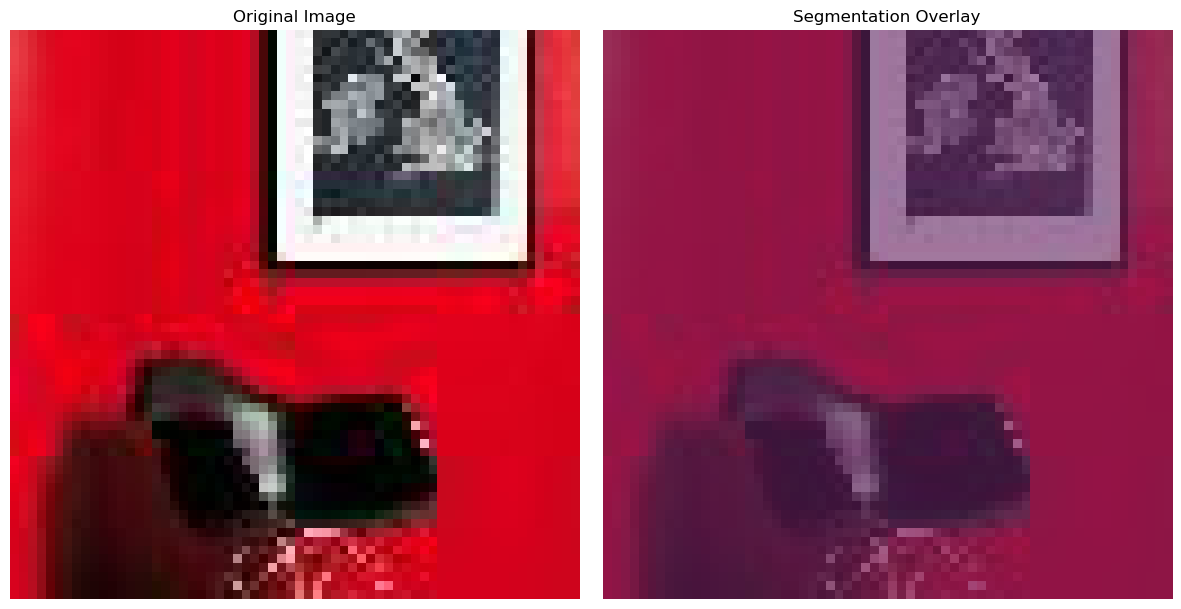

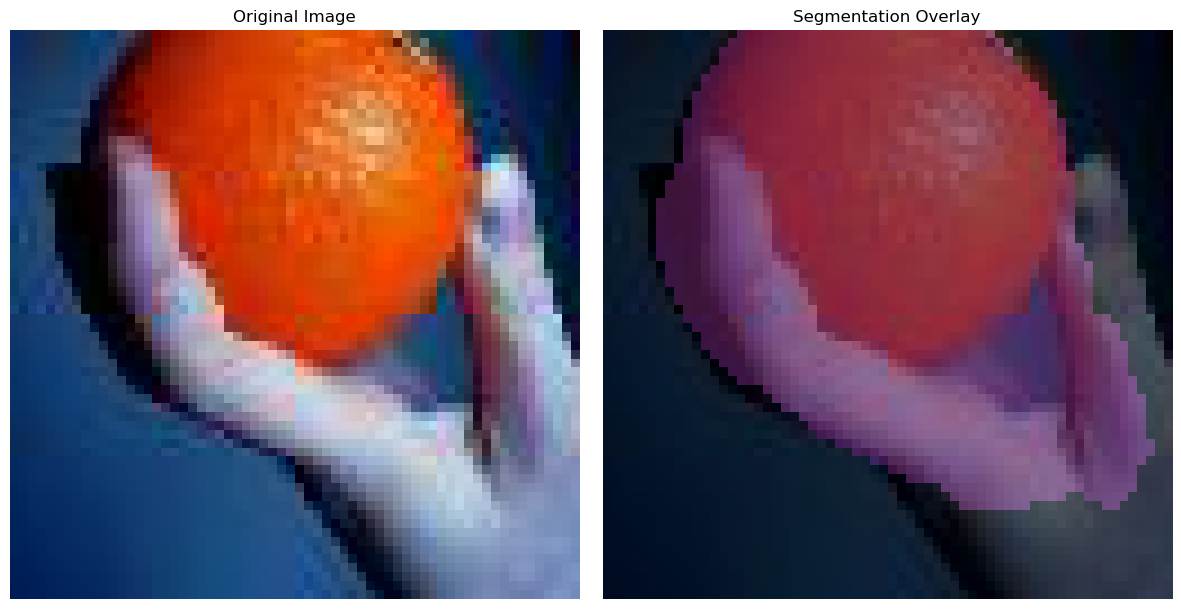

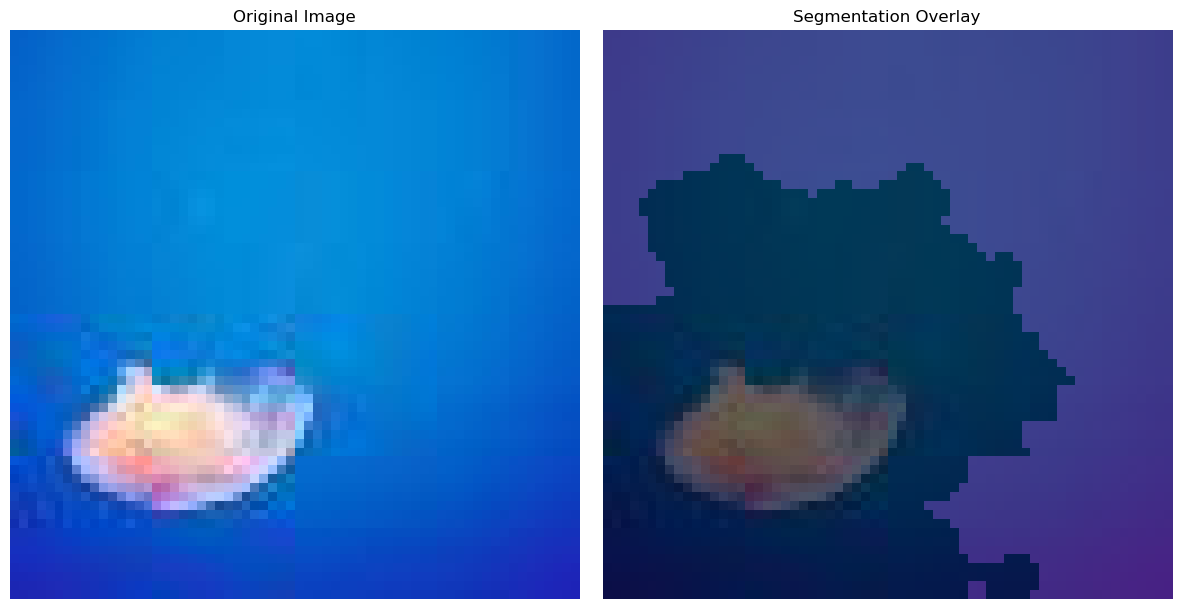

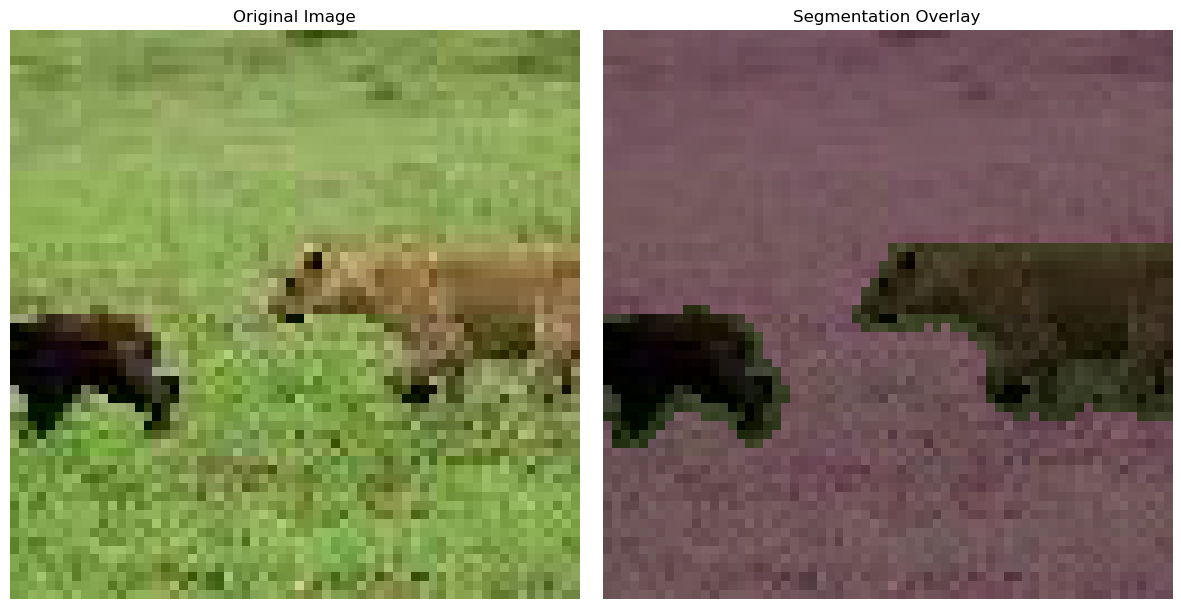

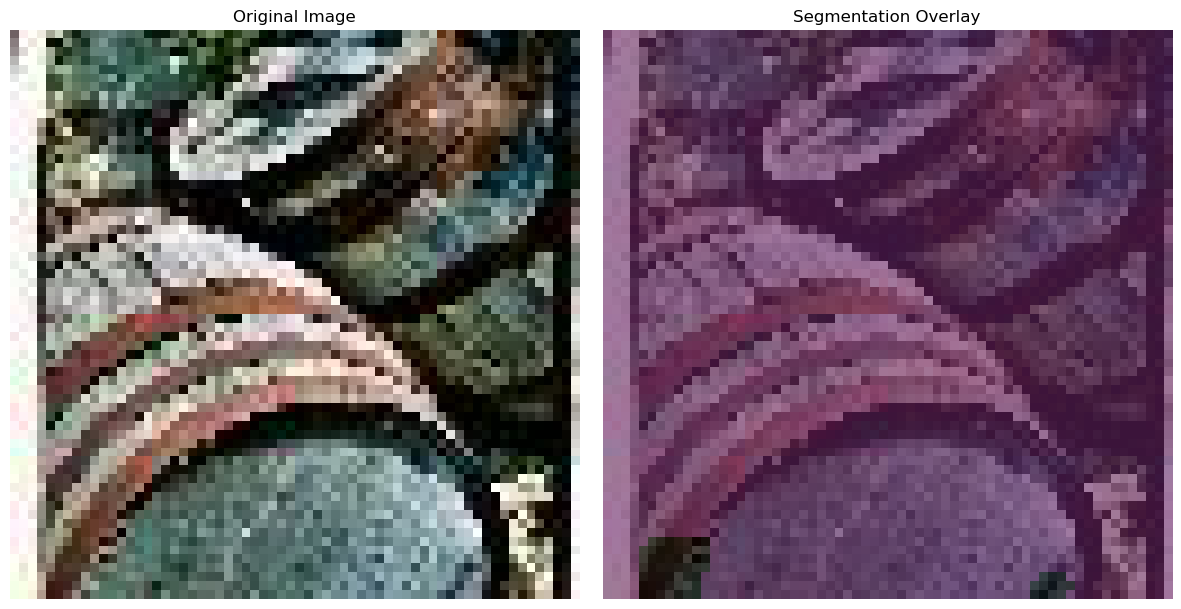

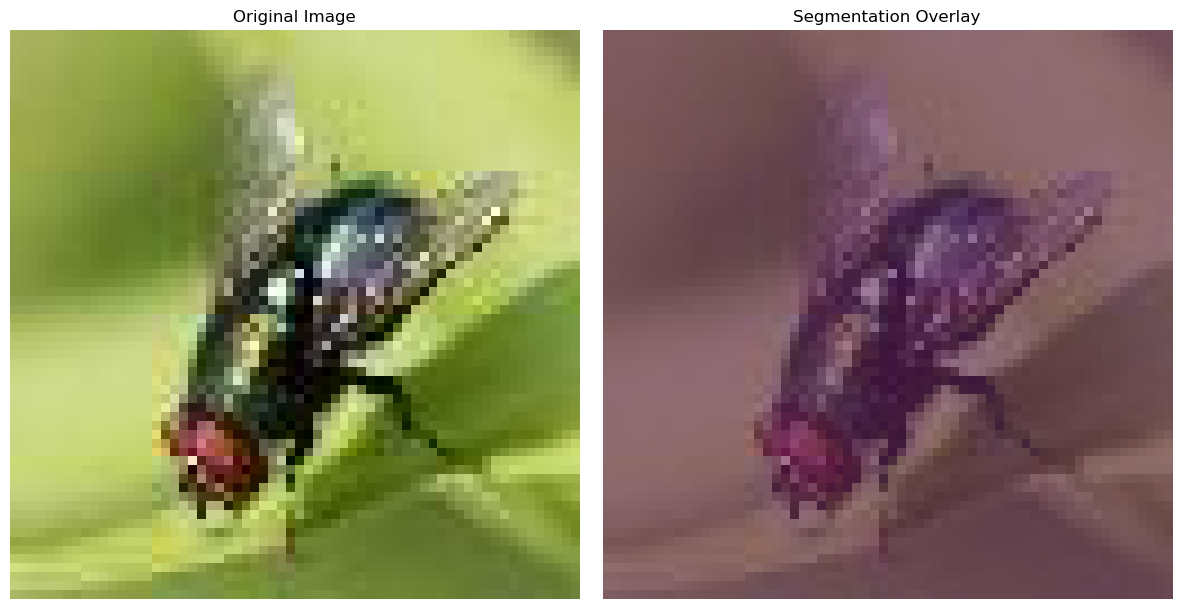

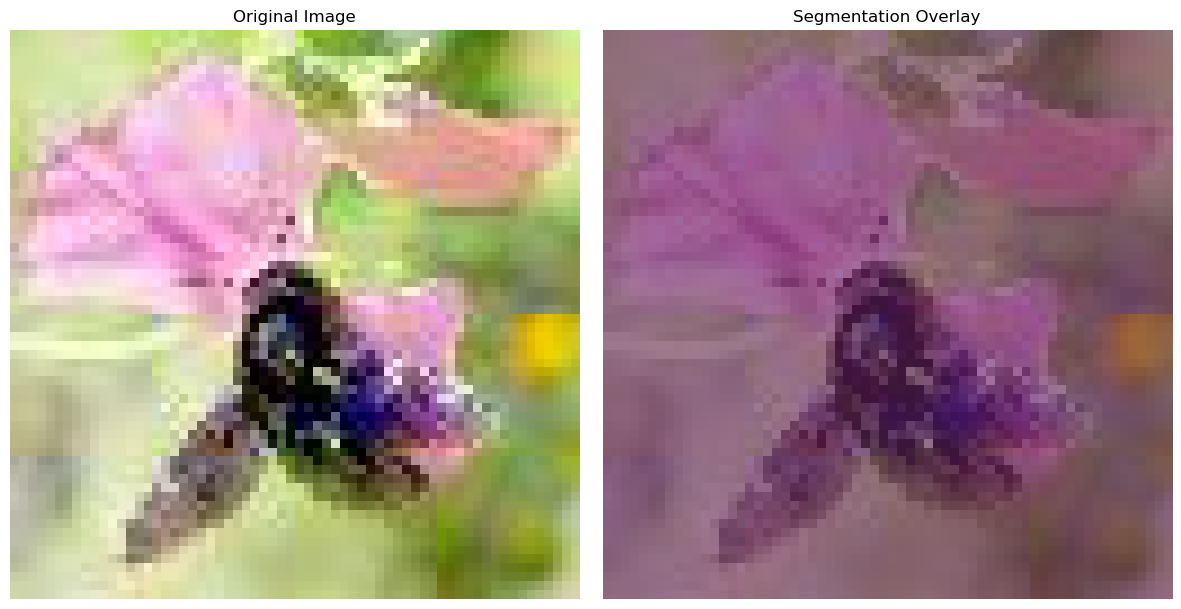

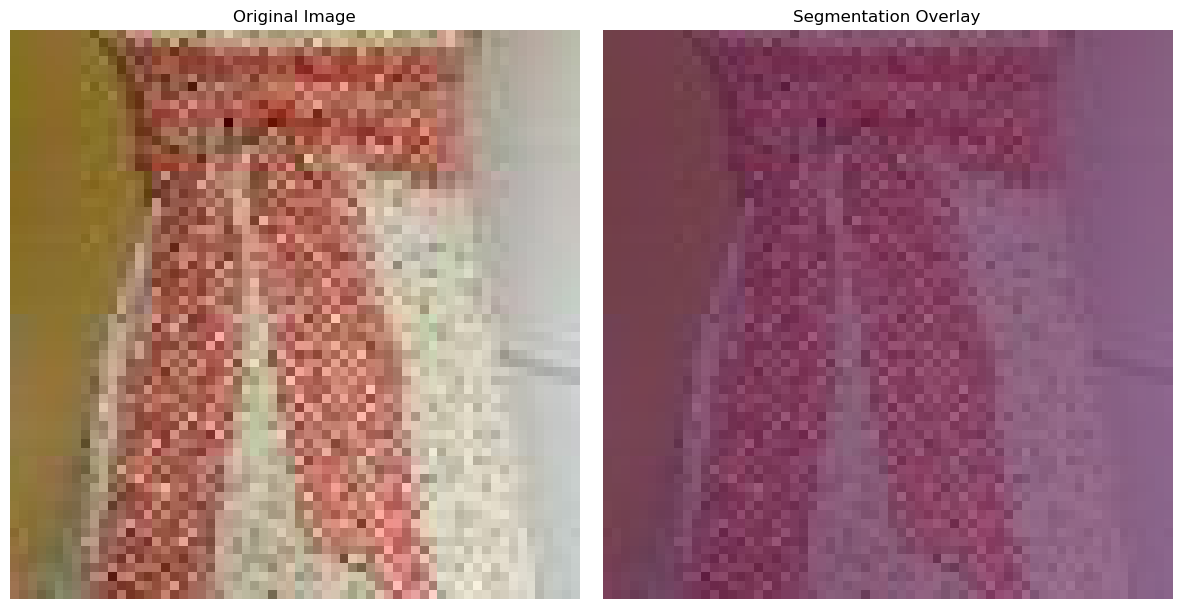

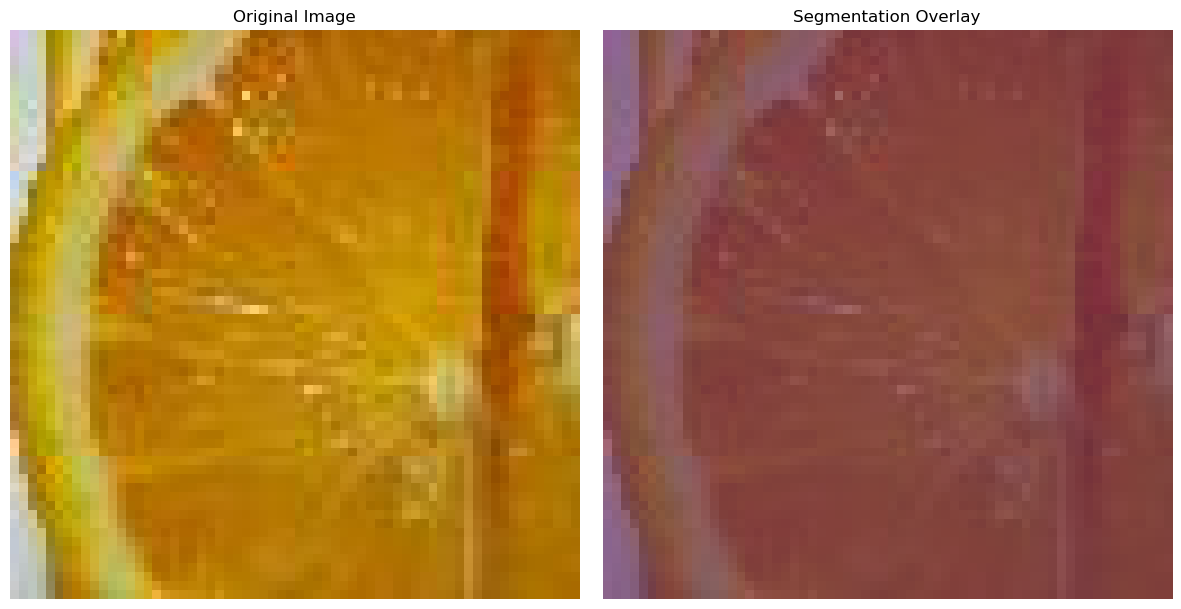

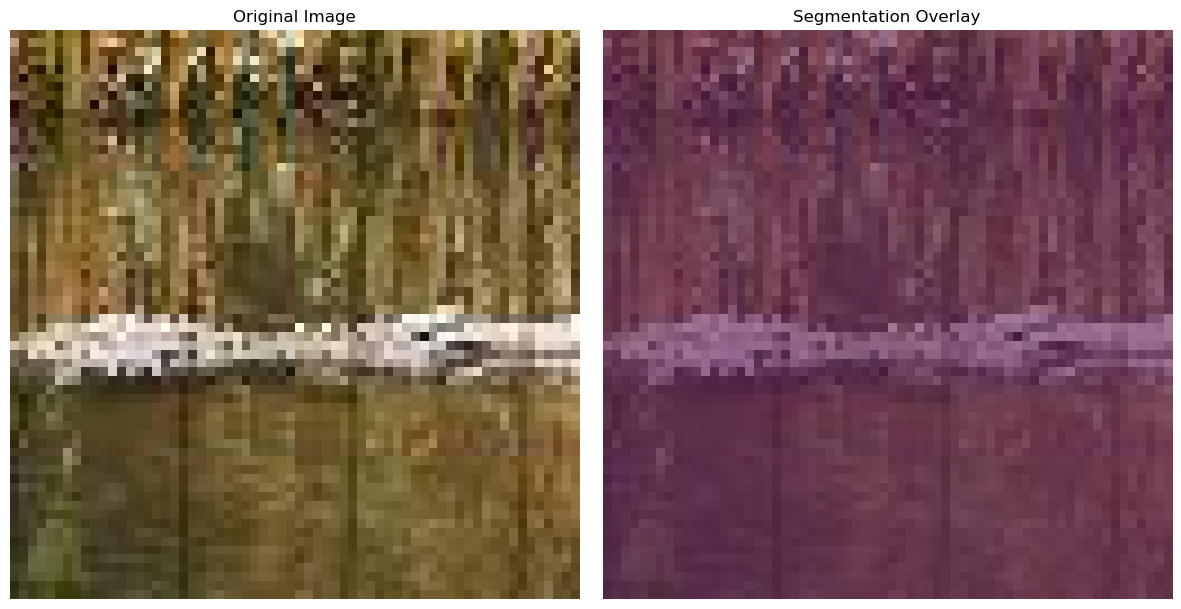

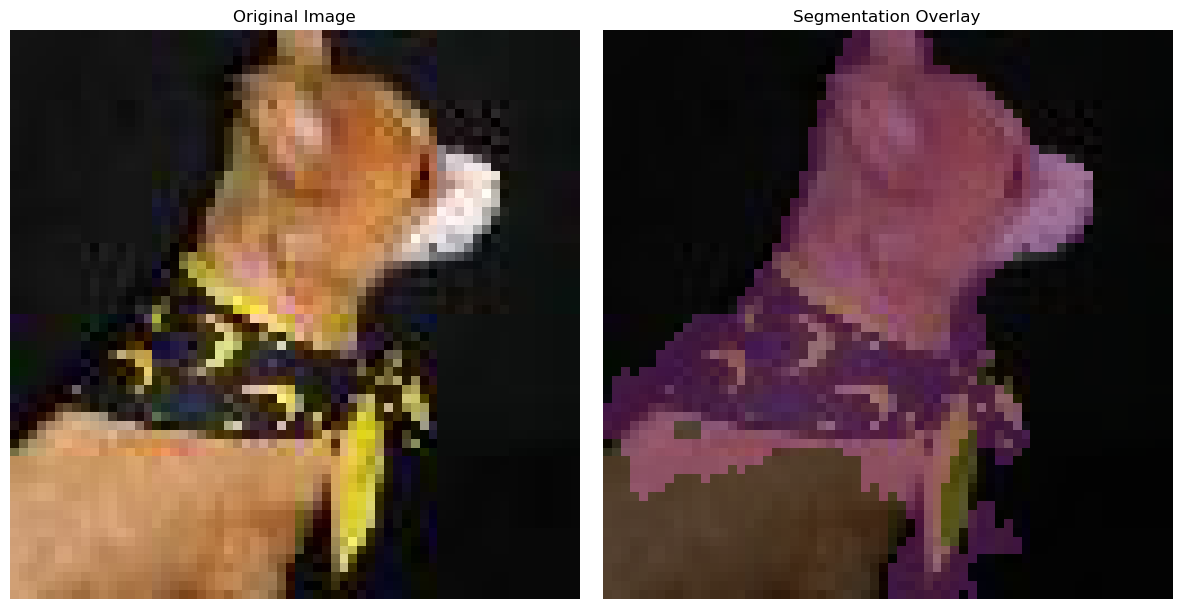

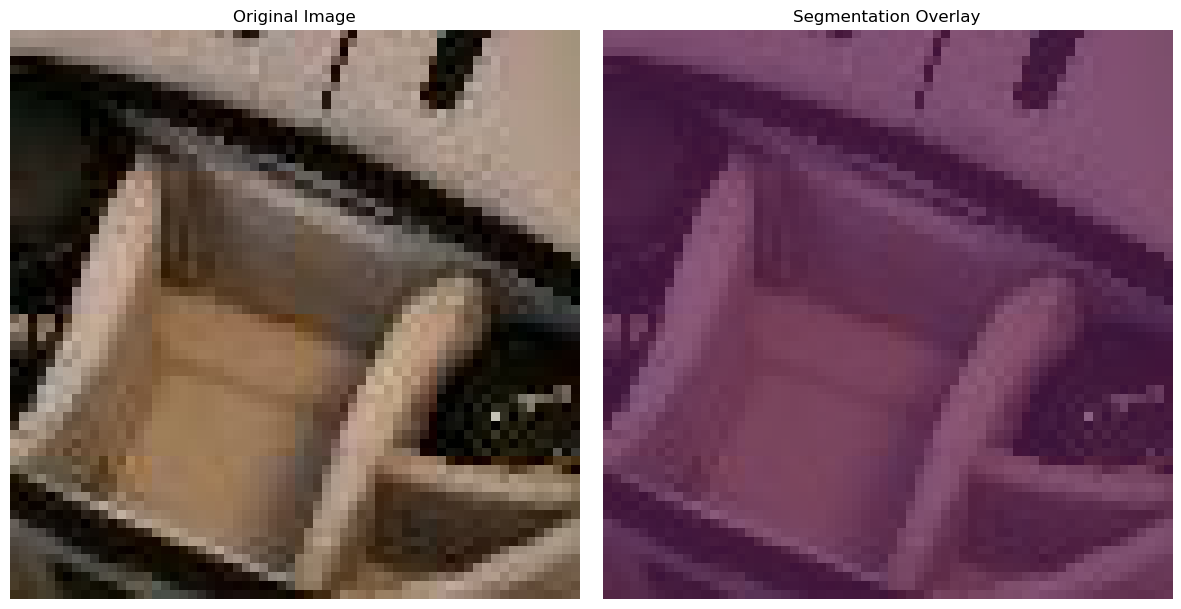

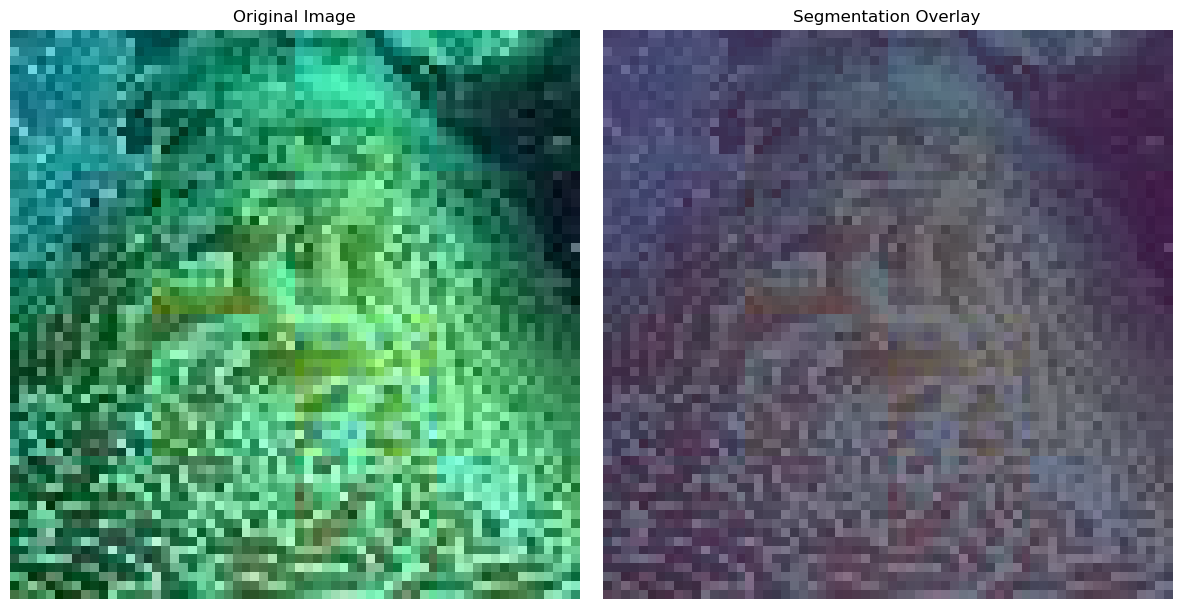

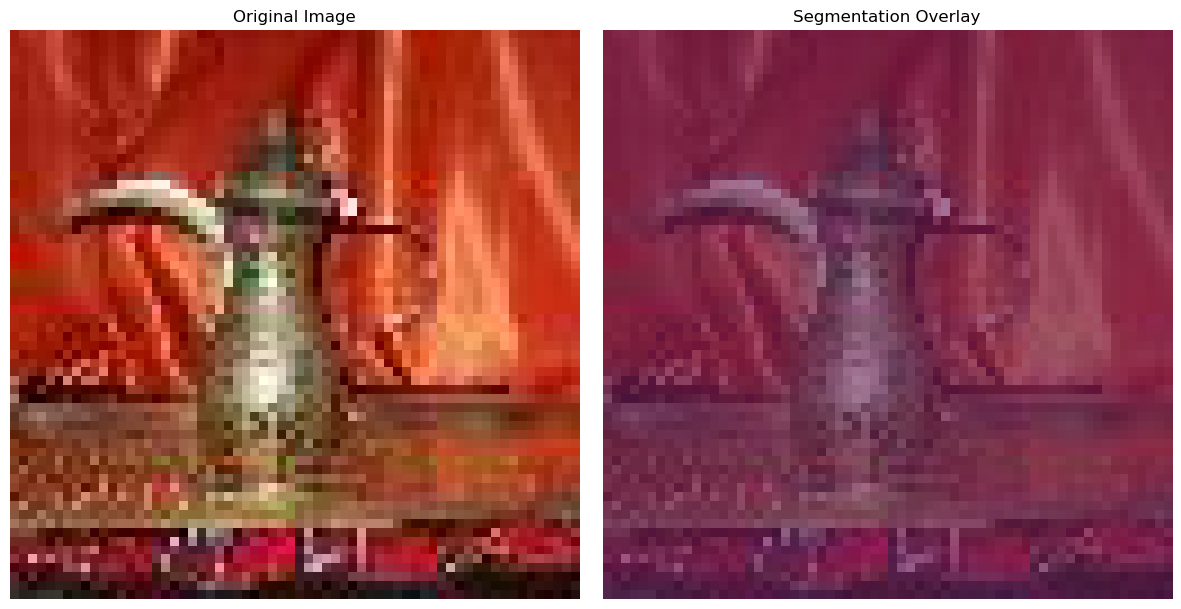

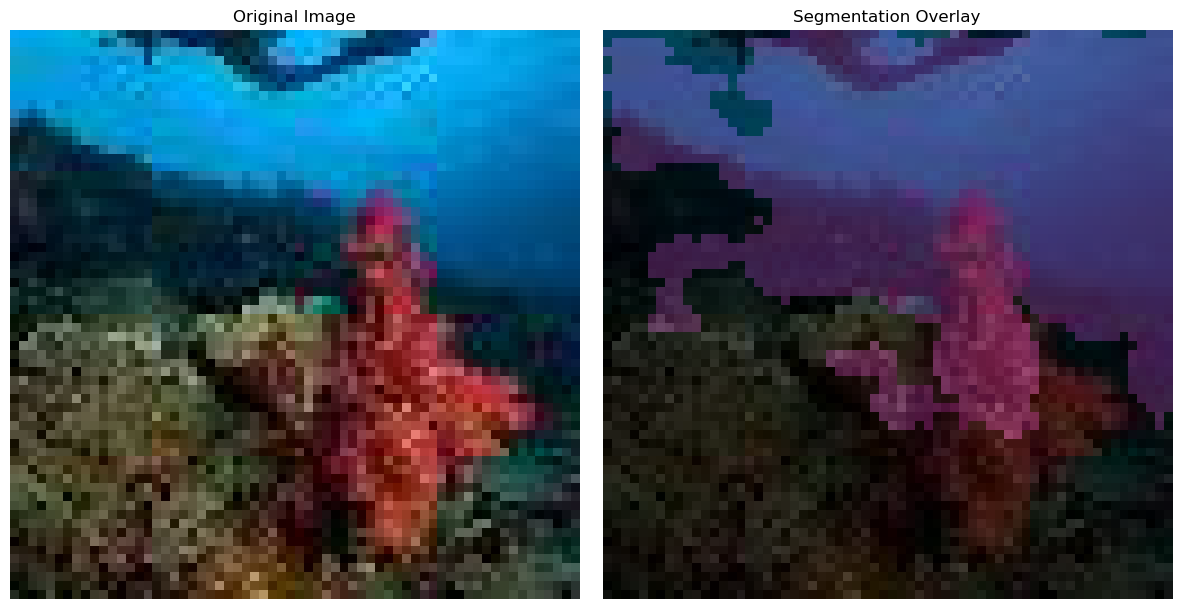

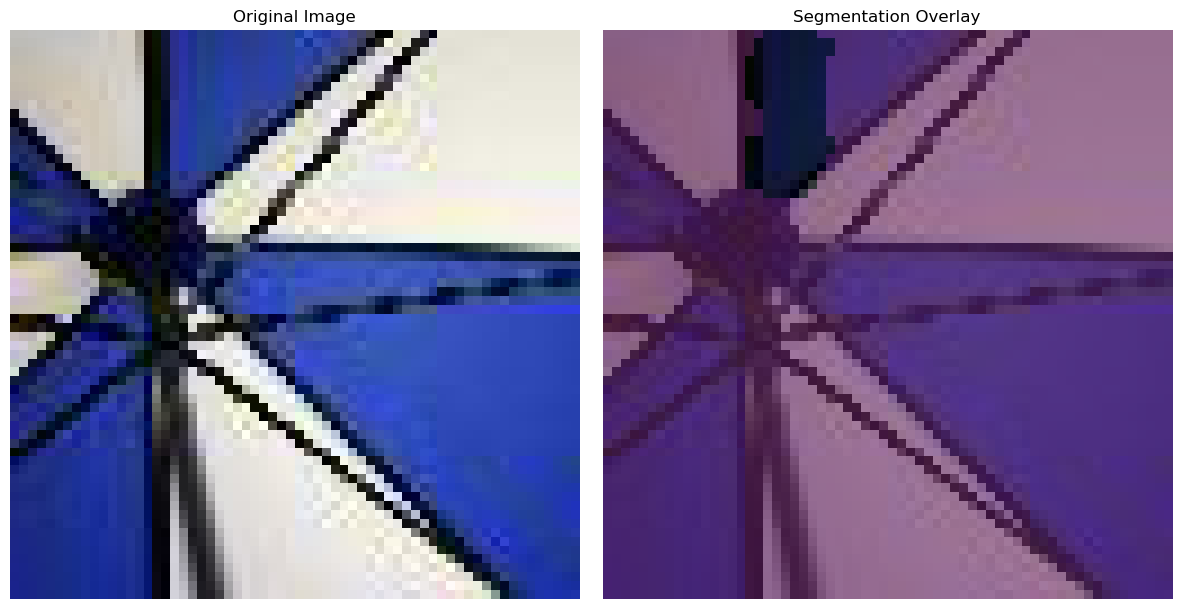

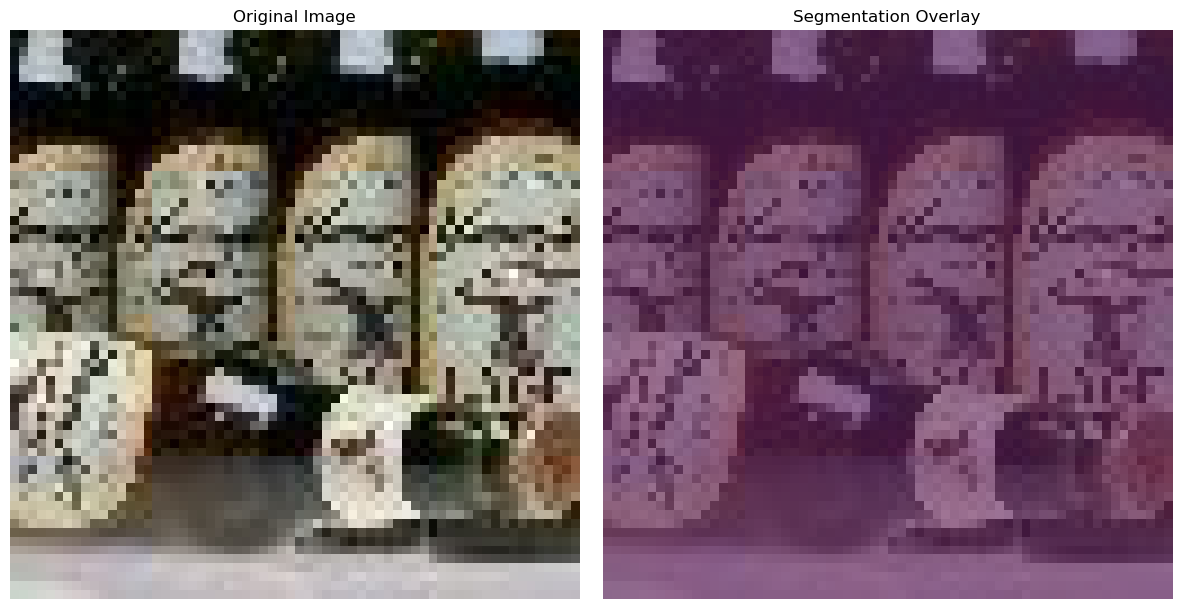

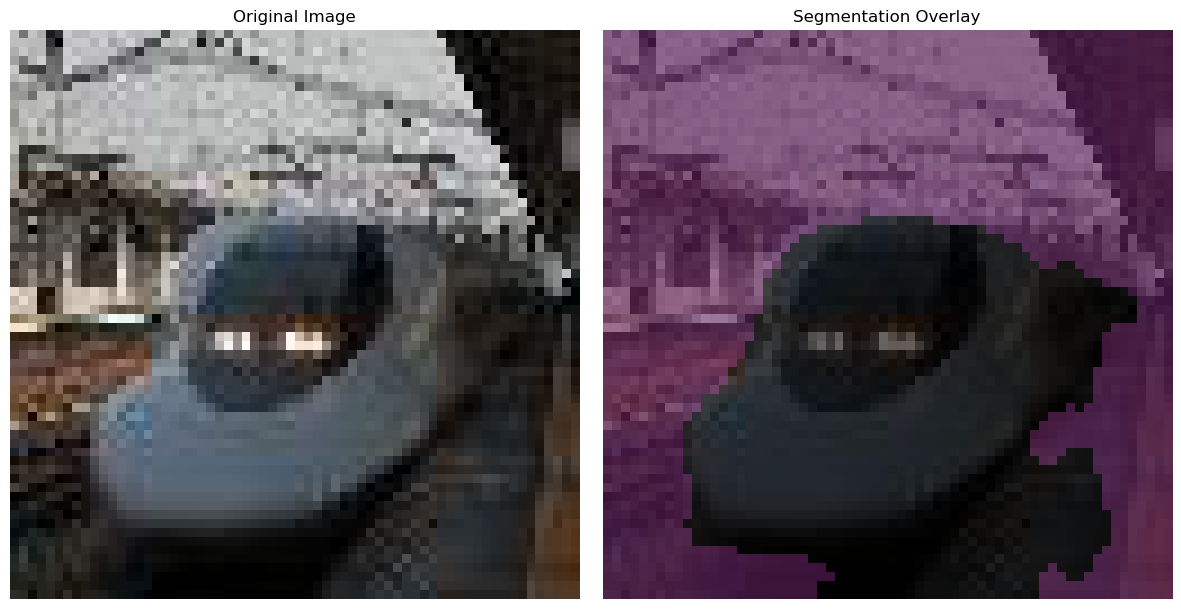

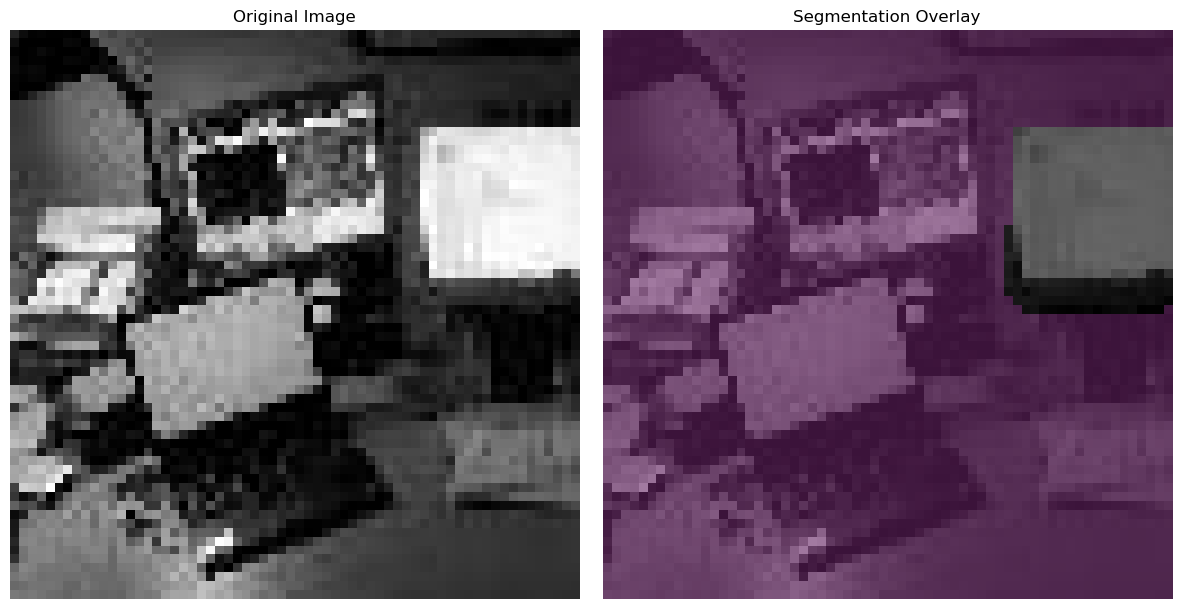

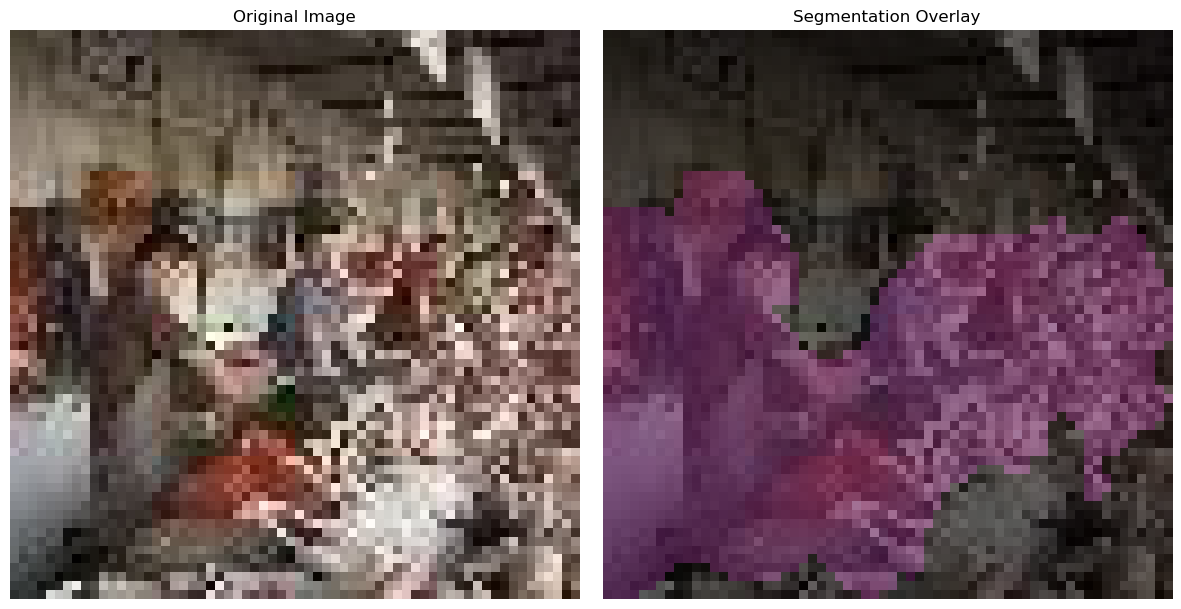

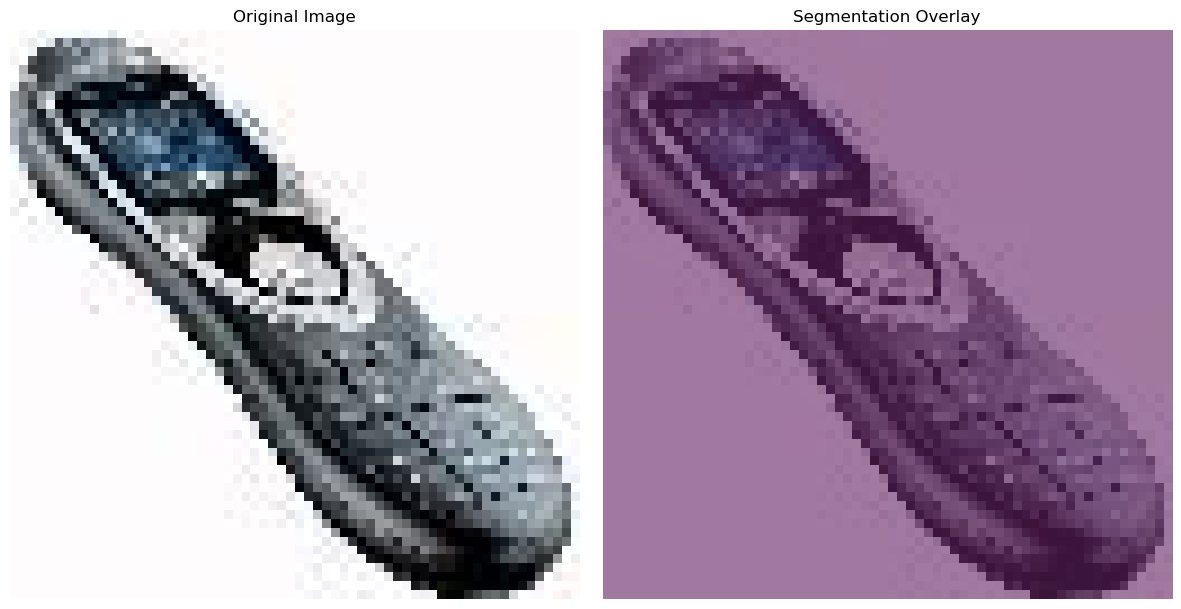

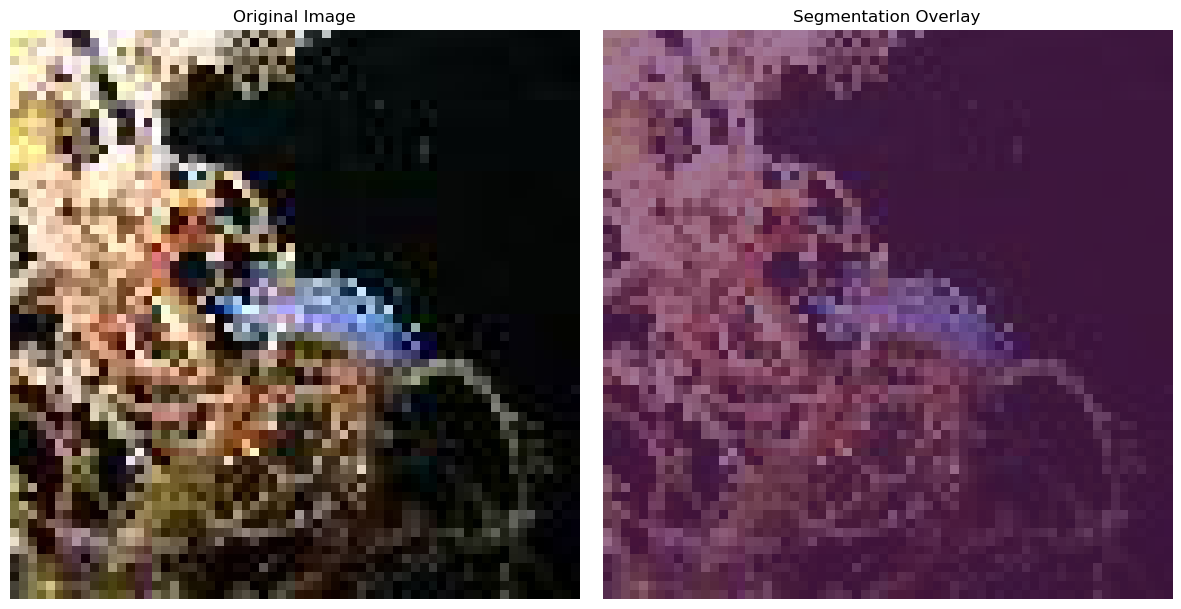

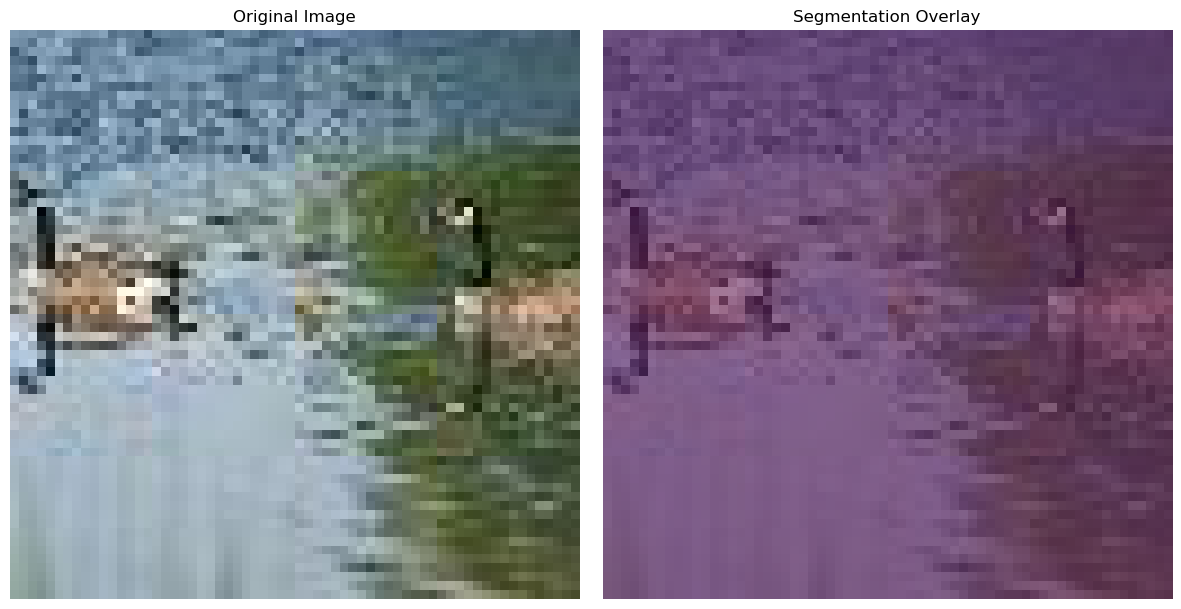

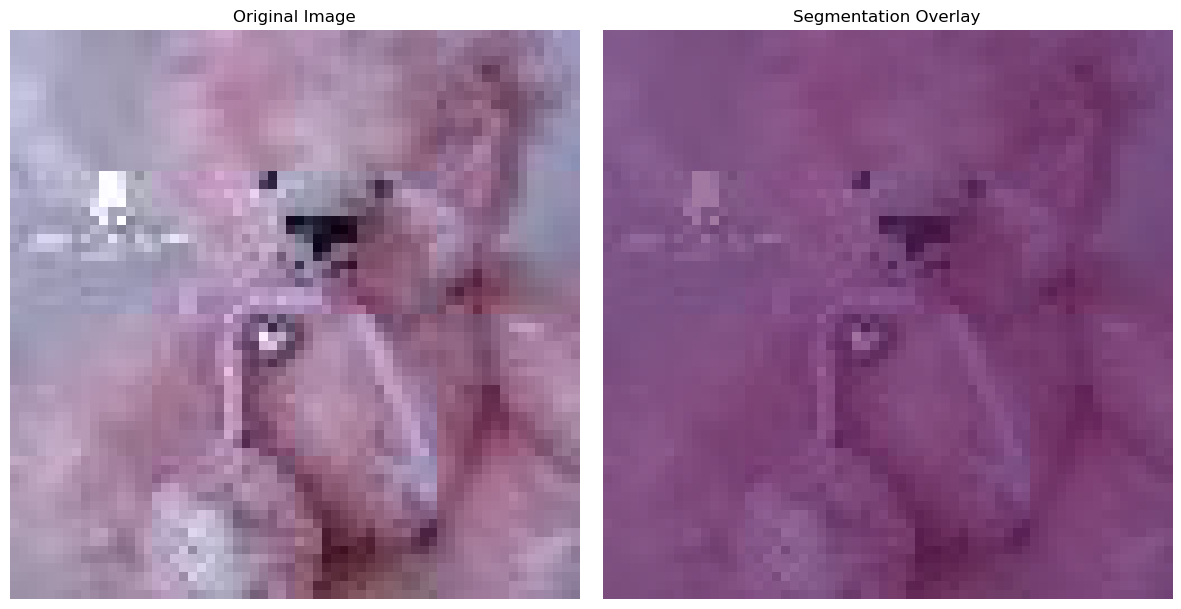

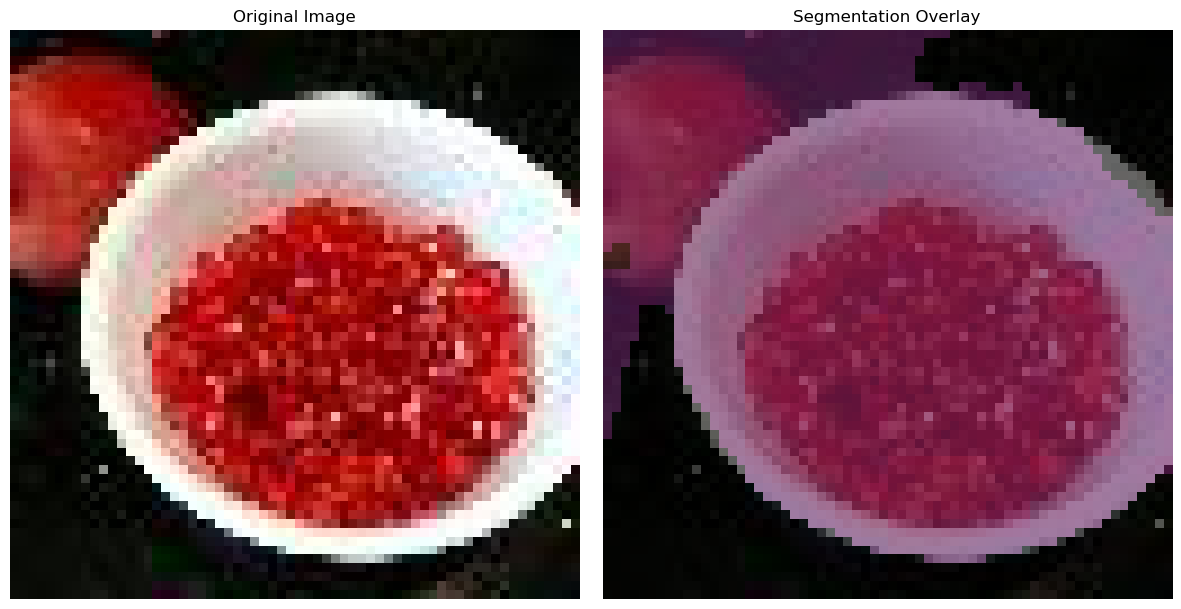

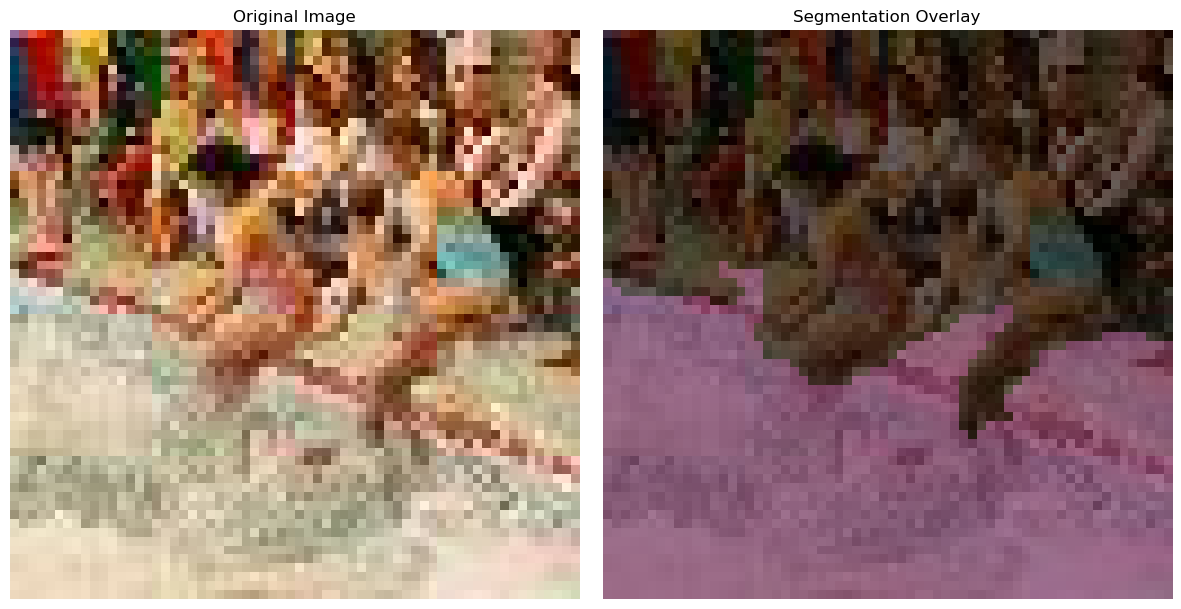

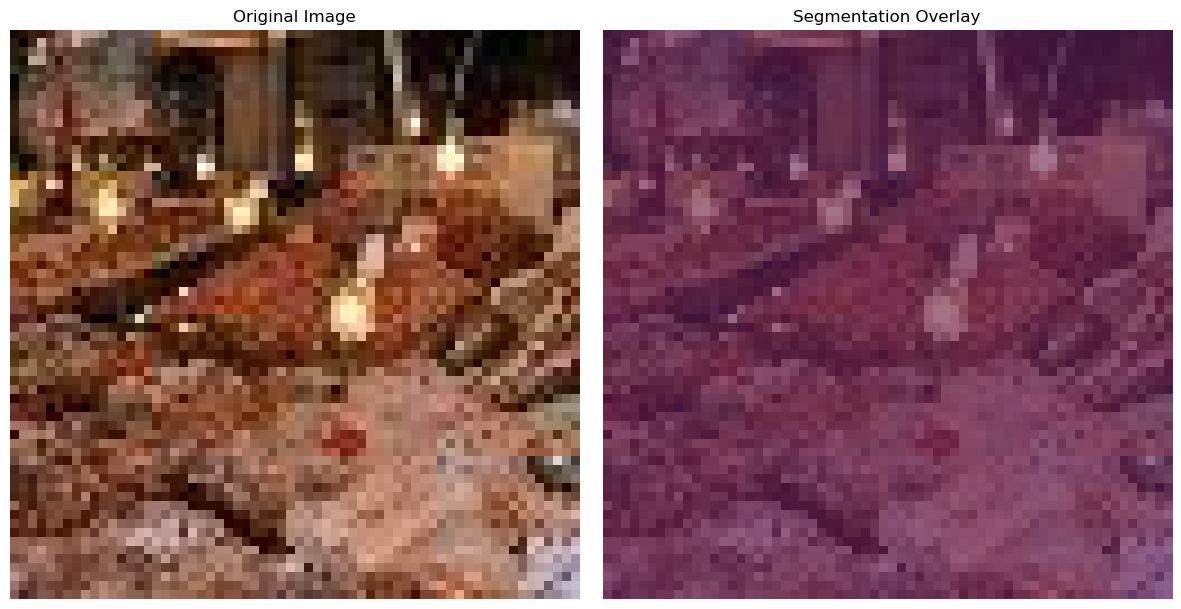

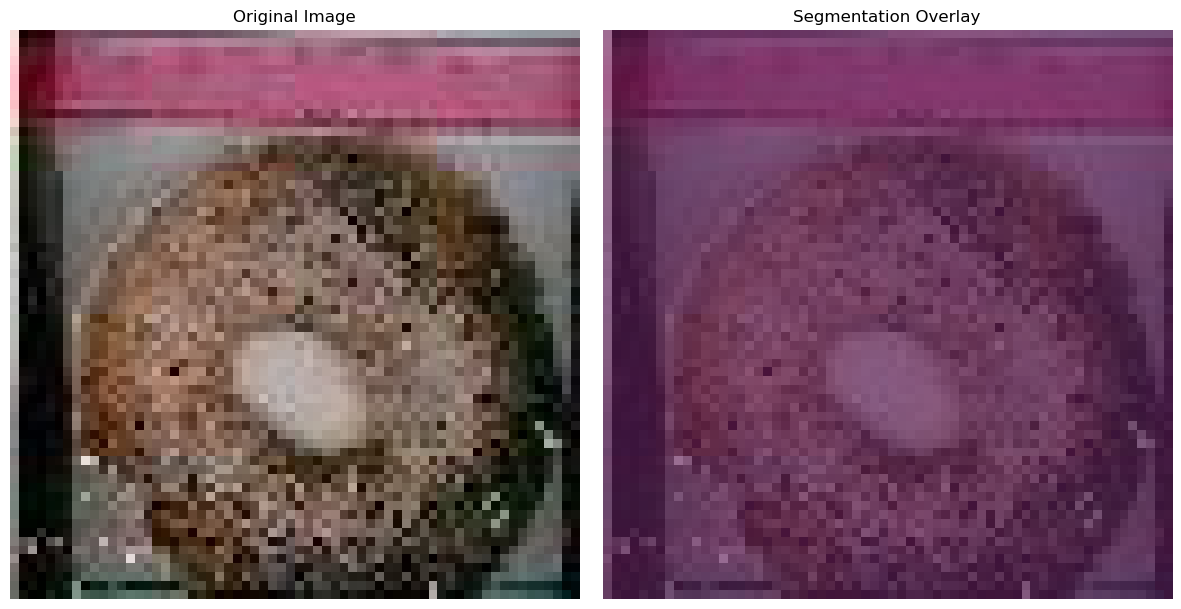

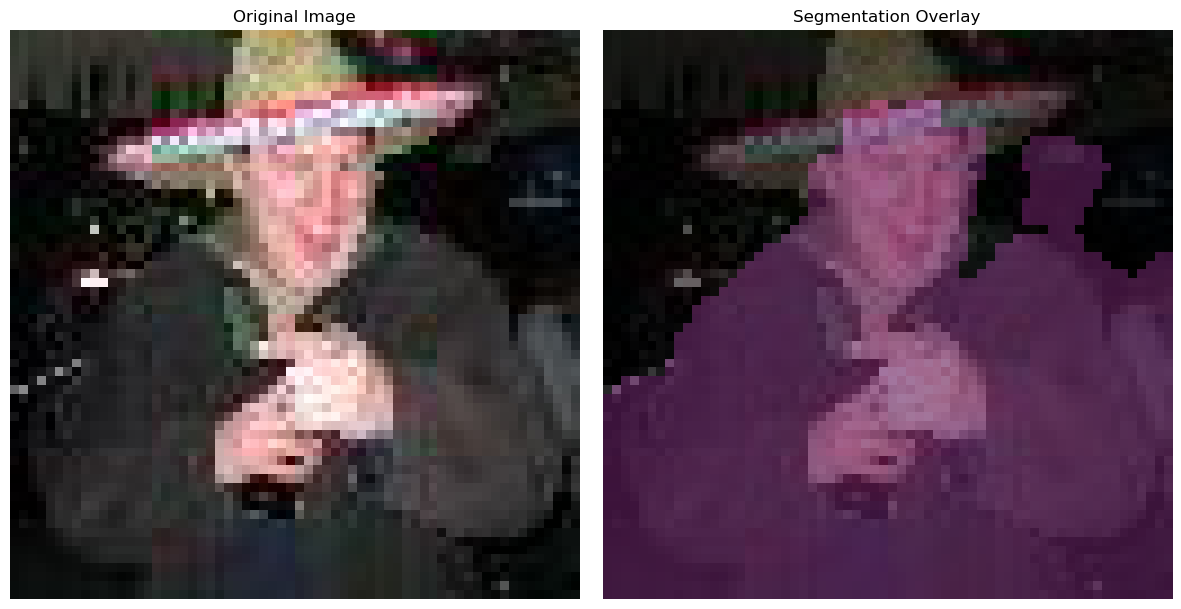

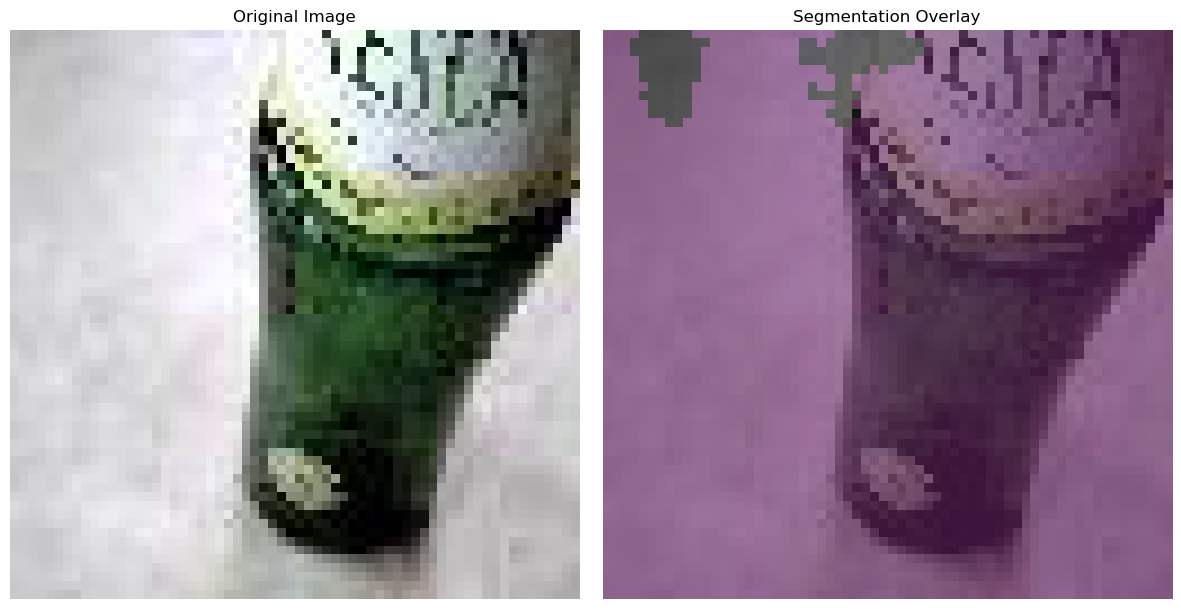

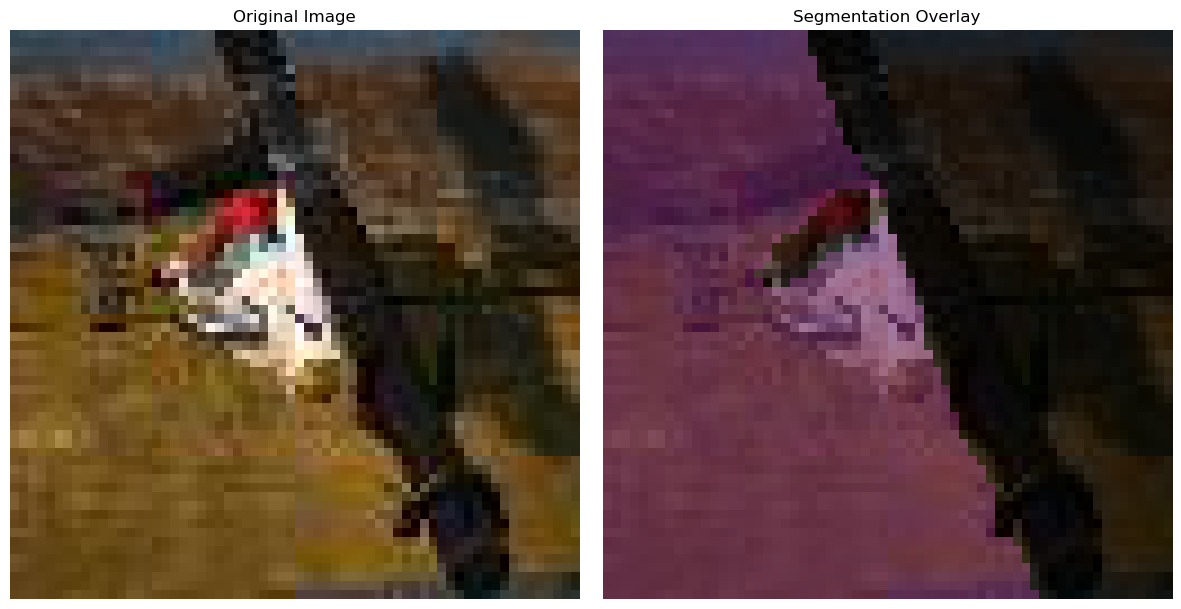

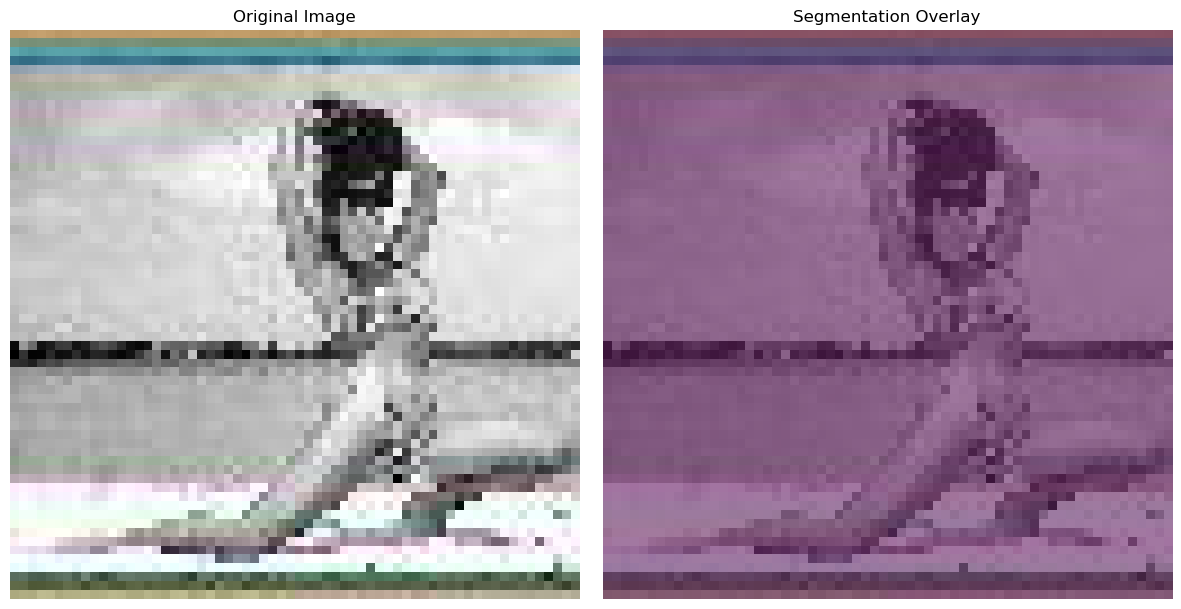

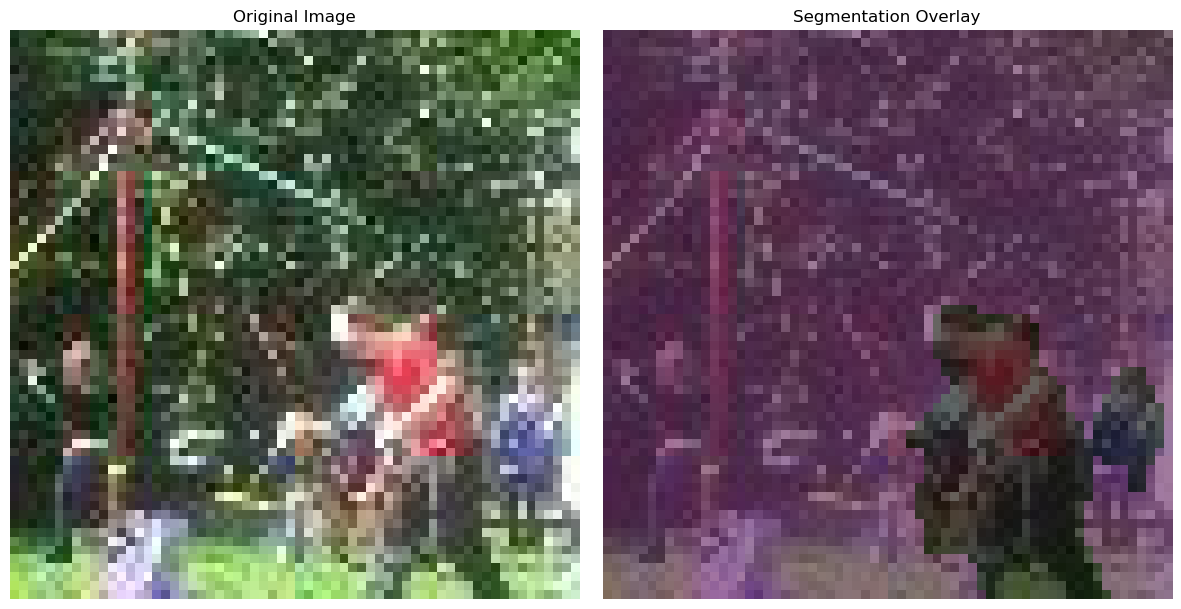

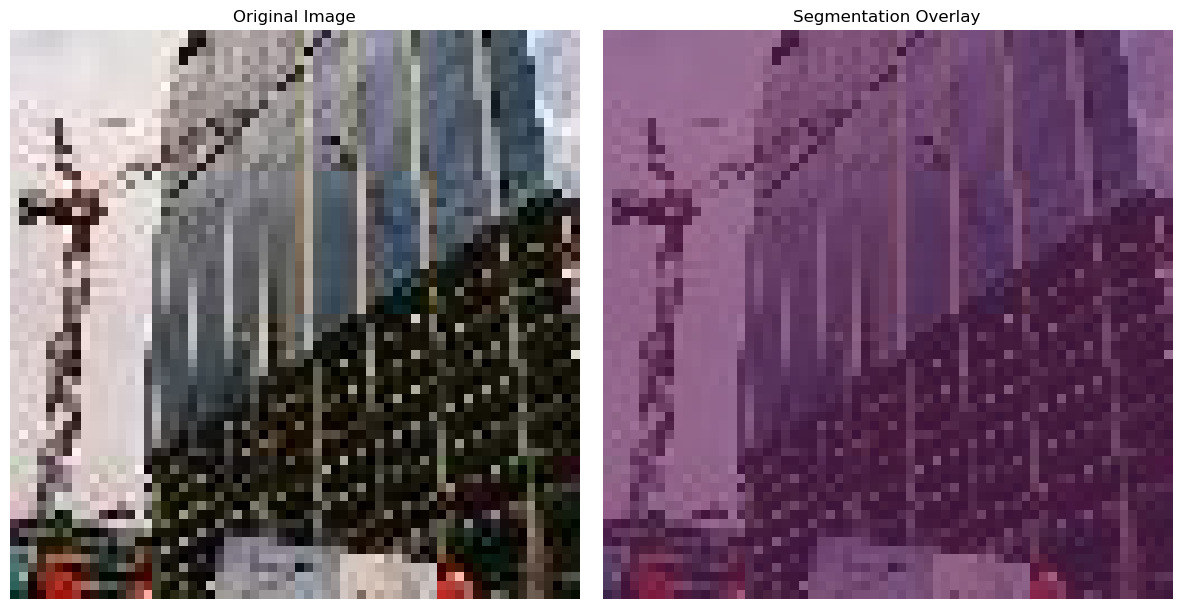

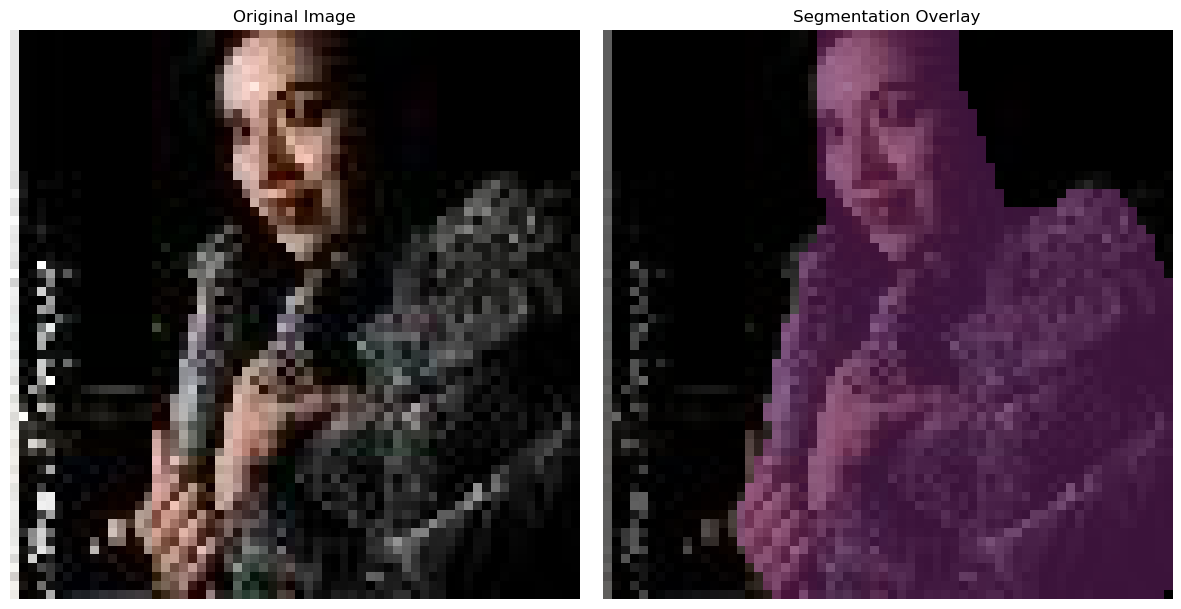

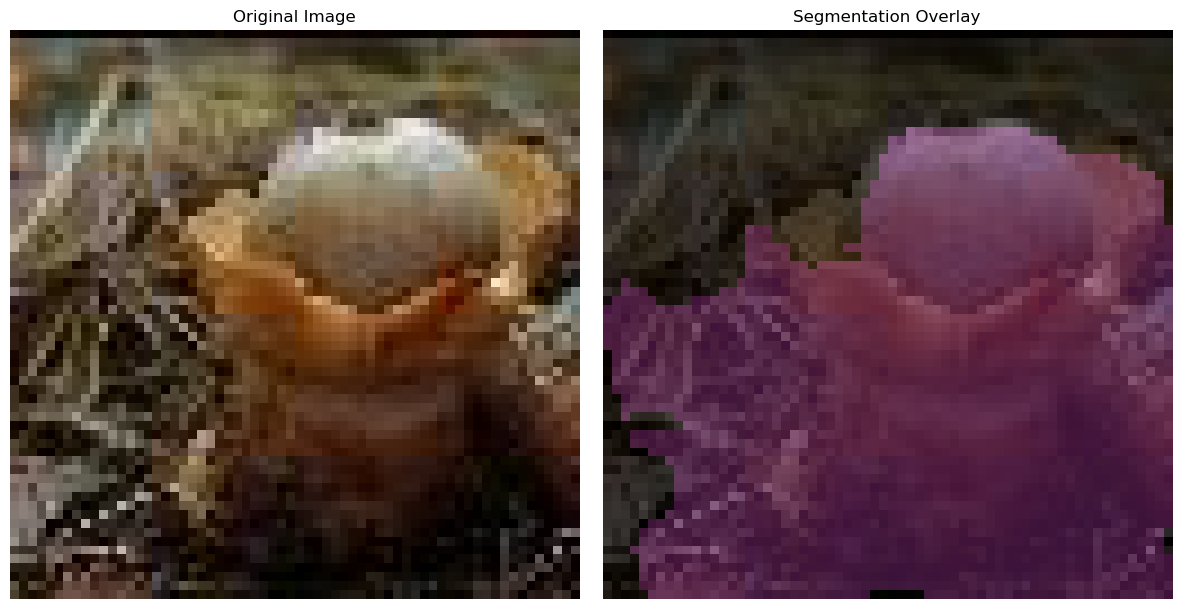

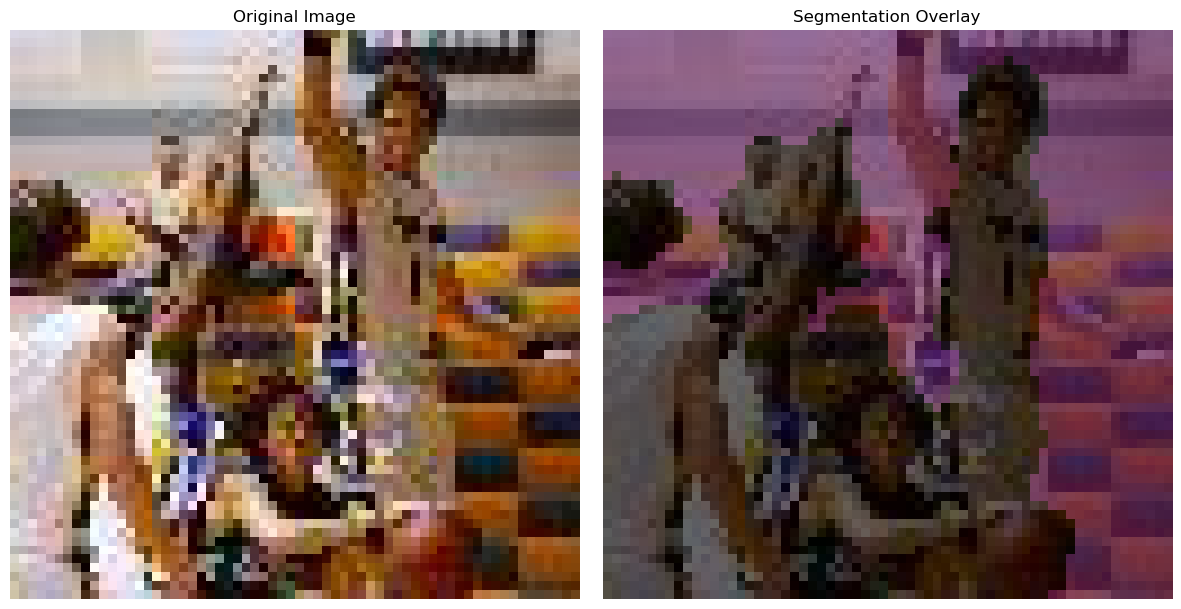

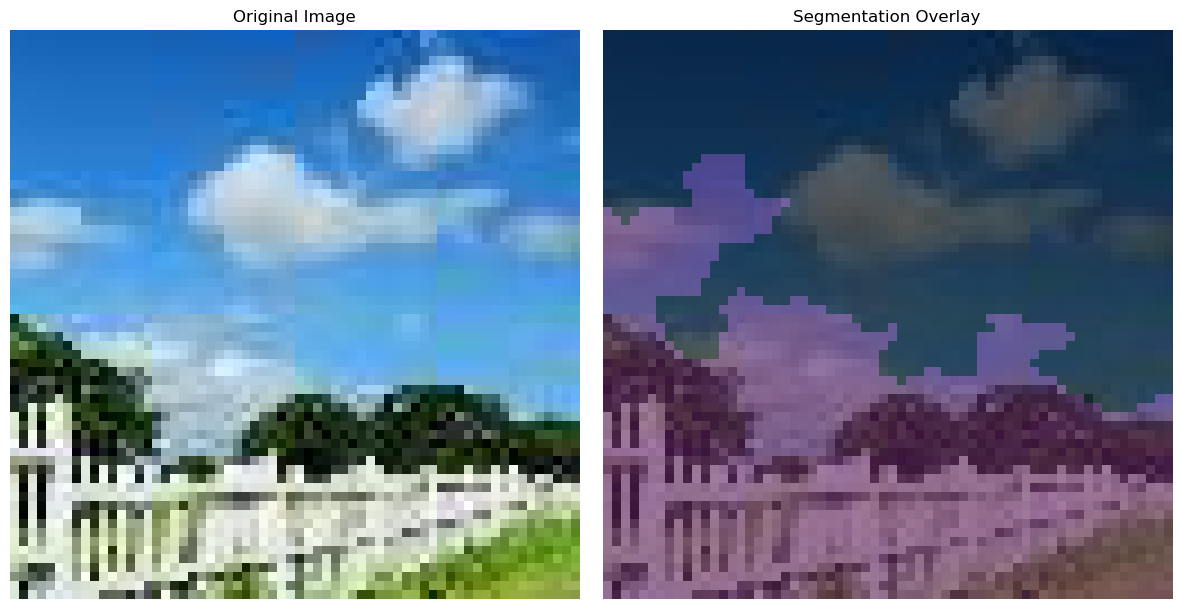

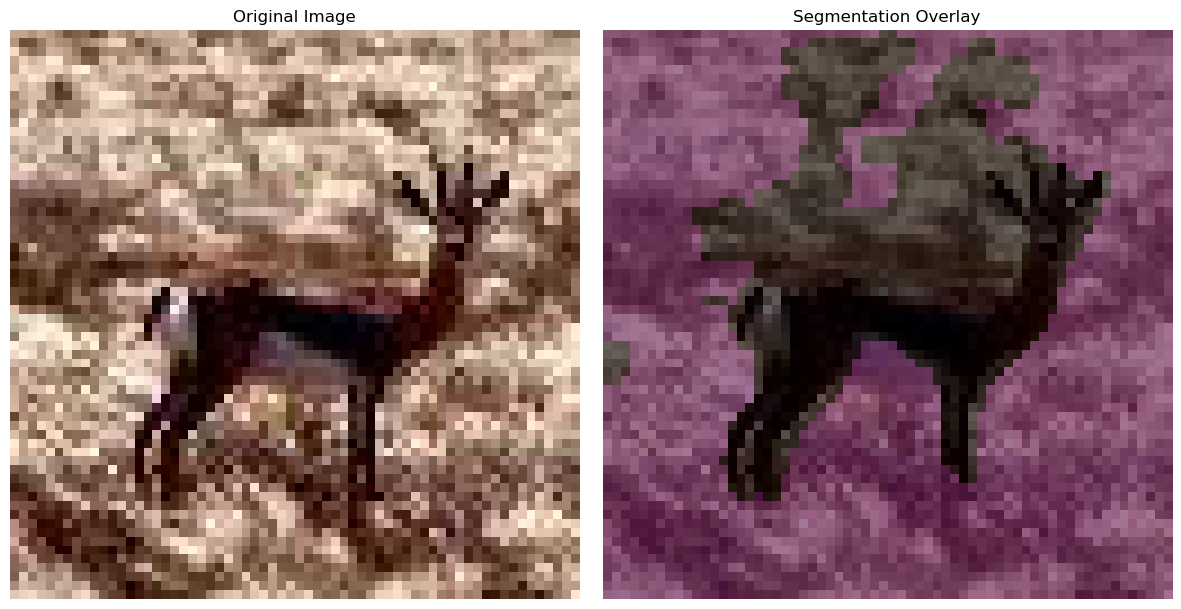

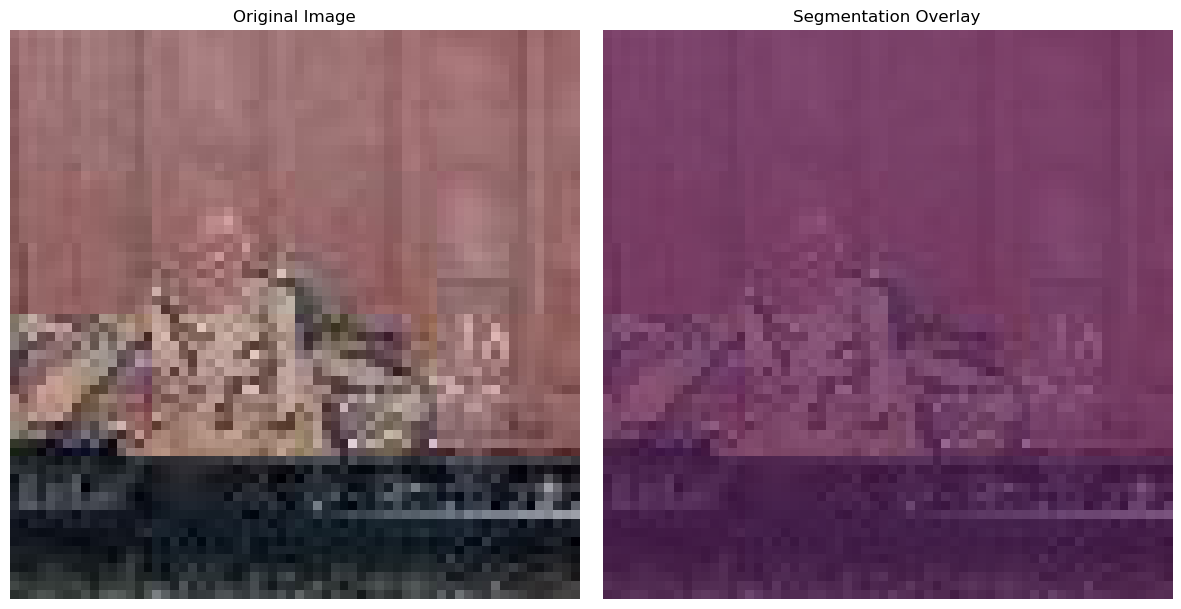

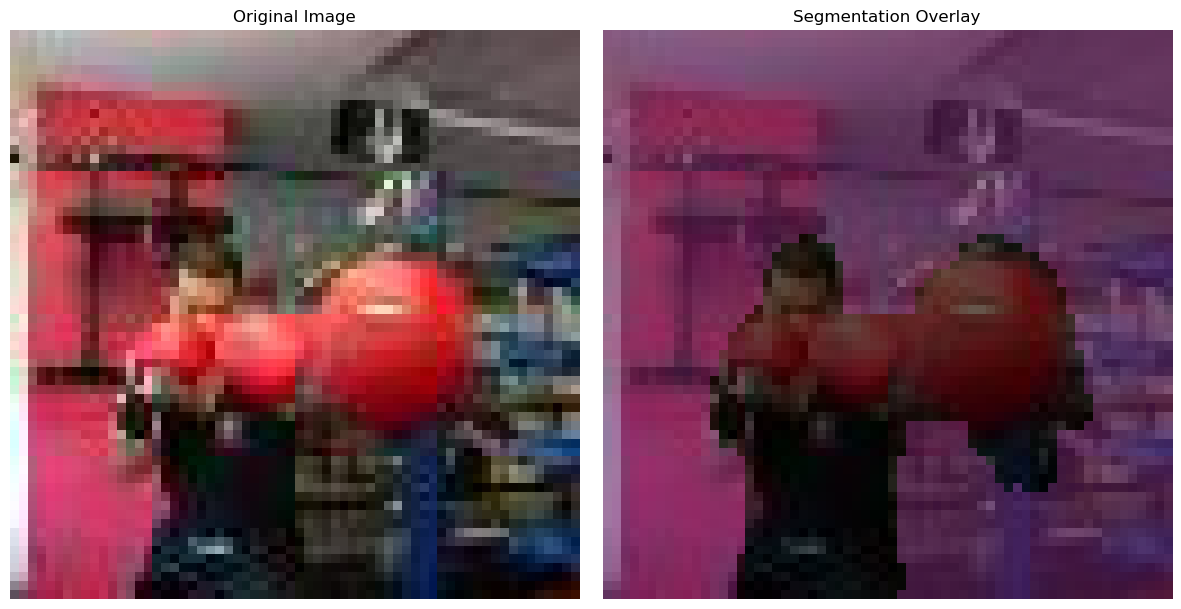

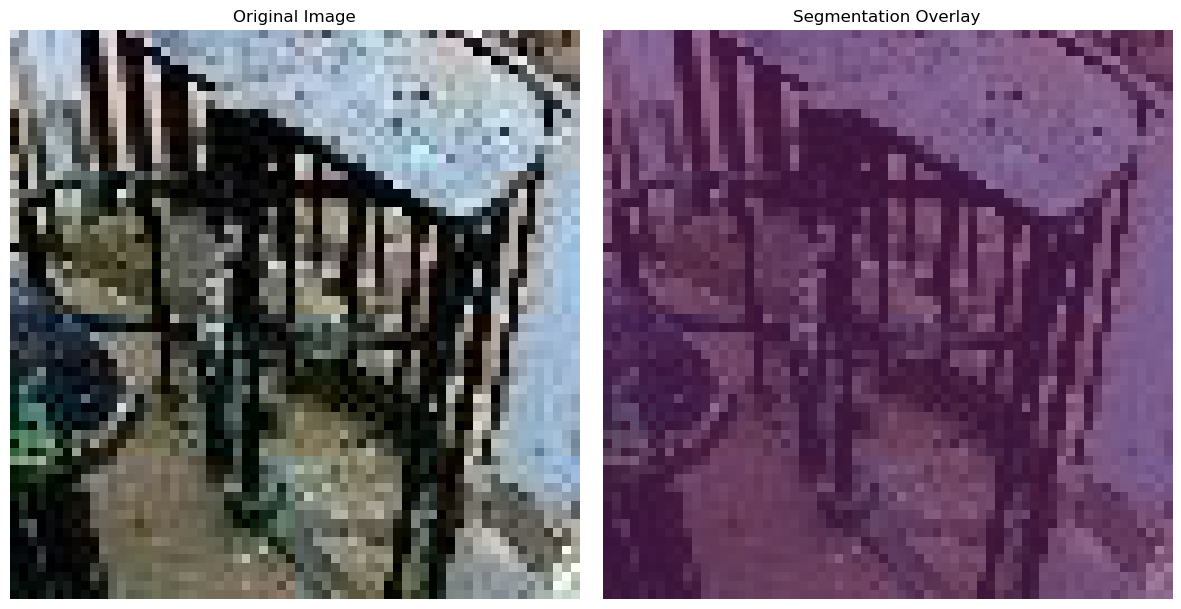

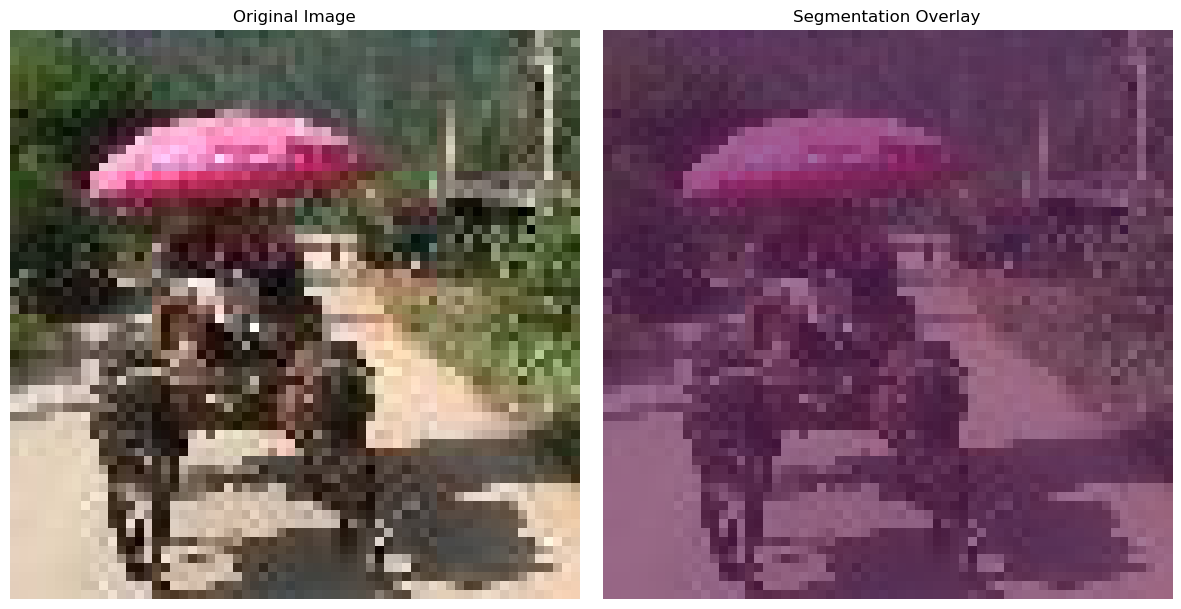

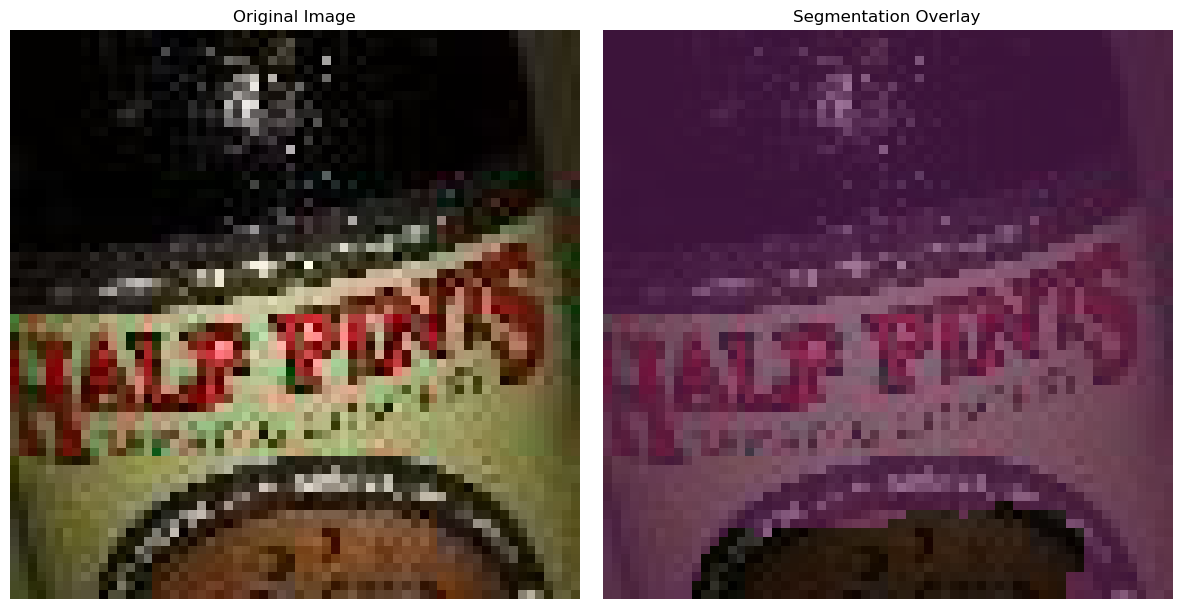

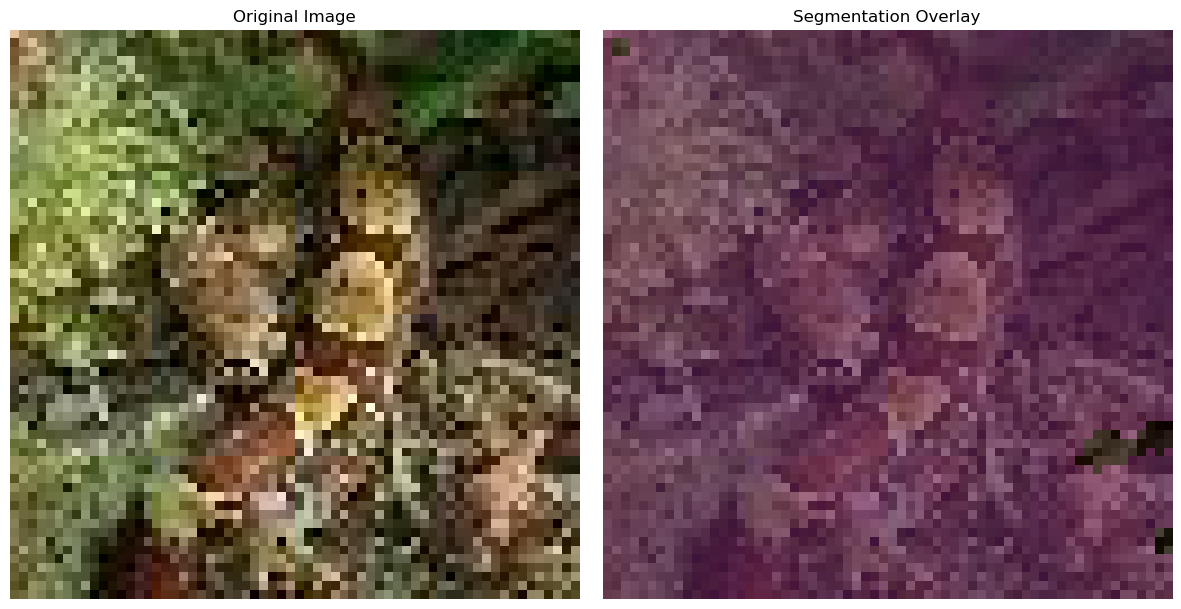

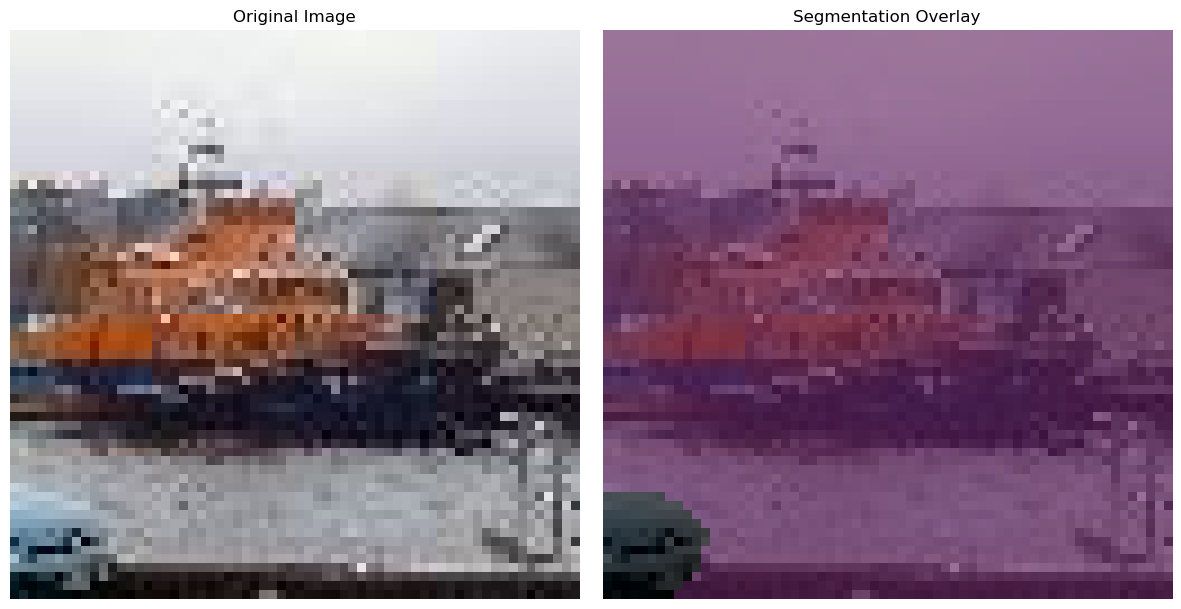

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance, ImageOps
import cv2

def get_deeplab_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model = model.to(device)
    model.eval()
    return model


def adjust_black_background(img_pil):
    img_np = np.array(img_pil)
    black_pixels = np.all(img_np == [0, 0, 0], axis=2)
    if np.mean(black_pixels) > 0.5:
        enhancer = ImageEnhance.Brightness(img_pil)
        return enhancer.enhance(2.0)
    return img_pil

seg_transform = transforms.Compose([
    transforms.Resize(520),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.Lambda(adjust_black_background),
    transforms.ColorJitter(contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class EnhancedSegmentationDataset(Dataset):
    def __init__(self, raw_dataset, transform=None):
        self.raw_dataset = raw_dataset
        self.transform = transform
        self.color_map = self._create_color_map()
        
    def __len__(self):
        return len(self.raw_dataset)
    
    def _create_color_map(self):
        cmap = np.zeros((256, 3), dtype=np.uint8)
        cmap[0] = [0, 0, 0]  # 背景黑色
        np.random.seed(42)
        cmap[1:] = np.random.randint(25, 256, (255, 3))  # 前景颜色
        return cmap
    
    def _postprocess_mask(self, mask):
        """处理多类别标签并优化边界"""
     
        binary_mask = np.where(mask > 0, 255, 0).astype(np.uint8)
        
    
        binary_mask = cv2.GaussianBlur(binary_mask, (5,5), 0)
        
     
        thresh = cv2.adaptiveThreshold(
            binary_mask, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        
     
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
 
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            filled_mask = np.zeros_like(binary_mask)
            cv2.drawContours(filled_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
            return filled_mask
        return binary_mask
    
    def __getitem__(self, idx):
        img_pil, label = self.raw_dataset[idx]
        original_size = img_pil.size
        

        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)
        
  
        with torch.no_grad():
            input_tensor = img_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        

        final_mask = self._postprocess_mask(mask)
        final_mask = cv2.resize(final_mask, original_size, interpolation=cv2.INTER_NEAREST)
        
   
        colored_mask = self.color_map[final_mask]
        return img_pil, colored_mask, label


def visualize_segmentation(original, mask, alpha=0.6):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(original)
    plt.imshow(mask, alpha=alpha)
    plt.title("Segmentation Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = get_deeplab_model()

    raw_testset = torchvision.datasets.ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/train',  
        transform=None
    )
    seg_testset = EnhancedSegmentationDataset(raw_testset, seg_transform)

    num_samples = 50
    indices = np.random.choice(len(seg_testset), num_samples, replace=False)
    
    for i in indices:
        img, mask, label = seg_testset[i]
        visualize_segmentation(np.array(img), mask)

/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


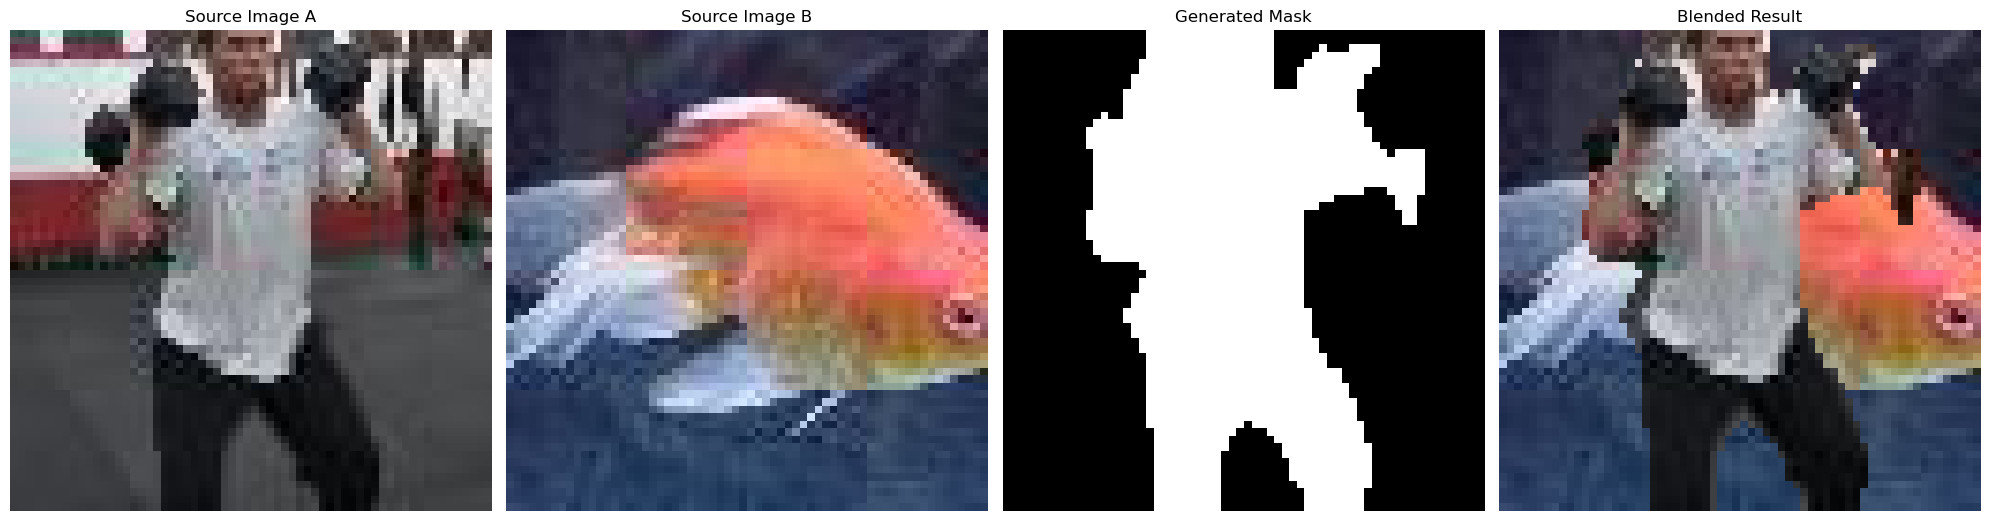

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import cv2


def get_deeplab_model(device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=True)
    model = model.to(device)
    model.eval()
    return model

def adjust_black_background(img_pil):
    img_np = np.array(img_pil)
    black_pixels = np.all(img_np == [0, 0, 0], axis=2)
    if np.mean(black_pixels) > 0.5:
        enhancer = ImageEnhance.Brightness(img_pil)
        return enhancer.enhance(2.0)
    return img_pil

seg_transform = transforms.Compose([
    transforms.Resize(520),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.Lambda(adjust_black_background),
    transforms.ColorJitter(contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MaskProcessor:
    def __init__(self):
        self.color_map = self._create_color_map()
        
    def _create_color_map(self):
        cmap = np.zeros((256, 3), dtype=np.uint8)
        cmap[0] = [0, 0, 0]  
        np.random.seed(42)
        cmap[1:] = np.random.randint(25, 256, (255, 3))  
        return cmap
    
    def _postprocess_mask(self, mask, original_size):
        """参考代码的掩膜后处理方法"""
   
        binary_mask = np.where(mask > 0, 255, 0).astype(np.uint8)
        
      
        binary_mask = cv2.GaussianBlur(binary_mask, (5,5), 0)
    
        thresh = cv2.adaptiveThreshold(
            binary_mask, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
    
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_mask = np.zeros_like(binary_mask)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(filled_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        
   
        return cv2.resize(filled_mask, original_size, interpolation=cv2.INTER_NEAREST)


class SemanticMixer:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.transform = seg_transform
    
    def generate_mask(self, img_pil):
        original_size = img_pil.size
        img_tensor = self.transform(img_pil).unsqueeze(0)
        
        with torch.no_grad():
            output = self.model(img_tensor.to(device))['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        
        return self.processor._postprocess_mask(mask, original_size)
    
    def blend_images(self, img_a_pil, img_b_pil, mask):
 
        img_a = np.array(img_a_pil)
        img_b = np.array(img_b_pil)
        

        mask = cv2.resize(mask, img_a.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
        
   
        mask = mask.astype(float)/255.0
        mask = np.expand_dims(mask, axis=-1)
        
        blended = img_a * mask + img_b * (1 - mask)
        return Image.fromarray(blended.astype(np.uint8)), mask.squeeze()

def visualize_results(original_a, original_b, blended, mask):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1,4,1)
    plt.imshow(original_a)
    plt.title("Source Image A")
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(original_b)
    plt.title("Source Image B")
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(mask, cmap='gray')
    plt.title("Generated Mask")
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(blended)
    plt.title("Blended Result")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = get_deeplab_model(device)
    processor = MaskProcessor()
    mixer = SemanticMixer(model, processor)
    

    dataset = torchvision.datasets.ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
        transform=None
    )
    

    indices = np.random.choice(len(dataset), 2, replace=False)
    img_a, _ = dataset[5000]
    img_b, _ = dataset[2]
    

    mask = mixer.generate_mask(img_a)
    blended_img, mask = mixer.blend_images(img_a, img_b, mask)
    

    visualize_results(img_a, img_b, blended_img, mask)

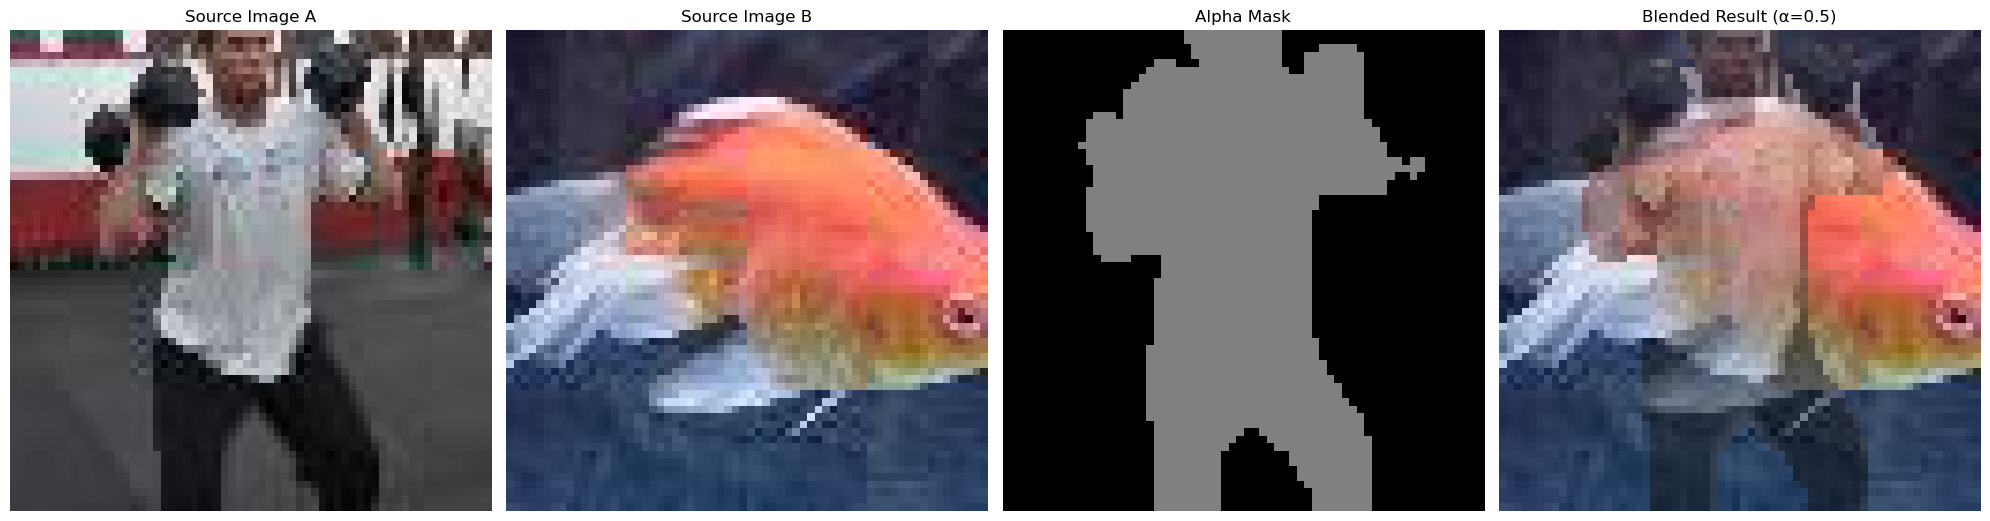

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
import cv2


def get_deeplab_model(device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model = model.to(device)
    model.eval()
    return model

def adjust_black_background(img_pil):
    img_np = np.array(img_pil)
    black_pixels = np.all(img_np == [0, 0, 0], axis=2)
    if np.mean(black_pixels) > 0.5:
        enhancer = ImageEnhance.Brightness(img_pil)
        return enhancer.enhance(2.0)
    return img_pil

seg_transform = transforms.Compose([
    transforms.Resize(520),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.Lambda(adjust_black_background),
    transforms.ColorJitter(contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MaskProcessor:
    def __init__(self):
        self.color_map = self._create_color_map()
        
    def _create_color_map(self):
        cmap = np.zeros((256, 3), dtype=np.uint8)
        cmap[0] = [0, 0, 0]  
        np.random.seed(42)
        cmap[1:] = np.random.randint(25, 256, (255, 3))
        return cmap
    
    def _postprocess_mask(self, mask, original_size):
        """改进的掩膜后处理方法"""
        binary_mask = np.where(mask > 0, 255, 0).astype(np.uint8)
        binary_mask = cv2.GaussianBlur(binary_mask, (5,5), 0)
        
        thresh = cv2.adaptiveThreshold(
            binary_mask, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
      
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_mask = np.zeros_like(binary_mask)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(filled_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        
        return cv2.resize(filled_mask, original_size, interpolation=cv2.INTER_NEAREST)


class SemanticMixer:
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.transform = seg_transform
    
    def generate_mask(self, img_pil):
        original_size = img_pil.size
        img_tensor = self.transform(img_pil).unsqueeze(0)
        
        with torch.no_grad():
            output = self.model(img_tensor.to(device))['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        
        return self.processor._postprocess_mask(mask, original_size)
    
    def blend_images(self, img_a_pil, img_b_pil, mask, alpha=0.1):
        """支持透明度的混合方法
        Args:
            alpha: 透明度系数 (0.0-1.0)
                  0.0: 完全透明（只显示B）
                  1.0: 完全不透明（完全显示A的蒙版区域）
        """
        img_a = np.array(img_a_pil)
        img_b = np.array(img_b_pil)
        

        mask = cv2.resize(mask, img_a.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
        mask = mask.astype(float)/255.0 * alpha  
        mask = np.expand_dims(mask, axis=-1)
        
        blended = img_a * mask + img_b * (1 - mask)
        return Image.fromarray(blended.astype(np.uint8)), mask.squeeze()


def visualize_results(original_a, original_b, blended, mask):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1,4,1)
    plt.imshow(original_a)
    plt.title("Source Image A")
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(original_b)
    plt.title("Source Image B")
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    plt.title("Alpha Mask")
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(blended)
    plt.title(f"Blended Result (α={alpha})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = get_deeplab_model(device)
    processor = MaskProcessor()
    mixer = SemanticMixer(model, processor)
 
    dataset = torchvision.datasets.ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
        transform=None
    )
 
    alpha = 0.5
    

    indices = np.random.choice(len(dataset), 2, replace=False)
    img_a, _ = dataset[5000]
    img_b, _ = dataset[2]
    
 
    mask = mixer.generate_mask(img_a)
    blended_img, alpha_mask = mixer.blend_images(img_a, img_b, mask, alpha=alpha)
    

    visualize_results(img_a, img_b, blended_img, alpha_mask)

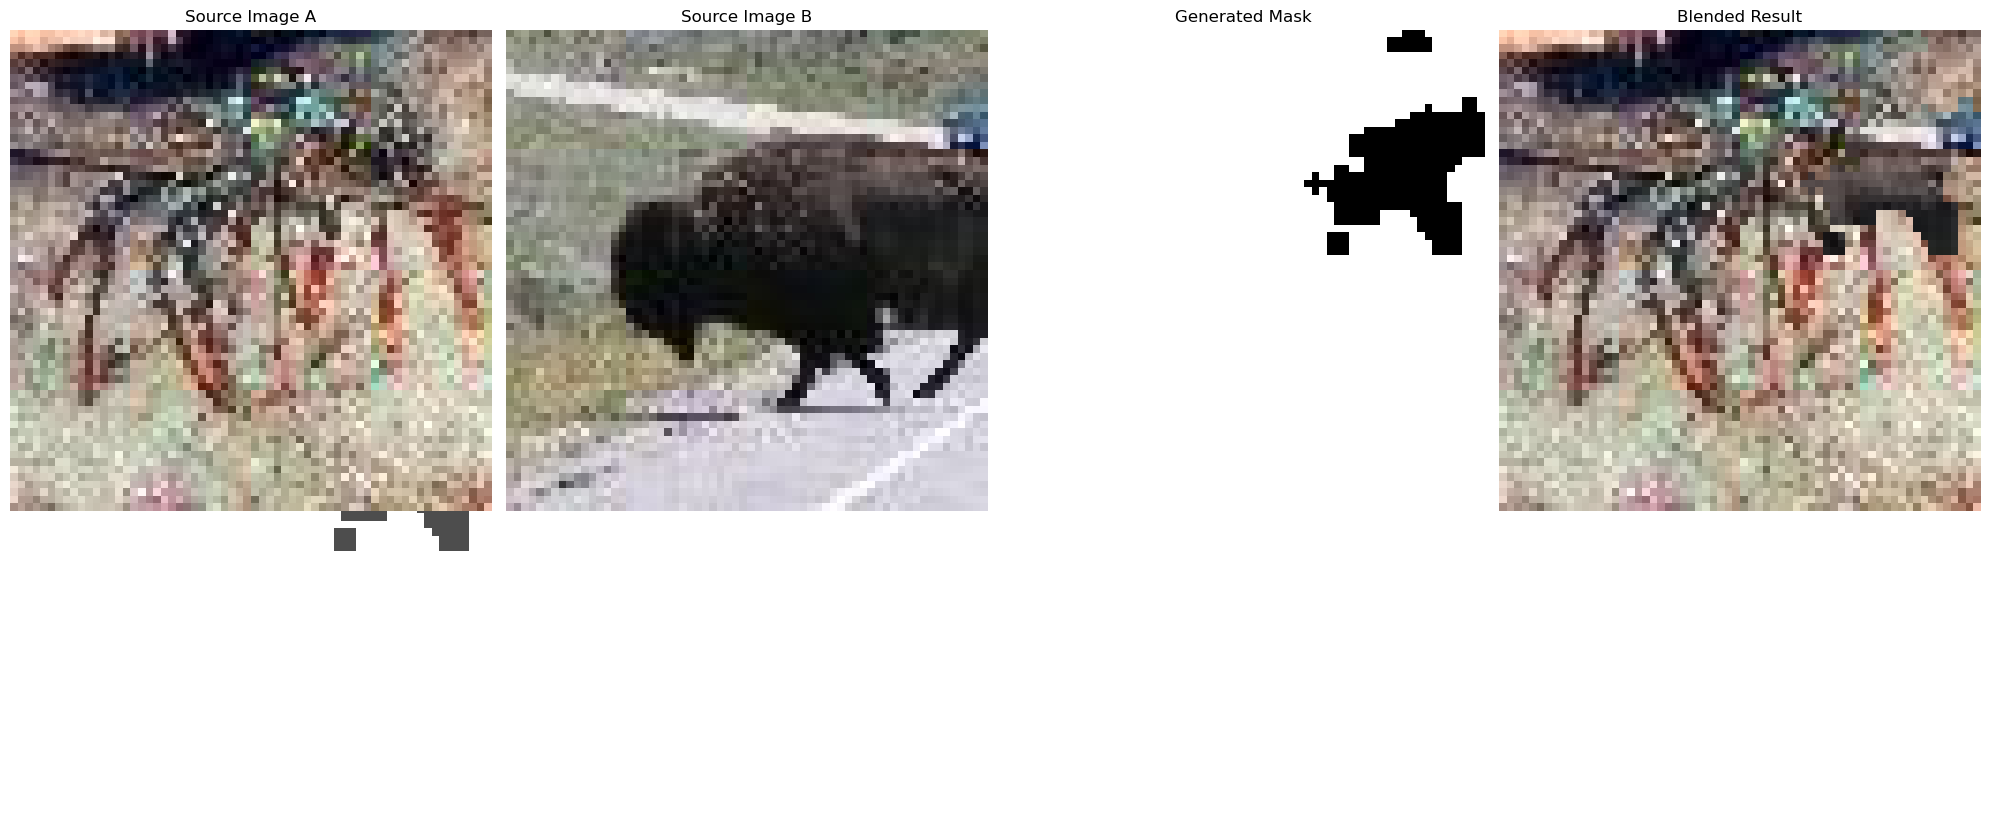

AttributeError: 'SemanticMixer' object has no attribute 'alpha'

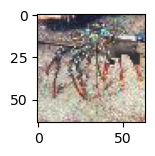

Using device: cuda


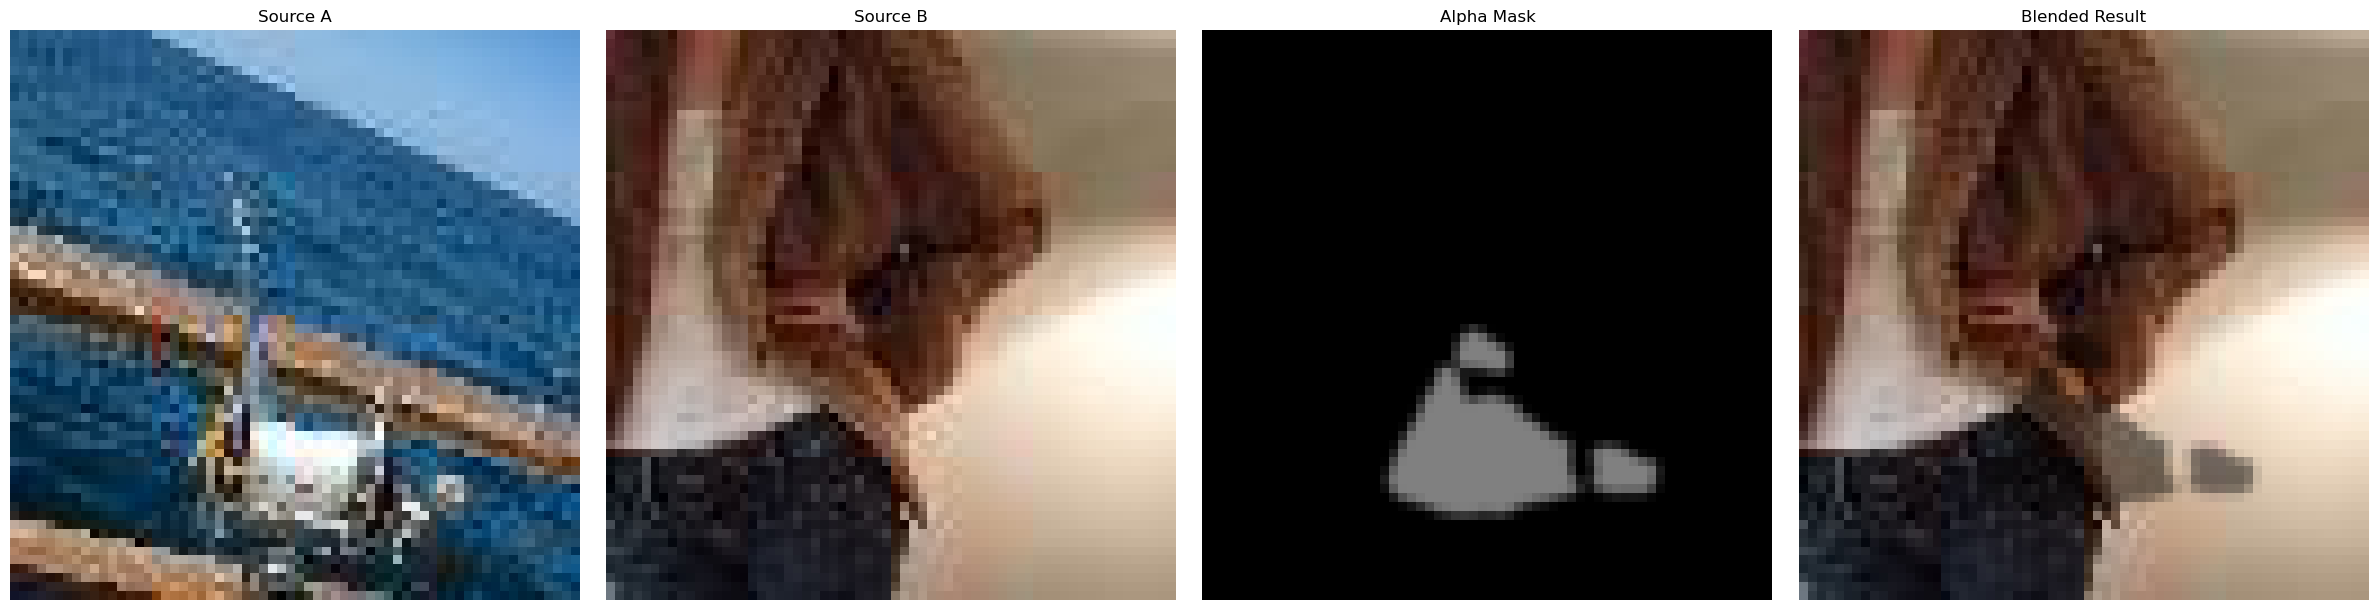

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from PIL import Image, ImageEnhance
import cv2


current_seed = int(time.time() * 1000) % 2**32
random.seed(current_seed)
np.random.seed(current_seed)
torch.manual_seed(current_seed)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


def load_deeplab():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    return model.to(device).eval()


class ImagePreprocessor:
    @staticmethod
    def adjust_black_background(img):
        """处理黑色背景问题"""
        if np.mean(np.all(np.array(img) == [0,0,0], axis=-1)) > 0.5:
            return ImageEnhance.Brightness(img).enhance(2.0)
        return img

    @property
    def transform(self):
        return transforms.Compose([
            transforms.Resize(520),
            transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Lambda(self.adjust_black_background),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])


class MaskGenerator:
    def __init__(self, alpha=0.8):
        self.alpha = alpha 
        self.valid_classes = set(range(1, 91))  

    def generate_mask(self, model, img_pil):
        """生成带透明度的语义掩膜"""
    
        preprocessor = ImagePreprocessor()
        img_tensor = preprocessor.transform(img_pil).unsqueeze(0).to(device)
        

        with torch.no_grad():
            output = model(img_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        

        processed_mask = self._postprocess(mask, img_pil.size)
        return self._apply_alpha(processed_mask)

    def _postprocess(self, mask, target_size):
   
        binary = np.isin(mask, list(self.valid_classes)).astype(np.uint8) * 255
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
        
        blurred = cv2.GaussianBlur(opened, (15,15), 5)
        
    
        resized = cv2.resize(blurred, target_size, interpolation=cv2.INTER_LINEAR)
        return resized / 255.0

    def _apply_alpha(self, mask):

        return np.clip(mask * self.alpha, 0, 1)

class ImageBlender:
    @staticmethod
    def blend(img_a, img_b, alpha_mask):
 
        img_a = np.array(img_a, dtype=np.float32) / 255
        img_b = np.array(img_b, dtype=np.float32) / 255
        alpha = alpha_mask[..., None]
        return Image.fromarray(((img_a * alpha) + (img_b * (1 - alpha)) * 255).astype(np.uint8))


class Visualizer:
    @staticmethod
    def show(images, titles, cols=3, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, cols, i+1)
            if isinstance(img, Image.Image):
                plt.imshow(img)
            else:
                plt.imshow(img, cmap='gray', vmin=0, vmax=1)
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    
    model = load_deeplab()
    mask_generator = MaskGenerator(alpha=0.5) 
    blender = ImageBlender()
    
    dataset = torchvision.datasets.ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
        transform=None
    )
    

    idx_a, idx_b = random.sample(range(len(dataset)), 2)
    img_a, _ = dataset[idx_a]
    img_b, _ = dataset[idx_b]
    
 
    alpha_mask = mask_generator.generate_mask(model, img_a)
    

    blended_img = blender.blend(img_a, img_b, alpha_mask)
    
 
    Visualizer.show(
        images=[img_a, img_b, alpha_mask, blended_img],
        titles=["Source A", "Source B", "Alpha Mask", "Blended Result"],
        cols=4,
        figsize=(24, 6)
    )

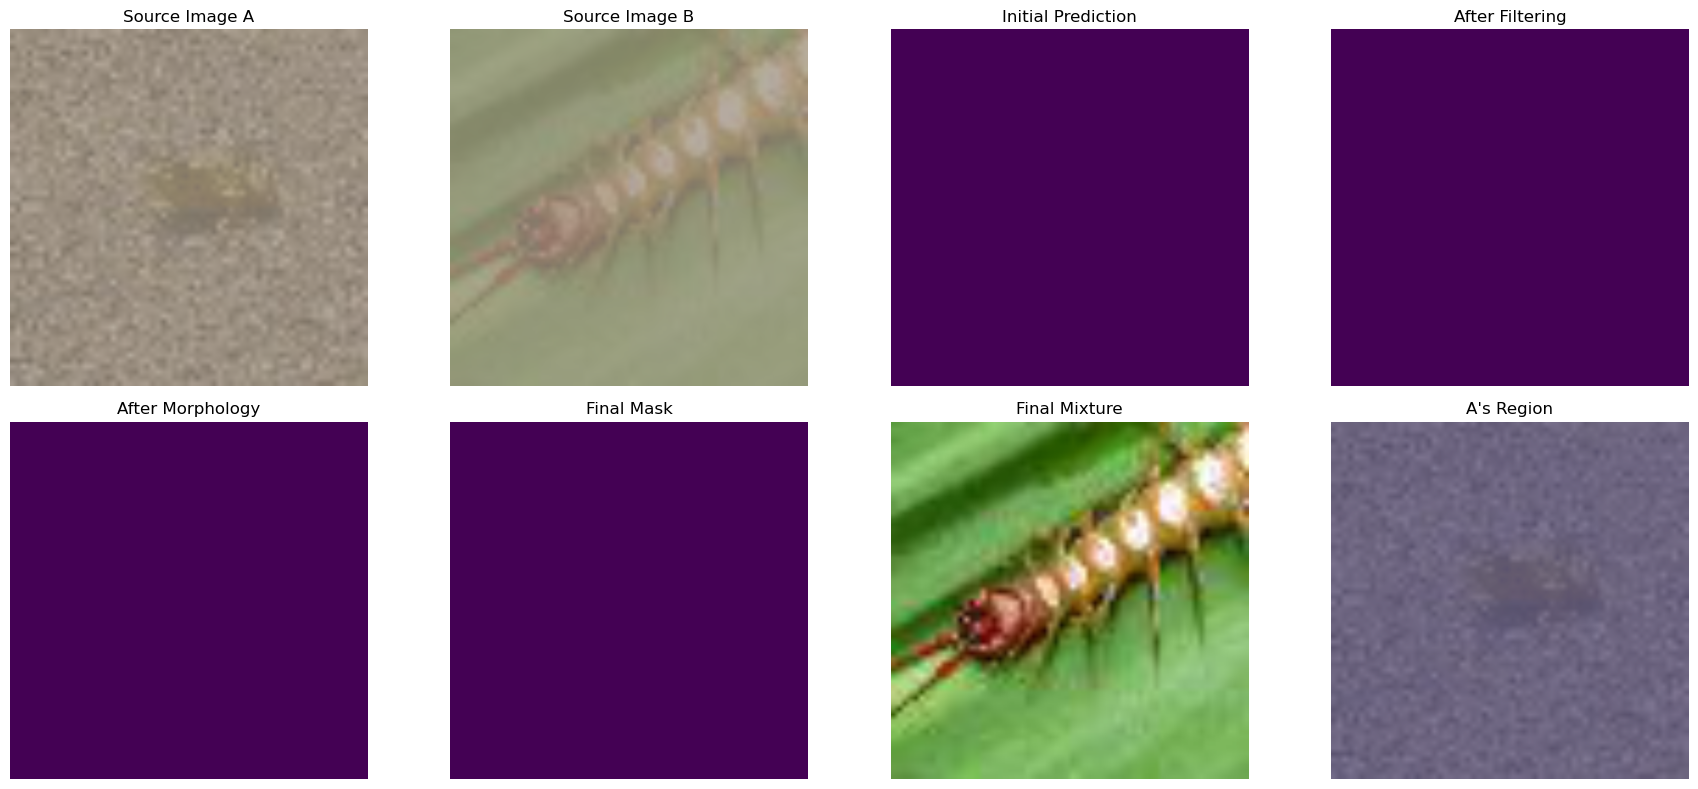

In [ ]:
import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy import ndimage
import cv2


class SegmentationModel:
    def __init__(self, device='cuda:1'):
        self.device = device
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True).to(device)
        self.model.eval()
        

        self.background_classes = [0]  
        self.valid_classes = set(range(1, 91)) - set(self.background_classes)
        
    def predict(self, img_tensor):
        with torch.no_grad():
            input_tensor = img_tensor.unsqueeze(0).to(self.device)
            output = self.model(input_tensor)['out']
            return torch.argmax(output.squeeze(), dim=0).cpu().numpy()


class MaskProcessor:
    def __init__(self, valid_classes, min_object_size=500, soft_border=5):
        self.valid_classes = set(valid_classes)  
        self.soft_border = soft_border
        
    def process(self, mask):
 
        binary_mask = self._get_main_object_mask(mask)
        
  
        processed_mask = self._morphological_processing(binary_mask)
        
        final_mask = self._soften_edges(processed_mask)
        
        return final_mask.astype(np.float32)
    
    def _get_main_object_mask(self, mask):
        # 筛选有效物体区域（使用传入的valid_classes）
        object_mask = np.isin(mask, list(self.valid_classes))
        labeled, num_features = ndimage.label(object_mask)
        
        # 选择最大连通区域
        if num_features > 0:
            sizes = ndimage.sum(object_mask, labeled, range(num_features+1))
            max_label = np.argmax(sizes)
            main_object = (labeled == max_label)
            
      
            if np.sum(main_object) > self.min_object_size:
                return main_object
        return np.zeros_like(mask, dtype=bool)
    
    def _get_main_object_mask(self, mask):
        object_mask = np.isin(mask, list(self.valid_classes))
        labeled, num_features = ndimage.label(object_mask)
        if num_features > 0:
            sizes = ndimage.sum(object_mask, labeled, range(num_features+1))
            max_label = np.argmax(sizes)
            main_object = (labeled == max_label)
            
            # 尺寸过滤
            if np.sum(main_object) > self.min_object_size:
                return main_object
        return np.zeros_like(mask, dtype=bool)
    
    def _morphological_processing(self, mask):
        # 填充空洞
        filled = ndimage.binary_fill_holes(mask)
        # 开运算去噪声
        kernel = np.ones((5,5), np.uint8)
        return cv2.morphologyEx(filled.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    
    def _soften_edges(self, mask):
        if self.soft_border > 0:
            blurred = cv2.GaussianBlur(mask.astype(np.float32), 
                                     (0, 0), self.soft_border*2)
            return np.clip(blurred * 2, 0, 1)
        return mask.astype(np.float32)

class SemanticMixer:
    def __init__(self, seg_model, processor):  
        self.seg_model = seg_model
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize(520),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    @property
    def base_transform(self):
        return self.transform  
    def _get_processed_mask(self, img_pil):
      
        img_tensor = self.base_transform(img_pil.convert('RGB'))
        raw_mask = self.seg_model.predict(img_tensor)
        return raw_mask, self.processor.process(raw_mask) 

    def mix_images(self, img_a_pil, img_b_pil):
       
        raw_mask, base_mask = self._get_processed_mask(img_a_pil)
    
        img_a = self.base_transform(img_a_pil)
        img_b = self.base_transform(img_b_pil)
        h, w = img_a.shape[1:]
        

        base_mask = transforms.functional.resize(
            torch.from_numpy(base_mask).unsqueeze(0), 
            (h, w)
        ).squeeze().numpy()
        
  
        mixed = img_a * base_mask + img_b * (1 - base_mask)
        return mixed, base_mask, raw_mask  
        return self.processor.process(raw_mask)


def visualize_mixing(img_a, img_b, mixed, mask_sequence):
    plt.figure(figsize=(18, 8))
    
    
    plt.subplot(2, 4, 1)
    show_image(img_a, "Source Image A")
    plt.subplot(2, 4, 2)
    show_image(img_b, "Source Image B")
    
 
    for i, (title, mask) in enumerate(mask_sequence, 3):
        plt.subplot(2, 4, i)
        plt.imshow(mask, cmap='viridis')
        plt.title(title)
        plt.axis('off')
    

    plt.subplot(2, 4, 7)
    show_image(mixed, "Final Mixture")
    

    plt.subplot(2, 4, 8)
    show_image(img_a, "A's Region", mask=mask_sequence[-1][1])
    plt.tight_layout()
    plt.show()

def show_image(tensor, title=None, mask=None):
    inverse_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inverse_norm(tensor).clamp(0,1).permute(1,2,0)
    
    plt.imshow(img)
    if mask is not None:
        plt.imshow(mask, alpha=0.3, cmap='jet')
    if title: plt.title(title)
    plt.axis('off')
    

if __name__ == "__main__":
  
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    seg_model = SegmentationModel(device)
    processor = MaskProcessor(valid_classes=seg_model.valid_classes, min_object_size=1000)
    mixer = SemanticMixer(seg_model, processor)
    

    raw_testset = datasets.ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
        transform=None
    )
    img_a, _ = raw_testset[100]  
    img_b, _ = raw_testset[500]  
    
    
    mixed_img, final_mask, raw_mask = mixer.mix_images(img_a, img_b)
    
  
    binary_mask = processor._get_main_object_mask(raw_mask)
    morph_mask = processor._morphological_processing(binary_mask)
    
 
    mask_sequence = [
        ('Initial Prediction', raw_mask),
        ('After Filtering', binary_mask),
        ('After Morphology', morph_mask),
        ('Final Mask', final_mask)
    ]
    

    def denormalize(tensor):
        return tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
               torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    
    visualize_mixing(
        denormalize(mixer.base_transform(img_a)), 
        denormalize(mixer.base_transform(img_b)),
        mixed_img, 
        mask_sequence
    )

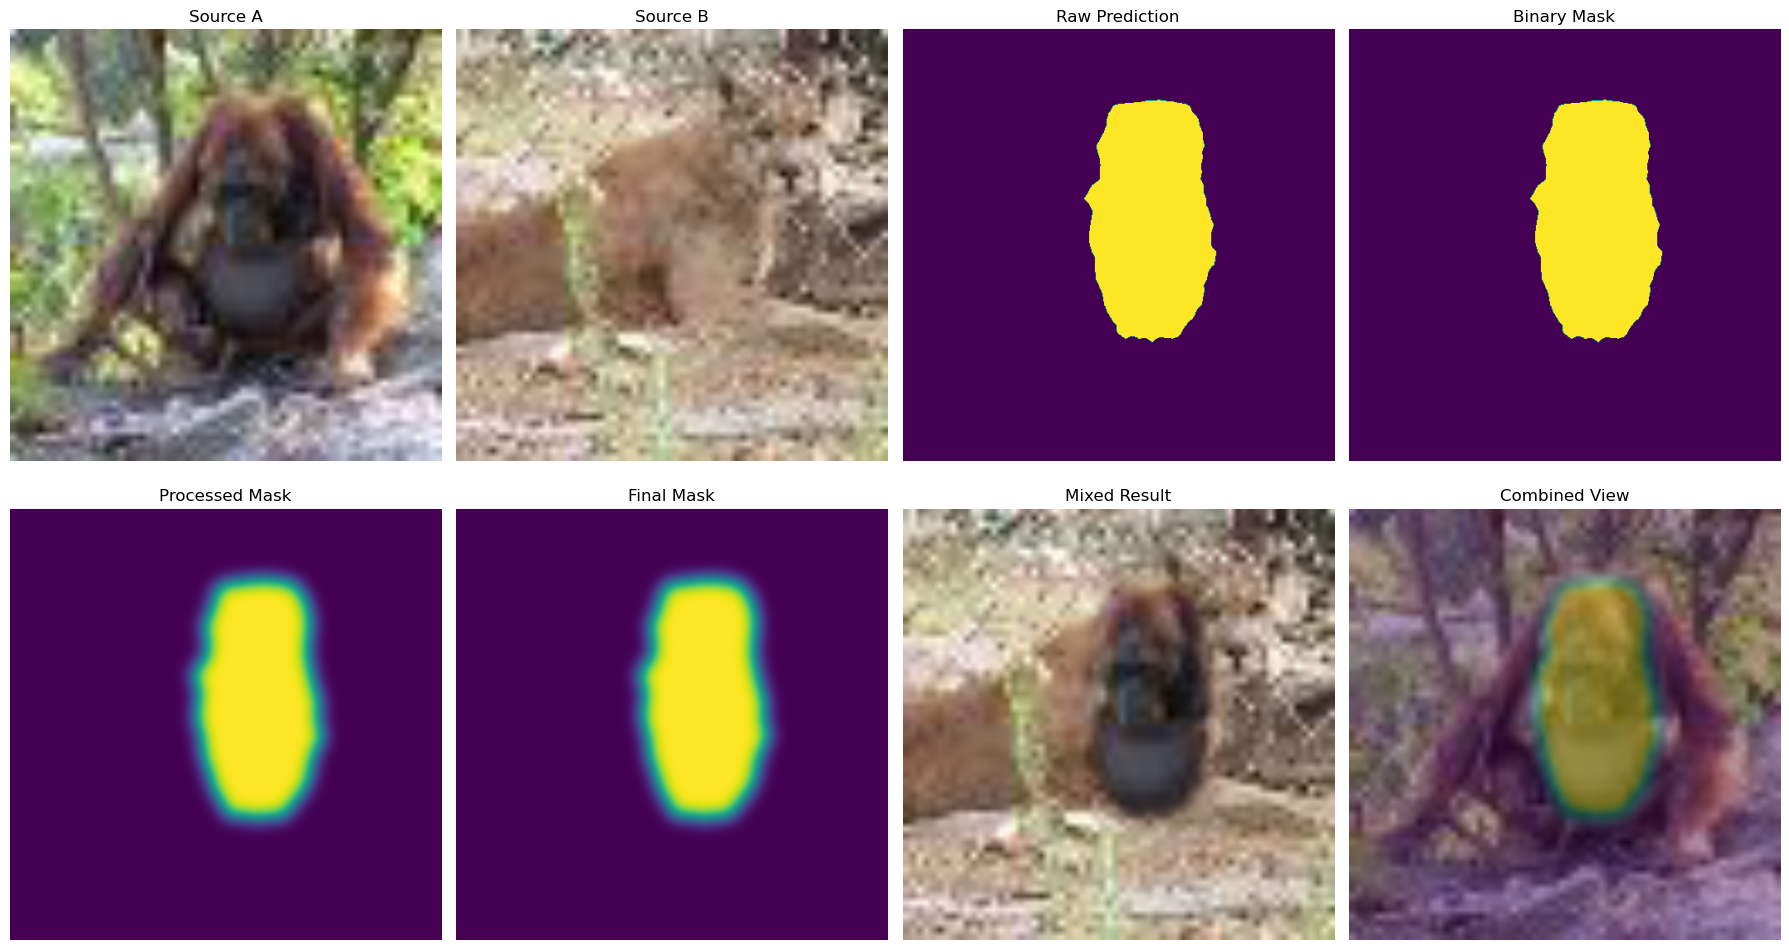

In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import cv2
from PIL import Image
import random


class SegmentationModel:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True).to(device)
        self.model.eval()
        
      
        self.valid_classes = {
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
            21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
            41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
            59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79,
            80, 81, 82, 84, 85, 86, 87, 88, 89, 90
        }

    def predict(self, img_tensor):
        with torch.no_grad():
            input_tensor = img_tensor.unsqueeze(0).to(self.device)
            output = self.model(input_tensor)['out']
            return torch.argmax(output.squeeze(), dim=0).cpu().numpy()


class MaskProcessor:
    def __init__(self, valid_classes, min_object_size=1000, soft_border=5):
        self.valid_classes = set(valid_classes)
        self.min_object_size = min_object_size
        self.soft_border = soft_border
        
    def process(self, mask):
        binary_mask = self._get_main_object_mask(mask)
        processed_mask = self._morphological_processing(binary_mask)
        return self._soften_edges(processed_mask).astype(np.float32)
    
    def _get_main_object_mask(self, mask):
        object_mask = np.isin(mask, list(self.valid_classes))
        labeled, num_features = ndimage.label(object_mask)
        
        if num_features > 0:
            sizes = ndimage.sum(object_mask, labeled, range(num_features+1))
            max_label = np.argmax(sizes)
            main_object = (labeled == max_label)
            if main_object.sum() > self.min_object_size:
                return main_object
        return np.zeros_like(mask, dtype=bool)
    
    def _morphological_processing(self, mask):
        kernel = np.ones((5,5), np.uint8)
        return cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    
    def _soften_edges(self, mask):
        return cv2.GaussianBlur(mask.astype(float), (0,0), self.soft_border*2)


class SemanticMixer:
    def __init__(self, seg_model, processor):
        self.seg_model = seg_model
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.Resize(520),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def mix_images(self, img_a_pil, img_b_pil):
        raw_mask, processed_mask = self._process_mask(img_a_pil)
        img_a = self._transform_image(img_a_pil)
        img_b = self._transform_image(img_b_pil)
        

        h, w = img_a.shape[1:]
        final_mask = transforms.Resize((h, w))(torch.from_numpy(processed_mask).unsqueeze(0)).squeeze().numpy()
        
        return (
            img_a * final_mask + img_b * (1 - final_mask),
            final_mask,
            raw_mask,
            processed_mask
        )
    
    def _process_mask(self, img_pil):
        img_tensor = self.transform(img_pil.convert('RGB'))
        raw_mask = self.seg_model.predict(img_tensor)
        return raw_mask, self.processor.process(raw_mask)
    
    def _transform_image(self, img_pil):
        return self.transform(img_pil.convert('RGB'))


class Visualizer:
    @staticmethod
    def denormalize(tensor):
        return tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
               torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    
    @classmethod
    def show(cls, tensor, title=None, mask=None):
        img = cls.denormalize(tensor).clamp(0,1).permute(1,2,0)
        plt.imshow(img)
        if mask is not None:
            plt.imshow(mask, alpha=0.4, cmap='viridis')
        plt.title(title or '')
        plt.axis('off')
    
    @classmethod
    def visualize_mixing(cls, img_a, img_b, mixed, masks):
        plt.figure(figsize=(18, 10))
        

        plt.subplot(2, 4, 1)
        cls.show(img_a, "Source A")
        plt.subplot(2, 4, 2)
        cls.show(img_b, "Source B")
        
 
        for i, (title, mask) in enumerate(masks, 3):
            plt.subplot(2, 4, i)
            plt.imshow(mask, cmap='viridis')
            plt.title(title)
            plt.axis('off')

        plt.subplot(2, 4, 7)
        cls.show(mixed, "Mixed Result")
        plt.subplot(2, 4, 8)
        cls.show(img_a, "Combined View", mask=masks[-1][1])
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seg_model = SegmentationModel(device)
    processor = MaskProcessor(seg_model.valid_classes, min_object_size=1500)
    mixer = SemanticMixer(seg_model, processor)
    
    try:
        dataset = datasets.ImageFolder(
            root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/val_images',
            transform=None
        )
        assert len(dataset) > 50, "数据集样本不足"
    except Exception as e:
        print(f"数据集加载失败: {str(e)}")
        exit()
    
  
    indices = random.sample(range(len(dataset)), 2)
    img_a, _ = dataset[indices[0]]
    img_b, _ = dataset[indices[1]]
    
  
    mixed_img, final_mask, raw_mask, proc_mask = mixer.mix_images(img_a, img_b)
    
  
    mask_sequence = [
        ('Raw Prediction', raw_mask),
        ('Binary Mask', processor._get_main_object_mask(raw_mask)),
        ('Processed Mask', proc_mask),
        ('Final Mask', final_mask)
    ]
    
  
    Visualizer.visualize_mixing(
        mixer._transform_image(img_a),
        mixer._transform_image(img_b),
        mixed_img,
        mask_sequence
    )

In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def get_segmentation_models():
    """加载多个分割模型并返回列表"""
    model_list = []
    try:
        deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)
        deeplab = deeplab.to(device).eval()
        model_list.append(deeplab)
    except Exception as e:
        print(f"加载DeepLabV3失败: {str(e)}")
    
    # FCN
    try:
        fcn = models.segmentation.fcn_resnet50(pretrained=True)
        fcn = fcn.to(device).eval()
        model_list.append(fcn)
    except Exception as e:
        print(f"加载FCN失败: {str(e)}")
    
    return model_list


def ensemble_predict(models, input_tensor):
    """
    多模型融合预测
    :param models: 加载好的模型列表
    :param input_tensor: 输入张量 (1,C,H,W)
    :return: 融合后的mask (H,W)
    """
    all_masks = []
    
    with torch.no_grad():
        for model in models:
            output = model(input_tensor)['out']
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
            all_masks.append(mask)
    
    # 多数投票融合
    stacked = np.stack(all_masks, axis=0)
    final_mask = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=stacked
    )
    
    return final_mask.astype(np.uint8)

class SegmentationDataset(Dataset):
    def __init__(self, raw_dataset, models, transform=None):
        self.raw_dataset = raw_dataset
        self.models = models  
        self.transform = transform
        self.color_map = self._create_color_map()
    
    # ... [保持其他方法不变] ...
    def __len__(self):
        return len(self.raw_dataset)
    
    def _create_color_map(self):
        cmap = np.zeros((256, 3), dtype=np.uint8)
        cmap[0] = [0, 0, 0]  
        for i in range(1, 256):
            cmap[i] = np.random.randint(0, 255, 3)
        return cmap

    
    def __getitem__(self, idx):
        # 获取原始PIL图像
        img_pil, label = self.raw_dataset[idx]
        
     
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)
        
        # 多模型融合预测
        input_tensor = img_tensor.unsqueeze(0).to(device)
        mask = ensemble_predict(self.models, input_tensor) 
        
        # 转换为彩色掩码
        colored_mask = self.color_map[mask]
        
        return img_pil, colored_mask, label


if __name__ == "__main__":
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
    
    models = get_segmentation_models()
    print(f"成功加载 {len(models)} 个分割模型")
    
  
    seg_testset = SegmentationDataset(
        raw_testset, 
        models=models,  
        transform=seg_transform
    )
    
   
    num_samples = 5
    indices = np.random.choice(len(seg_testset), num_samples)
    
    for i in indices:
        img, mask, label = seg_testset[i]
        visualize_segmentation(np.array(img), mask)

/home/yl38u22/miniconda3/envs/my-pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


成功加载 2 个分割模型


NameError: name 'visualize_segmentation' is not defined

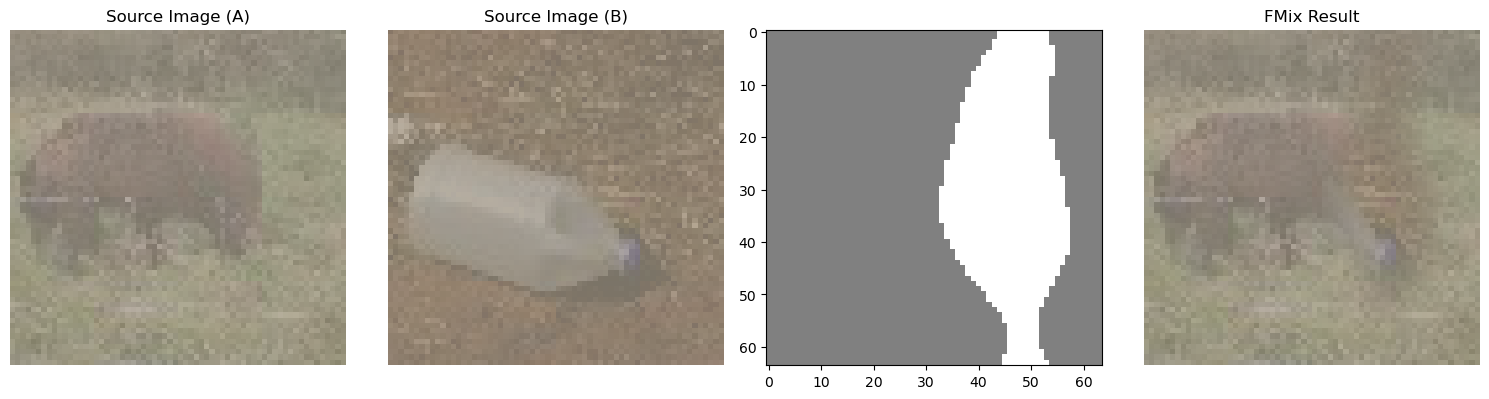

In [ ]:
import math
import random

import numpy as np
from scipy.stats import beta


def fftfreqnd(h, w=None, z=None):
    """ Get bin values for discrete fourier transform of size (h, w, z)

    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    fz = fx = 0
    fy = np.fft.fftfreq(h)

    if w is not None:
        fy = np.expand_dims(fy, -1)

        if w % 2 == 1:
            fx = np.fft.fftfreq(w)[: w // 2 + 2]
        else:
            fx = np.fft.fftfreq(w)[: w // 2 + 1]

    if z is not None:
        fy = np.expand_dims(fy, -1)
        if z % 2 == 1:
            fz = np.fft.fftfreq(z)[:, None]
        else:
            fz = np.fft.fftfreq(z)[:, None]

    return np.sqrt(fx * fx + fy * fy + fz * fz)


def get_spectrum(freqs, decay_power, ch, h, w=0, z=0):
    """ Samples a fourier image with given size and frequencies decayed by decay power

    :param freqs: Bin values for the discrete fourier transform
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param ch: Number of channels for the resulting mask
    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    scale = np.ones(1) / (np.maximum(freqs, np.array([1. / max(w, h, z)])) ** decay_power)

    param_size = [ch] + list(freqs.shape) + [2]
    param = np.random.randn(*param_size)

    scale = np.expand_dims(scale, -1)[None, :]

    return scale * param


def make_low_freq_image(decay, shape, ch=1):
    """ Sample a low frequency image from fourier space

    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param ch: Number of channels for desired mask
    """
    freqs = fftfreqnd(*shape)
    spectrum = get_spectrum(freqs, decay, ch, *shape)#.reshape((1, *shape[:-1], -1))
    spectrum = spectrum[:, 0] + 1j * spectrum[:, 1]
    mask = np.real(np.fft.irfftn(spectrum, shape))

    if len(shape) == 1:
        mask = mask[:1, :shape[0]]
    if len(shape) == 2:
        mask = mask[:1, :shape[0], :shape[1]]
    if len(shape) == 3:
        mask = mask[:1, :shape[0], :shape[1], :shape[2]]

    mask = mask
    mask = (mask - mask.min())
    mask = mask / mask.max()
    return mask


def sample_lam(alpha, reformulate=False):
    """ Sample a lambda from symmetric beta distribution with given alpha

    :param alpha: Alpha value for beta distribution
    :param reformulate: If True, uses the reformulation of [1].
    """
    if reformulate:
        lam = beta.rvs(alpha+1, alpha)
    else:
        lam = beta.rvs(alpha, alpha)

    return lam


def binarise_mask(mask, lam, in_shape, max_soft=0.0):
    """ Binarises a given low frequency image such that it has mean lambda.

    :param mask: Low frequency image, usually the result of `make_low_freq_image`
    :param lam: Mean value of final mask
    :param in_shape: Shape of inputs
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :return:
    """
    idx = mask.reshape(-1).argsort()[::-1]
    mask = mask.reshape(-1)
    num = math.ceil(lam * mask.size) if random.random() > 0.5 else math.floor(lam * mask.size)

    eff_soft = max_soft
    if max_soft > lam or max_soft > (1-lam):
        eff_soft = min(lam, 1-lam)

    soft = int(mask.size * eff_soft)
    num_low = num - soft
    num_high = num + soft

    mask[idx[:num_high]] = 1
    mask[idx[num_low:]] = 0
    mask[idx[num_low:num_high]] = np.linspace(1, 0, (num_high - num_low))

    mask = mask.reshape((1, *in_shape))
    return mask


def sample_mask(alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """ Samples a mean lambda from beta distribution parametrised by alpha, creates a low frequency image and binarises
    it based on this lambda

    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    """
    if isinstance(shape, int):
        shape = (shape,)

    # Choose lambda
    lam = sample_lam(alpha, reformulate)

    # Make mask, get mean / std
    mask = make_low_freq_image(decay_power, shape)
    mask = binarise_mask(mask, lam, shape, max_soft)

    return lam, mask


def sample_and_apply(x, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """

    :param x: Image batch on which to apply fmix of shape [b, c, shape*]
    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    :return: mixed input, permutation indices, lambda value of mix,
    """
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    index = np.random.permutation(x.shape[0])

    x1, x2 = x * mask, x[index] * (1-mask)
    return x1+x2, index, lam


class FMixBase:
    r""" FMix augmentation

        Args:
            decay_power (float): Decay power for frequency decay prop 1/f**d
            alpha (float): Alpha value for beta distribution from which to sample mean of mask
            size ([int] | [int, int] | [int, int, int]): Shape of desired mask, list up to 3 dims
            max_soft (float): Softening value between 0 and 0.5 which smooths hard edges in the mask.
            reformulate (bool): If True, uses the reformulation of [1].
    """

    def __init__(self, decay_power=3, alpha=1, size=(32, 32), max_soft=0.0, reformulate=False):
        super().__init__()
        self.decay_power = decay_power
        self.reformulate = reformulate
        self.size = size
        self.alpha = alpha
        self.max_soft = max_soft
        self.index = None
        self.lam = None

    def __call__(self, x):
        raise NotImplementedError

    def loss(self, *args, **kwargs):
        raise NotImplementedError


import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np

# 修改后的FMix可视化类
class FMixVisualizer:
    def __init__(self, alpha=1.0, decay_power=3, size=(64,64)):
        self.alpha = alpha
        self.decay_power = decay_power
        self.size = size
    
    def apply_fmix(self, img_a, img_b):
    
        x = torch.stack([img_a, img_b]).numpy()
        
        # 应用FMix
        mixed, self.index, self.lam = sample_and_apply(
            x, 
            alpha=self.alpha,
            decay_power=self.decay_power,
            shape=self.size,
            max_soft=0.3
        )
        
       
        self.mask = (mixed[0] != x[0]).any(axis=0)  
        return torch.from_numpy(mixed[0]), torch.from_numpy(self.mask.astype(float))


def tin_imshow(img, title=None, mask=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
  
    if mask is not None:
        plt.imshow(mask, cmap='gray', alpha=0.5)
        return
    
  
    img = img.cpu() * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0)
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')


if __name__ == "__main__":
   
    raw_transform = transforms.Compose([transforms.ToTensor()])
    trainset = ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/train',
        transform=raw_transform
    )
    loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)
    images, _ = next(iter(loader))
    img_a, img_b = images[0], images[1]
    
  
    fmixer = FMixVisualizer(alpha=1.0, decay_power=3, size=(64,64))
    

    mixed_img, mask = fmixer.apply_fmix(img_a, img_b)
    
 
    plt.figure(figsize=(15, 5))
    

    plt.subplot(1, 4, 1)
    tin_imshow(img_a, "Source Image (A)")
    
 
    plt.subplot(1, 4, 2)
    tin_imshow(img_b, "Source Image (B)")
    
  
    plt.subplot(1, 4, 3)
    tin_imshow(None, "FMix Mask", mask=mask.numpy())

    plt.subplot(1, 4, 4)
    tin_imshow(mixed_img, "FMix Result")
    
    plt.tight_layout()
    plt.show()

In [13]:
import torchvision
print(torchvision.__version__)

0.20.1


In [ ]:
#semantic mix smix

import math
import random

import numpy as np
from scipy.stats import beta
import torchvision.transforms as T

from torchvision.models.segmentation import deeplabv3_resnet50


class SemanticFMix(FMixVisualizer):
    def __init__(self, alpha=1.0, decay_power=3, size=(64,64), 
                seg_threshold=0.7, obj_ratio=0.5):
        super().__init__(alpha, decay_power, size)
        self.seg_model = deeplabv3_resnet50(pretrained=True).eval()
        self.seg_threshold = seg_threshold
        self.obj_ratio = obj_ratio

    def get_semantic_mask(self, img_tensor):
        """ 兼容不同版本的分割模型输出 """
        with torch.no_grad():
            output = self.seg_model(img_tensor.unsqueeze(0))
       
            if isinstance(output, dict):
                output = output['out']  # torchvision >= 0.8.0
            else:
                output = output[0]      # torchvision < 0.8.0
                
            mask = torch.argmax(output, dim=1).squeeze()
            return (mask > 0)  # 布尔型掩码

    def apply_semantic_fmix(self, img_a, img_b):
    
        mixed_img, base_mask = super().apply_fmix(img_a, img_b)
        

        seg_mask_a = self.get_semantic_mask(img_a)
        seg_mask_b = self.get_semantic_mask(img_b)


        combined_mask = base_mask.bool() & (~seg_mask_a) & (~seg_mask_b)
   
        final_mask = self._enforce_object_coverage(
            combined_mask.float(), 
            seg_mask_a | seg_mask_b
        )
        
   
        final_img = img_a * final_mask + img_b * (1 - final_mask)
        return final_img, final_mask, seg_mask_a, seg_mask_b

    def _enforce_object_coverage(self, mask, obj_mask):
        """ 确保物体区域保留比例 """
        obj_mask = obj_mask.float()
        obj_area = obj_mask.sum()
        removed = (mask * obj_mask).sum()
        
        if obj_area > 0 and removed / obj_area > (1 - self.obj_ratio):
            restore_ratio = (removed - (1 - self.obj_ratio)*obj_area) / obj_area
            restore_mask = (obj_mask.bool() & (torch.rand_like(mask) < restore_ratio))
            mask[restore_mask] = 0
        return mask


def fftfreqnd(h, w=None, z=None):
    """ Get bin values for discrete fourier transform of size (h, w, z)

    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    fz = fx = 0
    fy = np.fft.fftfreq(h)

    if w is not None:
        fy = np.expand_dims(fy, -1)

        if w % 2 == 1:
            fx = np.fft.fftfreq(w)[: w // 2 + 2]
        else:
            fx = np.fft.fftfreq(w)[: w // 2 + 1]

    if z is not None:
        fy = np.expand_dims(fy, -1)
        if z % 2 == 1:
            fz = np.fft.fftfreq(z)[:, None]
        else:
            fz = np.fft.fftfreq(z)[:, None]

    return np.sqrt(fx * fx + fy * fy + fz * fz)


def get_spectrum(freqs, decay_power, ch, h, w=0, z=0):
    """ Samples a fourier image with given size and frequencies decayed by decay power

    :param freqs: Bin values for the discrete fourier transform
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param ch: Number of channels for the resulting mask
    :param h: Required, first dimension size
    :param w: Optional, second dimension size
    :param z: Optional, third dimension size
    """
    scale = np.ones(1) / (np.maximum(freqs, np.array([1. / max(w, h, z)])) ** decay_power)

    param_size = [ch] + list(freqs.shape) + [2]
    param = np.random.randn(*param_size)

    scale = np.expand_dims(scale, -1)[None, :]

    return scale * param


def make_low_freq_image(decay, shape, ch=1):
    """ Sample a low frequency image from fourier space

    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param ch: Number of channels for desired mask
    """
    freqs = fftfreqnd(*shape)
    spectrum = get_spectrum(freqs, decay, ch, *shape)#.reshape((1, *shape[:-1], -1))
    spectrum = spectrum[:, 0] + 1j * spectrum[:, 1]
    mask = np.real(np.fft.irfftn(spectrum, shape))

    if len(shape) == 1:
        mask = mask[:1, :shape[0]]
    if len(shape) == 2:
        mask = mask[:1, :shape[0], :shape[1]]
    if len(shape) == 3:
        mask = mask[:1, :shape[0], :shape[1], :shape[2]]

    mask = mask
    mask = (mask - mask.min())
    mask = mask / mask.max()
    return mask


def sample_lam(alpha, reformulate=False):
    """ Sample a lambda from symmetric beta distribution with given alpha

    :param alpha: Alpha value for beta distribution
    :param reformulate: If True, uses the reformulation of [1].
    """
    if reformulate:
        lam = beta.rvs(alpha+1, alpha)
    else:
        lam = beta.rvs(alpha, alpha)

    return lam


def binarise_mask(mask, lam, in_shape, max_soft=0.0):
    """ Binarises a given low frequency image such that it has mean lambda.

    :param mask: Low frequency image, usually the result of `make_low_freq_image`
    :param lam: Mean value of final mask
    :param in_shape: Shape of inputs
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :return:
    """
    idx = mask.reshape(-1).argsort()[::-1]
    mask = mask.reshape(-1)
    num = math.ceil(lam * mask.size) if random.random() > 0.5 else math.floor(lam * mask.size)

    eff_soft = max_soft
    if max_soft > lam or max_soft > (1-lam):
        eff_soft = min(lam, 1-lam)

    soft = int(mask.size * eff_soft)
    num_low = num - soft
    num_high = num + soft

    mask[idx[:num_high]] = 1
    mask[idx[num_low:]] = 0
    mask[idx[num_low:num_high]] = np.linspace(1, 0, (num_high - num_low))

    mask = mask.reshape((1, *in_shape))
    return mask


def sample_mask(alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """ Samples a mean lambda from beta distribution parametrised by alpha, creates a low frequency image and binarises
    it based on this lambda

    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    """
    if isinstance(shape, int):
        shape = (shape,)

    # Choose lambda
    lam = sample_lam(alpha, reformulate)

    # Make mask, get mean / std
    mask = make_low_freq_image(decay_power, shape)
    mask = binarise_mask(mask, lam, shape, max_soft)

    return lam, mask


def sample_and_apply(x, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    """

    :param x: Image batch on which to apply fmix of shape [b, c, shape*]
    :param alpha: Alpha value for beta distribution from which to sample mean of mask
    :param decay_power: Decay power for frequency decay prop 1/f**d
    :param shape: Shape of desired mask, list up to 3 dims
    :param max_soft: Softening value between 0 and 0.5 which smooths hard edges in the mask.
    :param reformulate: If True, uses the reformulation of [1].
    :return: mixed input, permutation indices, lambda value of mix,
    """
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    index = np.random.permutation(x.shape[0])

    x1, x2 = x * mask, x[index] * (1-mask)
    return x1+x2, index, lam


class FMixBase:
    r""" FMix augmentation

        Args:
            decay_power (float): Decay power for frequency decay prop 1/f**d
            alpha (float): Alpha value for beta distribution from which to sample mean of mask
            size ([int] | [int, int] | [int, int, int]): Shape of desired mask, list up to 3 dims
            max_soft (float): Softening value between 0 and 0.5 which smooths hard edges in the mask.
            reformulate (bool): If True, uses the reformulation of [1].
    """

    def __init__(self, decay_power=3, alpha=1, size=(32, 32), max_soft=0.0, reformulate=False):
        super().__init__()
        self.decay_power = decay_power
        self.reformulate = reformulate
        self.size = size
        self.alpha = alpha
        self.max_soft = max_soft
        self.index = None
        self.lam = None

    def __call__(self, x):
        raise NotImplementedError

    def loss(self, *args, **kwargs):
        raise NotImplementedError


import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np


class FMixVisualizer:
    def __init__(self, alpha=1.0, decay_power=3, size=(64,64)):
        self.alpha = alpha
        self.decay_power = decay_power
        self.size = size
    
    def apply_fmix(self, img_a, img_b):
   
        x = torch.stack([img_a, img_b]).numpy()
        
        # 应用FMix
        mixed, self.index, self.lam = sample_and_apply(
            x, 
            alpha=self.alpha,
            decay_power=self.decay_power,
            shape=self.size,
            max_soft=0.3
        )
        
   
        self.mask = (mixed[0] != x[0]).any(axis=0) 
        return torch.from_numpy(mixed[0]), torch.from_numpy(self.mask.astype(float))










def tin_imshow(img=None, title=None, mask=None, seg_mask=None, causal_mask=None):


    if img is None:
        # 从掩膜参数推断尺寸（优先级：mask > seg_mask > causal_mask）
        ref_tensor = next((t for t in [mask, seg_mask, causal_mask] if t is not None), None)
        if ref_tensor is None:
            raise ValueError("当img为None时，至少需要提供一个掩膜参数（mask/seg_mask/causal_mask）")
        
   
        background = torch.zeros((3, *ref_tensor.shape[-2:]))  # [3, H, W]
    else:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        background = img.cpu() * std + mean
        background = background.clamp(0, 1).permute(1, 2, 0)  # [H, W, 3]

    plt.imshow(background.detach().numpy())
    

    if causal_mask is not None:
        plt.imshow(causal_mask.squeeze().cpu().numpy(), 
                  cmap='Reds', alpha=0.3, vmin=0, vmax=1)
    if seg_mask is not None:
        plt.imshow(seg_mask.squeeze().cpu().numpy(), 
                  cmap='Greens', alpha=0.3, vmin=0, vmax=1)
    if mask is not None:
        plt.imshow(mask.squeeze().cpu().numpy(), 
                  cmap='Blues', alpha=0.3, vmin=0, vmax=1)
    
    if title: 
        plt.title(title)
    plt.axis('off')

from torchcam.methods import GradCAM

def get_causal_mask(img_tensor, model=None):
    """ 使用GradCAM获取因果重要区域 """
    if model is None:
        model = torchvision.models.resnet50(pretrained=True).eval()
    

    with GradCAM(model, 'layer4') as cam_extractor:
  
        logits = model(img_tensor.unsqueeze(0))
        
 
        activation_maps = cam_extractor(logits.squeeze(0).argmax().item(), logits)
        
     
        activation_map = activation_maps[0] if isinstance(activation_maps, list) else activation_maps
    

    activation_map = activation_map.squeeze().cpu()
    return (activation_map > activation_map.mean()).float()

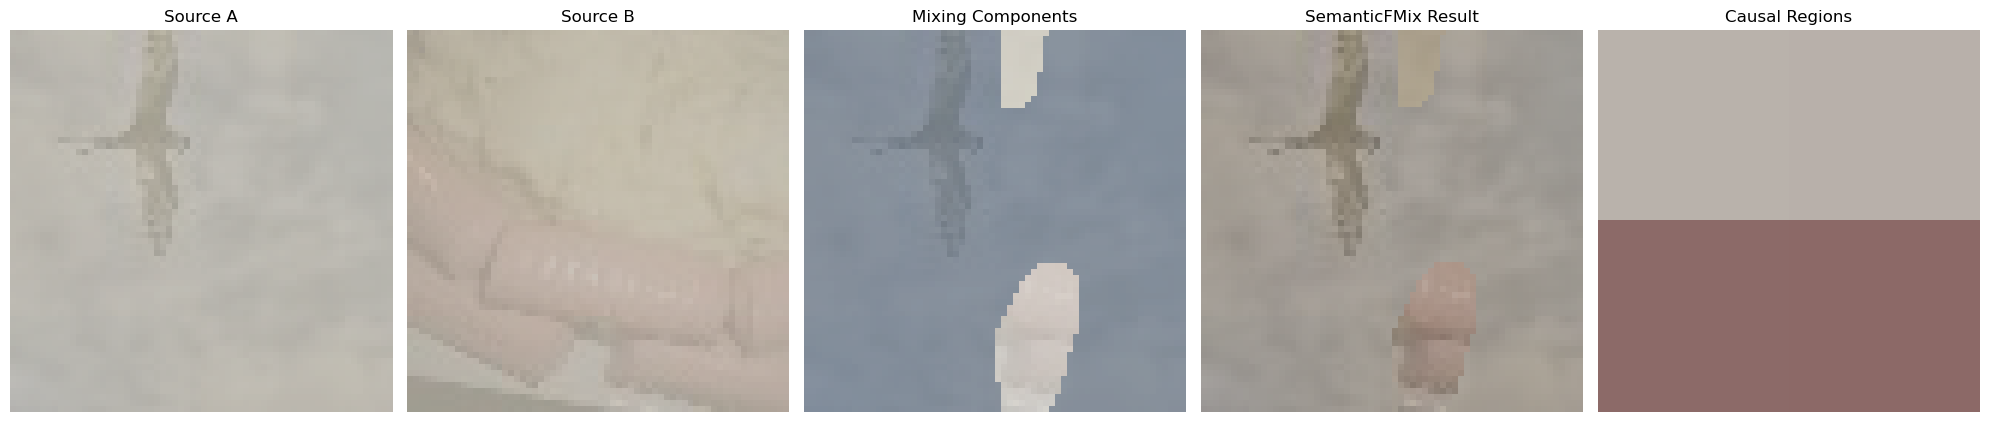

In [ ]:

if __name__ == "__main__":

    semantic_fmix = SemanticFMix(alpha=1.0, decay_power=3, 
                               size=(64,64), obj_ratio=0.7)
    
    final_img, final_mask, seg_a, seg_b = semantic_fmix.apply_semantic_fmix(img_a, img_b)
  
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    tin_imshow(img_a, "Source A", seg_mask=seg_a)
    plt.subplot(1, 5, 2)
    tin_imshow(img_b, "Source B", seg_mask=seg_b)
    
  
    plt.subplot(1, 5, 3)
    tin_imshow(final_img, "Mixing Components", 
              mask=final_mask, seg_mask=(seg_a | seg_b).float())
    

    plt.subplot(1, 5, 4)
    tin_imshow(final_img, "SemanticFMix Result")
  
    plt.subplot(1, 5, 5)
    causal_mask = get_causal_mask(final_img)
    tin_imshow(final_img, "Causal Regions", causal_mask=causal_mask)
    
    plt.tight_layout()
    plt.show()

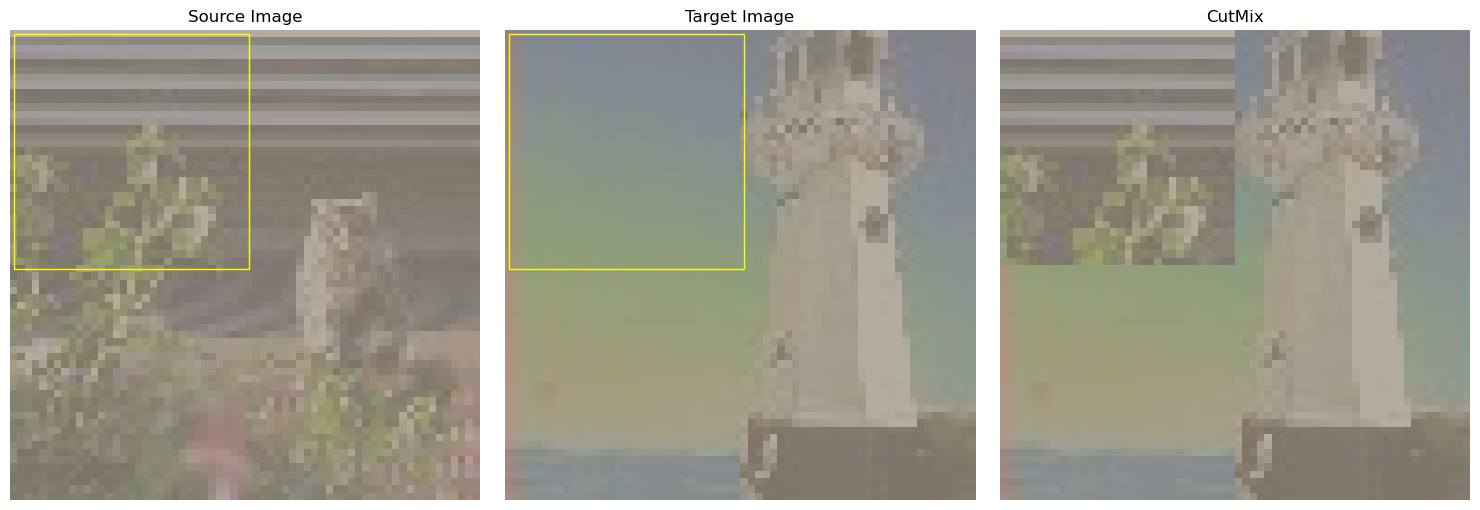

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class FixedPositionCutMix:
    def __init__(self, 
                src_crop_box=(16, 16, 32),  # (x, y, size)
                dst_paste_box=(16, 16, 32)):
    
    
    
        assert src_crop_box[2] == dst_paste_box[2], "裁剪尺寸与粘贴尺寸必须相同"
        self.validate_box(src_crop_box, img_size=64)
        self.validate_box(dst_paste_box, img_size=64)
        self.src_box = src_crop_box
        self.dst_box = dst_paste_box

    @staticmethod
    def validate_box(box, img_size=64):
        x, y, size = box
        assert x >= 0 and y >= 0, "坐标不能为负"
        assert x + size <= img_size, "横向越界"
        assert y + size <= img_size, "纵向越界"

    def __call__(self, img_a, img_b):

        src_x, src_y, crop_size = self.src_box
        dst_x, dst_y, paste_size = self.dst_box
        

        patch = img_a[:, src_y:src_y+crop_size, src_x:src_x+crop_size]

        mixed_img = img_b.clone()
        mixed_img[:, dst_y:dst_y+paste_size, dst_x:dst_x+paste_size] = patch
        
        return mixed_img, self.src_box, self.dst_box


def tin_imshow(img, title=None, box=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img.cpu() * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0)
    
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    if box:
        x, y, size = box
        rect = patches.Rectangle((x, y), size, size, 
                               linewidth=1, edgecolor='yellow', 
                               facecolor='none')
        plt.gca().add_patch(rect)


if __name__ == "__main__":
   
    patterns = {
        'center': ((16, 16, 32), (16, 16, 32)),    # 中心32x32区域
        'top-left': ((0, 0, 32), (0, 0, 32)),      # 左上角
        'cross': ((16, 0, 32), (0, 16, 32)),       # 横向交叉
        'diagonal': ((0, 0, 32), (32, 32, 32))     # 对角线
    }
  
    raw_transform = transforms.Compose([transforms.ToTensor()])
    trainset = ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/train',
        transform=raw_transform
    )
    loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)
    images, _ = next(iter(loader))
    img_a, img_b = images[0], images[1]
    
 
    augmenter = FixedPositionCutMix(
        src_crop_box=(0, 0, 32),
        dst_paste_box=(0, 0, 32)
    )
    

    mixed_img, src_box, dst_box = augmenter(img_a, img_b)
    
 
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    tin_imshow(img_a, "Source Image", src_box)
    
    plt.subplot(1, 3, 2)
    tin_imshow(img_b, "Target Image", dst_box)
    
    plt.subplot(1, 3, 3)
    tin_imshow(mixed_img, "CutMix")
    
    plt.tight_layout()
    plt.show()

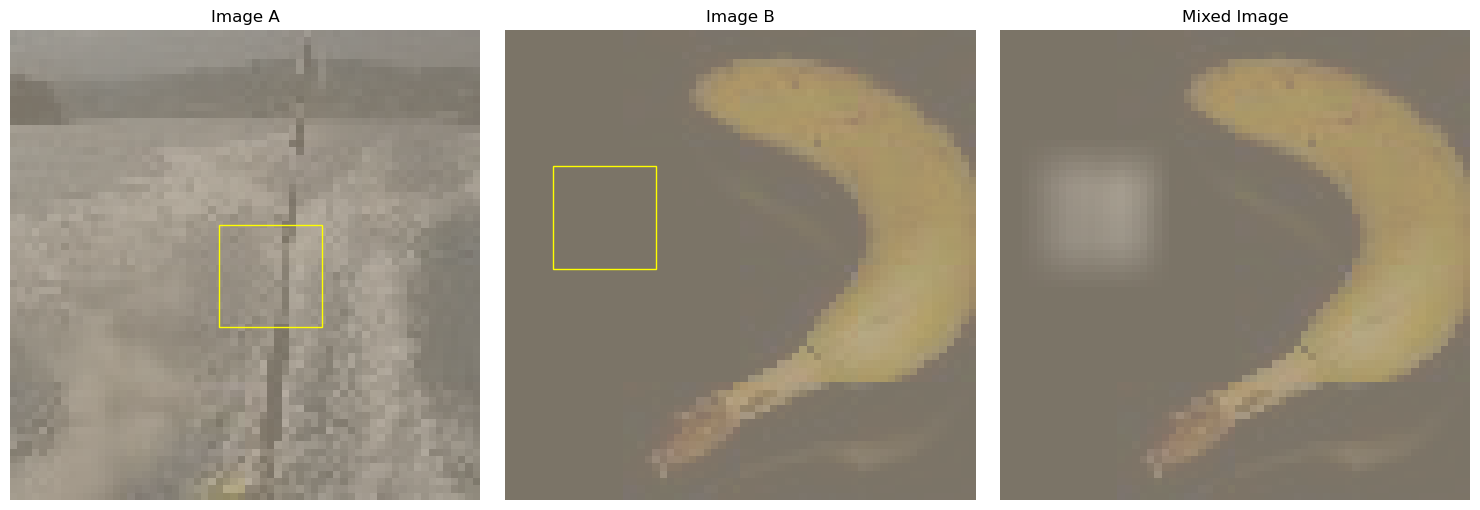

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision.transforms.functional import gaussian_blur
import matplotlib.patches as patches

class SquareMixAugmentation:
    def __init__(self, crop_ratio_range=(0.2, 0.4), blur_radius=7, blur_sigma=3.0):
       
        self.crop_ratio_range = crop_ratio_range
        self.blur_radius = blur_radius
        self.blur_sigma = blur_sigma

    def __call__(self, img_a, img_b):
   
        crop_ratio = torch.empty(1).uniform_(*self.crop_ratio_range).item()
        crop_size = int(crop_ratio * 64) 
  
        x = torch.randint(0, 64 - crop_size, (1,)).item()
        y = torch.randint(0, 64 - crop_size, (1,)).item()
        
  
        patch = img_a[:, y:y+crop_size, x:x+crop_size]
        
 
        paste_x = torch.randint(0, 64 - crop_size, (1,)).item()
        paste_y = torch.randint(0, 64 - crop_size, (1,)).item()
        

        mixed_img = img_b.clone()
        mixed_img[:, paste_y:paste_y+crop_size, paste_x:paste_x+crop_size] = patch
        

        blur_mask = torch.zeros_like(mixed_img)
        blur_padding = self.blur_radius // 2
        y_start = max(0, paste_y - blur_padding)
        y_end = min(64, paste_y + crop_size + blur_padding)
        x_start = max(0, paste_x - blur_padding)
        x_end = min(64, paste_x + crop_size + blur_padding)
        blur_mask[:, y_start:y_end, x_start:x_end] = 1
        
      
        blurred_img = gaussian_blur(mixed_img, 
                                  kernel_size=self.blur_radius,
                                  sigma=(self.blur_sigma, self.blur_sigma))
        mixed_img = mixed_img * (1 - blur_mask) + blurred_img * blur_mask
        
        return mixed_img, (x, y, crop_size), (paste_x, paste_y, crop_size)

def tin_imshow(img, title=None, box=None):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img.cpu() * std + mean  
    img = img.clamp(0, 1).permute(1, 2, 0)
    
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off')
    
    if box:
        x, y, size = box
        rect = patches.Rectangle((x, y), size, size, 
                               linewidth=1, edgecolor='yellow', 
                               facecolor='none')
        plt.gca().add_patch(rect)


if __name__ == "__main__":

    raw_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    trainset = ImageFolder(
        root='/Users/yl38u22/myResearch/data/tiny-imagenet-200/train',
        transform=raw_transform
    )
    
    loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)
    

    images, _ = next(iter(loader))
    img_a, img_b = images[0], images[1]
   
    augmenter = SquareMixAugmentation()
    mixed_img, crop_box, paste_box = augmenter(img_a, img_b)
    
 
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    tin_imshow(img_a, "Image A", crop_box)
    
    plt.subplot(1, 3, 2)
    tin_imshow(img_b, "Image B", paste_box)
    
    plt.subplot(1, 3, 3)
    tin_imshow(mixed_img, "Mixed Image")
    
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import shutil

def reorganize_tiny_imagenet(data_root='~/data'):
    data_root = os.path.expanduser(data_root)
    base_dir = os.path.join(data_root, 'tiny-imagenet-200')
    
    val_dir = os.path.join(base_dir, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    val_annotations = os.path.join(val_dir, 'val_annotations.txt')

    new_val_dir = os.path.join(base_dir, 'val')
    if not os.path.exists(new_val_dir):
        os.makedirs(new_val_dir, exist_ok=True)

        with open(val_annotations, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                img_name, class_id = parts[0], parts[1]
            
                class_dir = os.path.join(new_val_dir, class_id)
                os.makedirs(class_dir, exist_ok=True)
                
              
                src = os.path.join(val_images_dir, img_name)
                dst = os.path.join(class_dir, img_name)
                shutil.copy(src, dst)  

        print(f"Validation set reorganized at {new_val_dir}")
    else:
        print(f"Validation set already exists at {new_val_dir}")

if __name__ == "__main__":
    reorganize_tiny_imagenet()

FileNotFoundError: [Errno 2] No such file or directory: '/home/yl38u22/data/tiny-imagenet-200/val/val_annotations.txt'

In [ ]:
import os
import shutil

def reorganize_val(data_root='/data/tiny-imagenet-200'):
    val_dir = os.path.join(data_root, 'val')
    images_dir = os.path.join(val_dir, 'images')
    annotations_file = os.path.join(val_dir, 'val_annotations.txt')


    with open(annotations_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            src = os.path.join(images_dir, img_name)
            dst = os.path.join(class_dir, img_name)
            shutil.copy(src, dst)
    print(f"验证集重组完成，路径：{val_dir}")

if __name__ == "__main__":
    reorganize_val()

FileNotFoundError: [Errno 2] No such file or directory: '/data/tiny-imagenet-200/val/images/val_0.JPEG'